# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BUILD DATASET & DATALOADERS

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.01 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [16]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

In [17]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.train()
    start_time = time.time()

    confidences = []
    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(confidences, 90)
        items_greater_than_average = uncertainties[confidences >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            most_uncertain_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in most_uncertain_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in most_uncertain_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(most_uncertain_indices))
        print(f"Sampling duration: {duration} seconds")

In [18]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{current_train_size}.csv", index=False)

In [19]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

In [20]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'pornografi': [y_train[i][0] for i in temp],
            'sara': [y_train[i][1] for i in temp],
            'radikalisme': [y_train[i][2] for i in temp],
            'pencemaran_nama_baik': [y_train[i][3] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i, sampling_strategy, init_size=5):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()
    filename = f'netifier-{sampling_strategy}-init-{init_size}'

    set_seed(seed)
    
    print("===============================================")
    print(f"Init size: {init_size}")
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        if sampling_strategy == 'lc':
            print("LC")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'mc':
            print("MC")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'kmeans':
            print("KMeans")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
            notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'coreset':
            print("Coreset")
            sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'random':
            print("Random")
            random_sampling(current_train_size, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)

        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-results.csv', index=False)

## LEAST CONFIDENCE

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6885, Accuracy: 0.7555, F1 Micro: 0.0778, F1 Macro: 0.0413
Epoch 2/10, Train Loss: 0.5719, Accuracy: 0.7855, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.5141, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.4529, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 5/10, Train Loss: 0.4945, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 6/10, Train Loss: 0.4802, Accuracy: 0.7867, F1 Micro: 0.0029, F1 Macro: 0.002
Epoch 7/10, Train Loss: 0.4452, Accuracy: 0.7878, F1 Micro: 0.0382, F1 Macro: 0.0245
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3629, Accuracy: 0.7859, F1 Micro: 0.1138, F1 Macro: 0.0642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4015, Accuracy: 0.7864, F1 Micro: 0.1343, F1 Macro: 0.0781
Epoch 10/10, Train Loss: 0.3367, Accuracy: 0.7883, F1 Micro: 0.1091, F1 Macro: 0.0697

 Iteration 77: Accuracy: 0.7864, F1 Micro: 0.1343, F1 Macro: 0.0781
      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4451, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3211, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3099, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2682, Accuracy: 0.7861, F1 Micro: 0.0029, F1 Macro: 0.002
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2566, Accuracy: 0.818, F1 Micro: 0.372, F1 Macro: 0.251
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2251, Accuracy: 0.8361, F1 Micro: 0.5758, F1 Macro: 0.4963
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1929, Accuracy: 0.8391, F1 Micro: 0.6363, F1 Macro: 0.6027
Epoch 8/10, Train Loss: 0.1694, Accuracy: 0.8552, F1 Micro: 0.6016, F1 Macro: 0.5059
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1309, Accuracy: 0.862, F1 Micro: 0.6509, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3582, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2292, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.221, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.8058, F1 Micro: 0.3536, F1 Macro: 0.2287
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.8344, F1 Micro: 0.4105, F1 Macro: 0.3199
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.8342, F1 Micro: 0.6441, F1 Macro: 0.6344
Epoch 7/10, Train Loss: 0.1109, Accuracy: 0.8644, F1 Micro: 0.638, F1 Macro: 0.603
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.8617, F1 Micro: 0.6495, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.8675, F1 Micro: 0.6805, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3073, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2196, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.7927, F1 Micro: 0.0753, F1 Macro: 0.047
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.8288, F1 Micro: 0.4781, F1 Macro: 0.3233
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.858, F1 Micro: 0.6871, F1 Macro: 0.6798
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.867, F1 Micro: 0.6904, F1 Macro: 0.6839
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.8614, F1 Micro: 0.6917, F1 Macro: 0.6819
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.8709, F1 Micro: 0.6916, F1 Macro: 0.6842
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.8652, F1 Micro: 0.6764, F1 Macro: 0.6692
Epoch 10/10, Train 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3157, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2538, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2256, Accuracy: 0.8028, F1 Micro: 0.1982, F1 Macro: 0.1888
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.8266, F1 Micro: 0.4064, F1 Macro: 0.4068
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.882, F1 Micro: 0.7269, F1 Macro: 0.725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.8842, F1 Micro: 0.7358, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.8772, F1 Micro: 0.7404, F1 Macro: 0.7409
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.8752, F1 Micro: 0.7397, F1 Macro: 0.7435
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.8842, F1 Micro: 0.7426, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3144, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.255, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.8519, F1 Micro: 0.5798, F1 Macro: 0.5755
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.8652, F1 Micro: 0.7181, F1 Macro: 0.7299
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.8869, F1 Micro: 0.746, F1 Macro: 0.7469
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.8811, F1 Micro: 0.7404, F1 Macro: 0.7388
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.8784, F1 Micro: 0.7377, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.883, F1 Micro: 0.7494, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.8852, F1 Micro: 0.7533, F1 Macro: 0.759
Epoch 10/10, Train L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3237, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.8186, F1 Micro: 0.282, F1 Macro: 0.2447
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2171, Accuracy: 0.8655, F1 Micro: 0.669, F1 Macro: 0.6403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.8833, F1 Micro: 0.7521, F1 Macro: 0.7509
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.8909, F1 Micro: 0.7399, F1 Macro: 0.74
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0791, Accuracy: 0.8911, F1 Micro: 0.7577, F1 Macro: 0.7588
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.8898, F1 Micro: 0.7532, F1 Macro: 0.7551
Epoch 8/10, Train Loss: 0.0414, Accuracy: 0.8875, F1 Micro: 0.7569, F1 Macro: 0.7596
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.8861, F1 Micro: 0.7577, F1 Macro: 0.7627
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.8841, F1 Micro: 0.7507, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3552, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2695, Accuracy: 0.8495, F1 Micro: 0.556, F1 Macro: 0.5339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.8878, F1 Micro: 0.745, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.8927, F1 Micro: 0.751, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.8931, F1 Micro: 0.7524, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.8959, F1 Micro: 0.7633, F1 Macro: 0.7591
Epoch 7/10, Train Loss: 0.0614, Accuracy: 0.8947, F1 Micro: 0.7601, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.8966, F1 Micro: 0.77, F1 Macro: 0.7692
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.8931, F1 Micro: 0.7502, F1 Macro: 0.7424
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3614, Accuracy: 0.7872, F1 Micro: 0.0058, F1 Macro: 0.0039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2599, Accuracy: 0.8709, F1 Micro: 0.6402, F1 Macro: 0.6194
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2211, Accuracy: 0.8842, F1 Micro: 0.6768, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.8853, F1 Micro: 0.7587, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.898, F1 Micro: 0.7625, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.8917, F1 Micro: 0.7677, F1 Macro: 0.7733
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.8903, F1 Micro: 0.7651, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.8969, F1 Micro: 0.7723, F1 Macro: 0.7739
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.8922, F1 Micro: 0.77, F1 Macro: 0.7733
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3737, Accuracy: 0.7955, F1 Micro: 0.1149, F1 Macro: 0.1129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2655, Accuracy: 0.8817, F1 Micro: 0.736, F1 Macro: 0.7408
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2135, Accuracy: 0.8945, F1 Micro: 0.7616, F1 Macro: 0.7563
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.8977, F1 Micro: 0.7638, F1 Macro: 0.7607
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.8998, F1 Micro: 0.7536, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.8989, F1 Micro: 0.774, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.8989, F1 Micro: 0.7753, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9019, F1 Micro: 0.7792, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.8991, F1 Micro: 0.7659, F1 Macro: 0.7626
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.8059, F1 Micro: 0.2771, F1 Macro: 0.18
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2764, Accuracy: 0.8841, F1 Micro: 0.6976, F1 Macro: 0.6925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2145, Accuracy: 0.8903, F1 Micro: 0.7561, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.8861, F1 Micro: 0.7651, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.8989, F1 Micro: 0.7702, F1 Macro: 0.7687
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.8988, F1 Micro: 0.7679, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.8958, F1 Micro: 0.7732, F1 Macro: 0.7736
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.897, F1 Micro: 0.7727, F1 Macro: 0.7764
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.8992, F1 Micro: 0.7726, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3808, Accuracy: 0.8394, F1 Micro: 0.4685, F1 Macro: 0.4535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2701, Accuracy: 0.8844, F1 Micro: 0.7548, F1 Macro: 0.7574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2113, Accuracy: 0.8945, F1 Micro: 0.772, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.8927, F1 Micro: 0.7732, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9047, F1 Micro: 0.782, F1 Macro: 0.7772
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9019, F1 Micro: 0.7703, F1 Macro: 0.7591
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.8978, F1 Micro: 0.7731, F1 Macro: 0.7761
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9017, F1 Micro: 0.7806, F1 Macro: 0.7826
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9059, F1 Micro: 0.7777, F1 Macro: 0.7737
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.9013, F1 Micro: 0.7765, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3835, Accuracy: 0.843, F1 Micro: 0.4854, F1 Macro: 0.4484
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2738, Accuracy: 0.8759, F1 Micro: 0.7109, F1 Macro: 0.7081
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2256, Accuracy: 0.898, F1 Micro: 0.7672, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.8967, F1 Micro: 0.772, F1 Macro: 0.7723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9048, F1 Micro: 0.7796, F1 Macro: 0.7778
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.8952, F1 Micro: 0.7758, F1 Macro: 0.7761
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.8984, F1 Micro: 0.7718, F1 Macro: 0.7724
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9011, F1 Micro: 0.7766, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9039, F1 Micro: 0.774, F1 Macro: 0.7727
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.9013, F1 Micro: 0.7779, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3958, Accuracy: 0.8578, F1 Micro: 0.5912, F1 Macro: 0.5889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2759, Accuracy: 0.893, F1 Micro: 0.7338, F1 Macro: 0.7294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2231, Accuracy: 0.8886, F1 Micro: 0.7627, F1 Macro: 0.7672
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.8983, F1 Micro: 0.7604, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9008, F1 Micro: 0.7741, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9, F1 Micro: 0.7772, F1 Macro: 0.7773
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9017, F1 Micro: 0.775, F1 Macro: 0.7735
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9002, F1 Micro: 0.7735, F1 Macro: 0.7703
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9017, F1 Micro: 0.7693, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.8983, F1 Micro: 0.7723, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3939, Accuracy: 0.8558, F1 Micro: 0.6429, F1 Macro: 0.6484
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2741, Accuracy: 0.892, F1 Micro: 0.7512, F1 Macro: 0.7502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.214, Accuracy: 0.8975, F1 Micro: 0.7632, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.8997, F1 Micro: 0.7801, F1 Macro: 0.7792
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9008, F1 Micro: 0.7559, F1 Macro: 0.7521
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9005, F1 Micro: 0.7686, F1 Macro: 0.7658
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9011, F1 Micro: 0.766, F1 Macro: 0.7624
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9003, F1 Micro: 0.7656, F1 Macro: 0.7648
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.8991, F1 Micro: 0.767, F1 Macro: 0.7626
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.898, F1 Micro: 0.7716, F1 Macro: 0.7715

 Iteration 4663: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.405, Accuracy: 0.8652, F1 Micro: 0.5935, F1 Macro: 0.5566
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2721, Accuracy: 0.8939, F1 Micro: 0.7328, F1 Macro: 0.7286
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2141, Accuracy: 0.9011, F1 Micro: 0.7627, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.8995, F1 Micro: 0.7802, F1 Macro: 0.7789
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.903, F1 Micro: 0.7607, F1 Macro: 0.7446
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9023, F1 Micro: 0.7789, F1 Macro: 0.777
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.8961, F1 Micro: 0.7692, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9006, F1 Micro: 0.7764, F1 Macro: 0.7752
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.9008, F1 Micro: 0.7661, F1 Macro: 0.7569
Epoch 10/10, Train Loss: 0.0357, Accuracy: 0.9031, F1 Micro: 0.7742, F1 Macro: 0.7715

 Iteration 4863: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3979, Accuracy: 0.8755, F1 Micro: 0.6782, F1 Macro: 0.6704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2686, Accuracy: 0.8848, F1 Micro: 0.7622, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.8994, F1 Micro: 0.7782, F1 Macro: 0.7778
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9009, F1 Micro: 0.7525, F1 Macro: 0.7321
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9009, F1 Micro: 0.7562, F1 Macro: 0.7424
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9019, F1 Micro: 0.7744, F1 Macro: 0.7738
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.8973, F1 Micro: 0.7718, F1 Macro: 0.7685
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.8977, F1 Micro: 0.766, F1 Macro: 0.7613
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.8997, F1 Micro: 0.7672, F1 Macro: 0.762
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.8991, F1 Micro: 0.7688, F1 Macro: 0.7671

 Iteration 5063: Accuracy: 0.8994, F1 Micro: 0.7782

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4013, Accuracy: 0.8819, F1 Micro: 0.7128, F1 Macro: 0.7061
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.8961, F1 Micro: 0.7425, F1 Macro: 0.7348
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2179, Accuracy: 0.8997, F1 Micro: 0.7555, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.8983, F1 Micro: 0.7725, F1 Macro: 0.769
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9028, F1 Micro: 0.7665, F1 Macro: 0.7608
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.9038, F1 Micro: 0.7779, F1 Macro: 0.7765
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9031, F1 Micro: 0.7685, F1 Macro: 0.7631
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9019, F1 Micro: 0.7691, F1 Macro: 0.7626
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.8998, F1 Micro: 0.7698, F1 Macro: 0.7669
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.8995, F1 Micro: 0.76, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3943, Accuracy: 0.8834, F1 Micro: 0.7239, F1 Macro: 0.7162
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.9016, F1 Micro: 0.7722, F1 Macro: 0.7632
Epoch 3/10, Train Loss: 0.2138, Accuracy: 0.9048, F1 Micro: 0.7668, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.172, Accuracy: 0.903, F1 Micro: 0.7746, F1 Macro: 0.7691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9052, F1 Micro: 0.7798, F1 Macro: 0.7776
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9009, F1 Micro: 0.775, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9022, F1 Micro: 0.7829, F1 Macro: 0.7812
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9008, F1 Micro: 0.7823, F1 Macro: 0.7816
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.9056, F1 Micro: 0.787, F1 Macro: 0.7852
Epoch 10/10, Train Loss: 0.0356, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3916, Accuracy: 0.875, F1 Micro: 0.6438, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2661, Accuracy: 0.9006, F1 Micro: 0.7756, F1 Macro: 0.7673
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.9017, F1 Micro: 0.7656, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9095, F1 Micro: 0.7794, F1 Macro: 0.7766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9013, F1 Micro: 0.7801, F1 Macro: 0.7789
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9045, F1 Micro: 0.7768, F1 Macro: 0.7735
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.8992, F1 Micro: 0.7758, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.9061, F1 Micro: 0.785, F1 Macro: 0.7814
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9031, F1 Micro: 0.7828, F1 Macro: 0.7838
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9036, F1 Micro: 0.7839, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3795, Accuracy: 0.8831, F1 Micro: 0.7064, F1 Macro: 0.6754
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.8969, F1 Micro: 0.7689, F1 Macro: 0.7697
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.9038, F1 Micro: 0.7672, F1 Macro: 0.7567
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9016, F1 Micro: 0.7537, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.9062, F1 Micro: 0.7802, F1 Macro: 0.7766
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9044, F1 Micro: 0.7694, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9056, F1 Micro: 0.7834, F1 Macro: 0.7816
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9019, F1 Micro: 0.7749, F1 Macro: 0.7688
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9034, F1 Micro: 0.7832, F1 Macro: 0.7823
Epoch 10/10, Train Loss: 0.0358, Accuracy: 0.9078, F1 Micro: 0.7812, F1 Macro: 0.7763

 Iteration 5841: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3736, Accuracy: 0.8825, F1 Micro: 0.7051, F1 Macro: 0.7053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.241, Accuracy: 0.9011, F1 Micro: 0.7762, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1955, Accuracy: 0.9056, F1 Micro: 0.7894, F1 Macro: 0.7854
Epoch 4/10, Train Loss: 0.1603, Accuracy: 0.9042, F1 Micro: 0.7788, F1 Macro: 0.7742
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9047, F1 Micro: 0.784, F1 Macro: 0.7816
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.9016, F1 Micro: 0.7748, F1 Macro: 0.7696
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.902, F1 Micro: 0.7808, F1 Macro: 0.7815
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.8978, F1 Micro: 0.776, F1 Macro: 0.7742
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9052, F1 Micro: 0.7806, F1 Macro: 0.7799
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9056, F1 Micro: 0.7823, F1 Macro: 0.7766

 Iteration 6041: Accuracy: 0.9056, F1 Micro: 0.7894, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3706, Accuracy: 0.8866, F1 Micro: 0.7073, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2398, Accuracy: 0.9017, F1 Micro: 0.7783, F1 Macro: 0.7733
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9053, F1 Micro: 0.7754, F1 Macro: 0.7713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9083, F1 Micro: 0.7857, F1 Macro: 0.7826
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1194, Accuracy: 0.9066, F1 Micro: 0.7918, F1 Macro: 0.7896
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.903, F1 Micro: 0.764, F1 Macro: 0.7613
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.9033, F1 Micro: 0.7773, F1 Macro: 0.773
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.9042, F1 Micro: 0.7677, F1 Macro: 0.7632
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.907, F1 Micro: 0.782, F1 Macro: 0.7777
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9064, F1 Micro: 0.7749, F1 Macro: 0.7714

 Iteration 6218: Accu

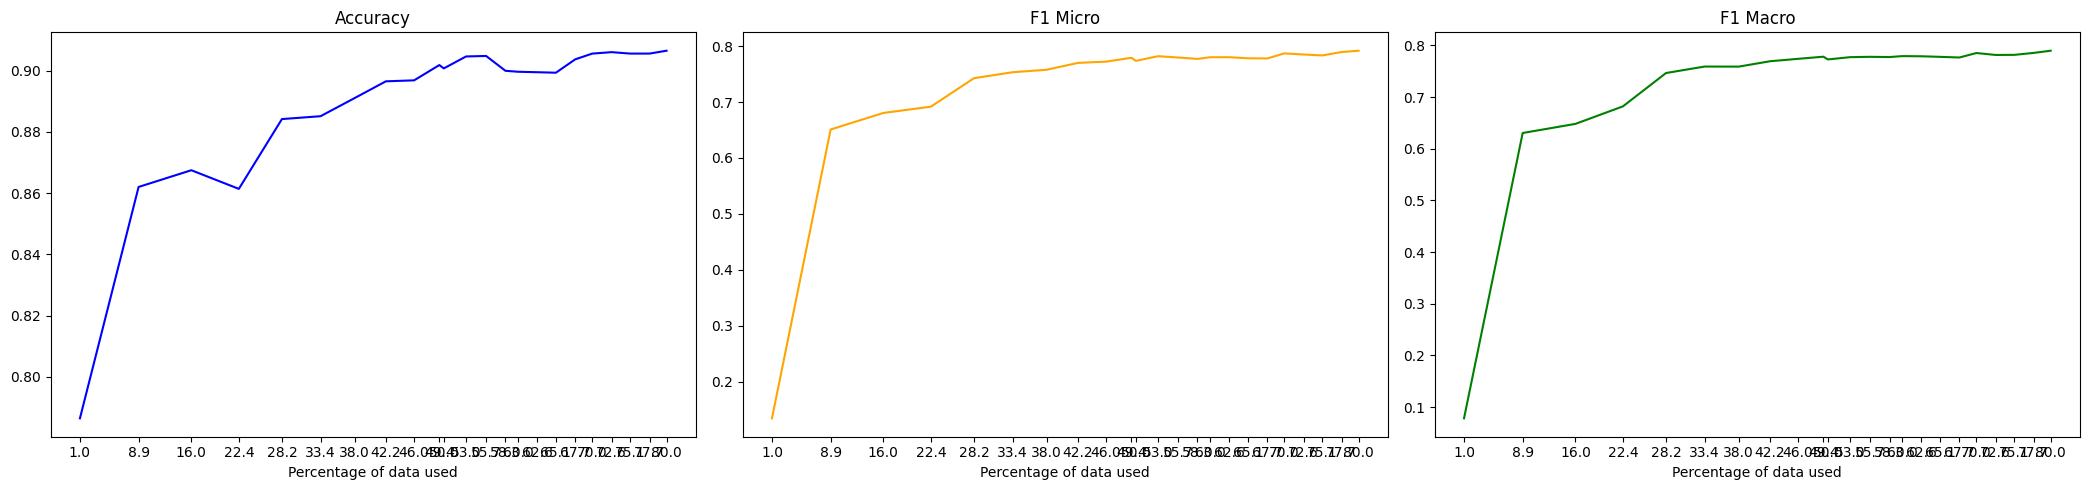

In [ ]:
initial_train_size = int(0.01 * total_data)
active_learning(50, 0, 'lc', 1)

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5424, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4401, Accuracy: 0.8241, F1 Micro: 0.3117, F1 Macro: 0.2115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3843, Accuracy: 0.8481, F1 Micro: 0.5106, F1 Macro: 0.4401
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3098, Accuracy: 0.867, F1 Micro: 0.6282, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2726, Accuracy: 0.877, F1 Micro: 0.6974, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2296, Accuracy: 0.8792, F1 Micro: 0.7194, F1 Macro: 0.7138
Epoch 7/10, Train Loss: 0.1744, Accuracy: 0.8816, F1 Micro: 0.7073, F1 Macro: 0.6952
Epoch 8/10, Train Loss: 0.1438, Accuracy: 0.8809, F1 Micro: 0.7176, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1025, Accuracy: 0.8813, F1 Micro: 0.733, F1 Macro: 0.7279
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4398, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3268, Accuracy: 0.8345, F1 Micro: 0.4061, F1 Macro: 0.3287
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2567, Accuracy: 0.865, F1 Micro: 0.6256, F1 Macro: 0.6161
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2076, Accuracy: 0.8777, F1 Micro: 0.6901, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1656, Accuracy: 0.8777, F1 Micro: 0.7143, F1 Macro: 0.7096
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.8805, F1 Micro: 0.7186, F1 Macro: 0.7042
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.8841, F1 Micro: 0.7161, F1 Macro: 0.7018
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.88, F1 Micro: 0.6808, F1 Macro: 0.6623
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.8819, F1 Micro: 0.7056, F1 Macro: 0.6958
Higher F1 achieved, saving model
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3868, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2825, Accuracy: 0.8552, F1 Micro: 0.5734, F1 Macro: 0.5219
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.8773, F1 Micro: 0.6864, F1 Macro: 0.6794
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.8778, F1 Micro: 0.6914, F1 Macro: 0.6874
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1268, Accuracy: 0.8769, F1 Micro: 0.7275, F1 Macro: 0.7287
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.8814, F1 Micro: 0.7281, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.8884, F1 Micro: 0.7338, F1 Macro: 0.7294
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.8873, F1 Micro: 0.735, F1 Macro: 0.7305
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.8872, F1 Micro: 0.73

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3529, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.244, Accuracy: 0.8506, F1 Micro: 0.5196, F1 Macro: 0.4906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.8823, F1 Micro: 0.7129, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.8841, F1 Micro: 0.7157, F1 Macro: 0.6923
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.8834, F1 Micro: 0.6977, F1 Macro: 0.678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.8894, F1 Micro: 0.7431, F1 Macro: 0.7378
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.8888, F1 Micro: 0.7498, F1 Macro: 0.7463
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.8913, F1 Micro: 0.7405, F1 Macro: 0.7383
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.8884, F1 Micro: 0.7463, F1 Macro: 0.7422
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3355, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.237, Accuracy: 0.8677, F1 Micro: 0.6583, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1841, Accuracy: 0.882, F1 Micro: 0.6907, F1 Macro: 0.6705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.8844, F1 Micro: 0.7407, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.8859, F1 Micro: 0.7519, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.8884, F1 Micro: 0.7546, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.8905, F1 Micro: 0.7557, F1 Macro: 0.7558
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.8919, F1 Micro: 0.7389, F1 Macro: 0.7345
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.8959, F1 Micro: 0.752, F1 Macro: 0.7508
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3658, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.8727, F1 Micro: 0.6501, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.8863, F1 Micro: 0.7165, F1 Macro: 0.7186
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1513, Accuracy: 0.8914, F1 Micro: 0.7228, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.8917, F1 Micro: 0.765, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0854, Accuracy: 0.8964, F1 Micro: 0.7655, F1 Macro: 0.7611
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.8908, F1 Micro: 0.7597, F1 Macro: 0.7578
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.8953, F1 Micro: 0.7522, F1 Macro: 0.7477
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.8906, F1 Micro: 0.7525, F1 Macro: 0.7444
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3615, Accuracy: 0.8062, F1 Micro: 0.1722, F1 Macro: 0.1333
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2643, Accuracy: 0.8752, F1 Micro: 0.6681, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.8928, F1 Micro: 0.7482, F1 Macro: 0.7475
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.8927, F1 Micro: 0.7445, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.8995, F1 Micro: 0.7704, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9005, F1 Micro: 0.7709, F1 Macro: 0.764
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.8922, F1 Micro: 0.768, F1 Macro: 0.7658
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.8936, F1 Micro: 0.7667, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.8983, F1 Micro: 0.7731, F1 Macro: 0.7706
Epoch 10/10, Train Loss: 0.0322, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3762, Accuracy: 0.8044, F1 Micro: 0.1709, F1 Macro: 0.1589
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2761, Accuracy: 0.8816, F1 Micro: 0.7129, F1 Macro: 0.7151
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.8927, F1 Micro: 0.7298, F1 Macro: 0.7277
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.8916, F1 Micro: 0.7687, F1 Macro: 0.7658
Epoch 5/10, Train Loss: 0.1271, Accuracy: 0.8948, F1 Micro: 0.7679, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9008, F1 Micro: 0.7777, F1 Macro: 0.7779
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.8955, F1 Micro: 0.7662, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.8917, F1 Micro: 0.7628, F1 Macro: 0.7617
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.8942, F1 Micro: 0.7696, F1 Macro: 0.7678
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.8977, F1 Micro: 0.7688, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3777, Accuracy: 0.8294, F1 Micro: 0.3599, F1 Macro: 0.311
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.887, F1 Micro: 0.7406, F1 Macro: 0.7286
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2085, Accuracy: 0.892, F1 Micro: 0.7517, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.8977, F1 Micro: 0.7711, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.8952, F1 Micro: 0.7738, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.8975, F1 Micro: 0.7779, F1 Macro: 0.7789
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.8961, F1 Micro: 0.7685, F1 Macro: 0.7674
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.898, F1 Micro: 0.7754, F1 Macro: 0.7727
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.8972, F1 Micro: 0.7768, F1 Macro: 0.7772
Epoch 10/10, Train Loss: 0.0332, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3754, Accuracy: 0.8228, F1 Micro: 0.3185, F1 Macro: 0.2893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.8861, F1 Micro: 0.7464, F1 Macro: 0.7482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.218, Accuracy: 0.897, F1 Micro: 0.756, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.8989, F1 Micro: 0.7773, F1 Macro: 0.7748
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.8988, F1 Micro: 0.777, F1 Macro: 0.7767
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.8952, F1 Micro: 0.7742, F1 Macro: 0.7747
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.8931, F1 Micro: 0.7706, F1 Macro: 0.7685
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.8942, F1 Micro: 0.7732, F1 Macro: 0.7738
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9016, F1 Micro: 0.7742, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9006, F1 Micro: 0.7775, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3732, Accuracy: 0.8594, F1 Micro: 0.6025, F1 Macro: 0.5771
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.8944, F1 Micro: 0.742, F1 Macro: 0.7279
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.212, Accuracy: 0.8981, F1 Micro: 0.7624, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.8958, F1 Micro: 0.7709, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9, F1 Micro: 0.7758, F1 Macro: 0.7746
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.8917, F1 Micro: 0.7705, F1 Macro: 0.7733
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.893, F1 Micro: 0.7723, F1 Macro: 0.7767
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.895, F1 Micro: 0.7746, F1 Macro: 0.7738
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.8958, F1 Micro: 0.7755, F1 Macro: 0.7729
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9, F1 Micro: 0.774, F1 Macro: 0.772

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3734, Accuracy: 0.857, F1 Micro: 0.5508, F1 Macro: 0.4778
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2611, Accuracy: 0.892, F1 Micro: 0.7354, F1 Macro: 0.7311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.8972, F1 Micro: 0.7652, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.8998, F1 Micro: 0.7761, F1 Macro: 0.7728
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9031, F1 Micro: 0.7739, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.9003, F1 Micro: 0.7808, F1 Macro: 0.7812
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.898, F1 Micro: 0.7692, F1 Macro: 0.7674
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.8998, F1 Micro: 0.7656, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.8983, F1 Micro: 0.78, F1 Macro: 0.7813
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.9011, F1 Micro: 0.7769, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3847, Accuracy: 0.86, F1 Micro: 0.5634, F1 Macro: 0.5338
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2708, Accuracy: 0.8969, F1 Micro: 0.7506, F1 Macro: 0.7457
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.219, Accuracy: 0.9048, F1 Micro: 0.7804, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9056, F1 Micro: 0.7847, F1 Macro: 0.7836
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9062, F1 Micro: 0.781, F1 Macro: 0.7744
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.9039, F1 Micro: 0.7756, F1 Macro: 0.7724
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9011, F1 Micro: 0.7714, F1 Macro: 0.7724
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.8997, F1 Micro: 0.7812, F1 Macro: 0.7796
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9019, F1 Micro: 0.7824, F1 Macro: 0.7824
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.898, F1 Micro: 0.7737, F1 Macro: 0.7771

 Iteration 4530: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3931, Accuracy: 0.8644, F1 Micro: 0.6065, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.8947, F1 Micro: 0.7511, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2139, Accuracy: 0.8998, F1 Micro: 0.768, F1 Macro: 0.7673
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9011, F1 Micro: 0.7509, F1 Macro: 0.7343
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1338, Accuracy: 0.902, F1 Micro: 0.7747, F1 Macro: 0.7701
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.8952, F1 Micro: 0.7687, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.8989, F1 Micro: 0.7773, F1 Macro: 0.7792
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.8992, F1 Micro: 0.7792, F1 Macro: 0.7803
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.8989, F1 Micro: 0.7793, F1 Macro: 0.7807
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3977, Accuracy: 0.88, F1 Micro: 0.7219, F1 Macro: 0.7067
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.8975, F1 Micro: 0.7597, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.9022, F1 Micro: 0.7705, F1 Macro: 0.7655
Epoch 4/10, Train Loss: 0.1742, Accuracy: 0.9006, F1 Micro: 0.7533, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.905, F1 Micro: 0.7713, F1 Macro: 0.7653
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9019, F1 Micro: 0.771, F1 Macro: 0.7656
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9003, F1 Micro: 0.7663, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.9022, F1 Micro: 0.7769, F1 Macro: 0.7771
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9025, F1 Micro: 0.7752, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0341, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3916, Accuracy: 0.8825, F1 Micro: 0.7149, F1 Macro: 0.7097
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.898, F1 Micro: 0.7687, F1 Macro: 0.7667
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2225, Accuracy: 0.9036, F1 Micro: 0.7778, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.8997, F1 Micro: 0.7871, F1 Macro: 0.7888
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9042, F1 Micro: 0.7703, F1 Macro: 0.7558
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9014, F1 Micro: 0.7768, F1 Macro: 0.7708
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.8959, F1 Micro: 0.7756, F1 Macro: 0.7758
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.905, F1 Micro: 0.7791, F1 Macro: 0.7751
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9034, F1 Micro: 0.7748, F1 Macro: 0.7691
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9033, F1 Micro: 0.7713, F1 Macro: 0.7655

 Iteration 5063: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3909, Accuracy: 0.8825, F1 Micro: 0.6872, F1 Macro: 0.684
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.888, F1 Micro: 0.7457, F1 Macro: 0.7504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.9033, F1 Micro: 0.764, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9038, F1 Micro: 0.7707, F1 Macro: 0.7641
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.8994, F1 Micro: 0.7662, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.8975, F1 Micro: 0.7716, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.8977, F1 Micro: 0.7731, F1 Macro: 0.7703
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9005, F1 Micro: 0.7718, F1 Macro: 0.7678
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9003, F1 Micro: 0.7603, F1 Macro: 0.7556
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3799, Accuracy: 0.8877, F1 Micro: 0.7267, F1 Macro: 0.7222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.8961, F1 Micro: 0.7685, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.9027, F1 Micro: 0.7752, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.8964, F1 Micro: 0.7752, F1 Macro: 0.7761
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.9008, F1 Micro: 0.7693, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9023, F1 Micro: 0.7809, F1 Macro: 0.7788
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9025, F1 Micro: 0.7867, F1 Macro: 0.7894
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9038, F1 Micro: 0.77, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.8998, F1 Micro: 0.7813, F1 Macro: 0.7798
Epoch 10/10, Train Loss: 0.0348, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.381, Accuracy: 0.8925, F1 Micro: 0.7344, F1 Macro: 0.7298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.251, Accuracy: 0.8963, F1 Micro: 0.7629, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9052, F1 Micro: 0.782, F1 Macro: 0.7741
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.8973, F1 Micro: 0.7775, F1 Macro: 0.7757
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9047, F1 Micro: 0.7717, F1 Macro: 0.7644
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9022, F1 Micro: 0.7796, F1 Macro: 0.7757
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.9006, F1 Micro: 0.7653, F1 Macro: 0.7604
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.8961, F1 Micro: 0.7687, F1 Macro: 0.7681
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9031, F1 Micro: 0.7721, F1 Macro: 0.7677
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.8997, F1 Micro: 0.7783, F1 Macro: 0.7759

 Iteration 5641: Accuracy: 0.9052, F1 Micro: 0.782, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3926, Accuracy: 0.8839, F1 Micro: 0.7301, F1 Macro: 0.7159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.8994, F1 Micro: 0.761, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9052, F1 Micro: 0.7703, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9044, F1 Micro: 0.7753, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.9073, F1 Micro: 0.788, F1 Macro: 0.7819
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.8986, F1 Micro: 0.7746, F1 Macro: 0.7735
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9048, F1 Micro: 0.7788, F1 Macro: 0.7771
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9005, F1 Micro: 0.7756, F1 Macro: 0.771
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9041, F1 Micro: 0.7767, F1 Macro: 0.772
Epoch 10/10, Train Loss: 0.0359, Accuracy: 0.8978, F1 Micro: 0.7697, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3789, Accuracy: 0.8884, F1 Micro: 0.7326, F1 Macro: 0.7265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2501, Accuracy: 0.9011, F1 Micro: 0.7594, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9022, F1 Micro: 0.7861, F1 Macro: 0.7839
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9031, F1 Micro: 0.7894, F1 Macro: 0.7871
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9067, F1 Micro: 0.7811, F1 Macro: 0.7769
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9041, F1 Micro: 0.7754, F1 Macro: 0.7723
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.9044, F1 Micro: 0.7789, F1 Macro: 0.7757
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9044, F1 Micro: 0.7816, F1 Macro: 0.7782
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9034, F1 Micro: 0.7701, F1 Macro: 0.7602
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9025, F1 Micro: 0.7638, F1 Macro: 0.7529

 Iteration 6041:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3644, Accuracy: 0.8892, F1 Micro: 0.7183, F1 Macro: 0.6957
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.9033, F1 Micro: 0.7715, F1 Macro: 0.7669
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9044, F1 Micro: 0.7763, F1 Macro: 0.7657
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9047, F1 Micro: 0.7759, F1 Macro: 0.7693
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.8989, F1 Micro: 0.736, F1 Macro: 0.7085
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9034, F1 Micro: 0.7716, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.903, F1 Micro: 0.7788, F1 Macro: 0.7737
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9027, F1 Micro: 0.7769, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9034, F1 Micro: 0.7845, F1 Macro: 0.7818
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0332, Accuracy

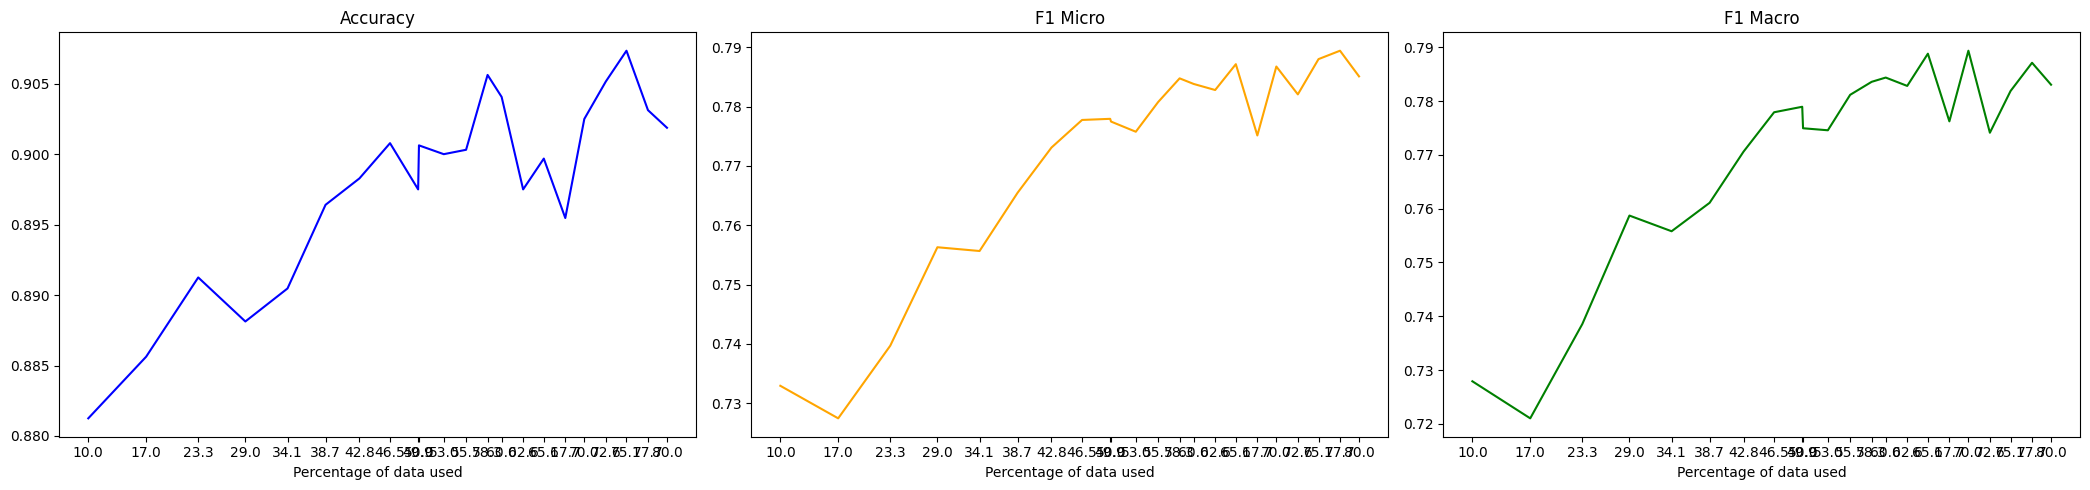

In [ ]:
initial_train_size = int(0.1 * total_data)
active_learning(50, 0, 'lc', 10)

# MONTE CARLO DROPOUT

Init size: 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6885, Accuracy: 0.7555, F1 Micro: 0.0778, F1 Macro: 0.0413
Epoch 2/10, Train Loss: 0.5719, Accuracy: 0.7855, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.5141, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.4529, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 5/10, Train Loss: 0.4945, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 6/10, Train Loss: 0.4802, Accuracy: 0.7867, F1 Micro: 0.0029, F1 Macro: 0.002
Epoch 7/10, Train Loss: 0.4452, Accuracy: 0.7878, F1 Micro: 0.0382, F1 Macro: 0.0245
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3629, Accuracy: 0.7859, F1 Micro: 0.1138, F1 Macro: 0.0642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4015, Accuracy: 0.7864, F1 Micro: 0.1343, F1 Macro: 0.0781
Epoch 10/10, Train Loss: 0.3367, Accuracy: 0.7883, F1 Micro: 0.1091, F1 Macro: 0.0697

 Iteration 77: Accuracy: 0.7864, F1 Micro: 0.1343, F1 Macro: 0.0781
      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6022, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5061, Accuracy: 0.8178, F1 Micro: 0.2564, F1 Macro: 0.1783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4384, Accuracy: 0.8472, F1 Micro: 0.5085, F1 Macro: 0.4366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3877, Accuracy: 0.8639, F1 Micro: 0.6308, F1 Macro: 0.6277
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3408, Accuracy: 0.8678, F1 Micro: 0.6357, F1 Macro: 0.6376
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2922, Accuracy: 0.8792, F1 Micro: 0.6712, F1 Macro: 0.664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2571, Accuracy: 0.8814, F1 Micro: 0.7143, F1 Macro: 0.7166
Epoch 8/10, Train Loss: 0.2175, Accuracy: 0.88, F1 Micro: 0.694, F1 Macro: 0.6925
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1687, Accuracy: 0.8836, F1 Micro: 0.7158

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5841, Accuracy: 0.7905, F1 Micro: 0.0346, F1 Macro: 0.0311
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4986, Accuracy: 0.8356, F1 Micro: 0.4858, F1 Macro: 0.3944
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4154, Accuracy: 0.8756, F1 Micro: 0.6697, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3539, Accuracy: 0.8861, F1 Micro: 0.7047, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3016, Accuracy: 0.8895, F1 Micro: 0.7292, F1 Macro: 0.723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2416, Accuracy: 0.8939, F1 Micro: 0.7441, F1 Macro: 0.7423
Epoch 7/10, Train Loss: 0.1959, Accuracy: 0.888, F1 Micro: 0.7021, F1 Macro: 0.6965
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1434, Accuracy: 0.8927, F1 Micro: 0.7512, F1 Macro: 0.7532
Epoch 9/10, Train Loss: 0.1078, Accuracy: 0.8902, F1 Micro: 0.7291, F1 Macro: 0.7291
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5688, Accuracy: 0.8111, F1 Micro: 0.2134, F1 Macro: 0.1811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4591, Accuracy: 0.8606, F1 Micro: 0.6158, F1 Macro: 0.5748
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3929, Accuracy: 0.8856, F1 Micro: 0.7152, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3138, Accuracy: 0.8956, F1 Micro: 0.7454, F1 Macro: 0.7369
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2635, Accuracy: 0.8997, F1 Micro: 0.7606, F1 Macro: 0.7604
Epoch 6/10, Train Loss: 0.203, Accuracy: 0.8986, F1 Micro: 0.747, F1 Macro: 0.7406
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1509, Accuracy: 0.9006, F1 Micro: 0.7636, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1202, Accuracy: 0.9, F1 Micro: 0.769, F1 Macro: 0.7728
Epoch 9/10, Train Loss: 0.087, Accuracy: 0.8963, F1 Micro: 0.7533, F1 Macro: 0.7425
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.556, Accuracy: 0.8344, F1 Micro: 0.4919, F1 Macro: 0.4196
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4399, Accuracy: 0.8769, F1 Micro: 0.6703, F1 Macro: 0.6492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3687, Accuracy: 0.8895, F1 Micro: 0.7501, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2988, Accuracy: 0.9003, F1 Micro: 0.7685, F1 Macro: 0.7666
Epoch 5/10, Train Loss: 0.2496, Accuracy: 0.8964, F1 Micro: 0.7607, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1887, Accuracy: 0.9009, F1 Micro: 0.7753, F1 Macro: 0.7778
Epoch 7/10, Train Loss: 0.1411, Accuracy: 0.8988, F1 Micro: 0.7728, F1 Macro: 0.7734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1136, Accuracy: 0.9061, F1 Micro: 0.7796, F1 Macro: 0.7789
Epoch 9/10, Train Loss: 0.0868, Accuracy: 0.9055, F1 Micro: 0.7765, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.0648, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5416, Accuracy: 0.8428, F1 Micro: 0.5241, F1 Macro: 0.4734
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4113, Accuracy: 0.8867, F1 Micro: 0.7368, F1 Macro: 0.733
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3441, Accuracy: 0.8986, F1 Micro: 0.7603, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.298, Accuracy: 0.8953, F1 Micro: 0.7707, F1 Macro: 0.771
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2352, Accuracy: 0.9027, F1 Micro: 0.7787, F1 Macro: 0.7769
Epoch 6/10, Train Loss: 0.1768, Accuracy: 0.9053, F1 Micro: 0.7633, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1342, Accuracy: 0.9075, F1 Micro: 0.7843, F1 Macro: 0.7867
Epoch 8/10, Train Loss: 0.1065, Accuracy: 0.9038, F1 Micro: 0.7789, F1 Macro: 0.7774
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0.9028, F1 Micro: 0.7745, F1 Macro: 0.7715
Epoch 10/10, Train Loss: 0.068, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5201, Accuracy: 0.8556, F1 Micro: 0.6121, F1 Macro: 0.5501
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3921, Accuracy: 0.8917, F1 Micro: 0.7366, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.323, Accuracy: 0.9003, F1 Micro: 0.767, F1 Macro: 0.764
Epoch 4/10, Train Loss: 0.2707, Accuracy: 0.8955, F1 Micro: 0.735, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2267, Accuracy: 0.9055, F1 Micro: 0.7752, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1762, Accuracy: 0.9028, F1 Micro: 0.7807, F1 Macro: 0.7786
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.9023, F1 Micro: 0.7756, F1 Macro: 0.7746
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.9034, F1 Micro: 0.7801, F1 Macro: 0.7794
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9039, F1 Micro: 0.7853, F1 Macro: 0.7833
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5087, Accuracy: 0.8467, F1 Micro: 0.492, F1 Macro: 0.4199
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3767, Accuracy: 0.8922, F1 Micro: 0.7529, F1 Macro: 0.7492
Epoch 3/10, Train Loss: 0.3212, Accuracy: 0.8959, F1 Micro: 0.7506, F1 Macro: 0.7385
Epoch 4/10, Train Loss: 0.2609, Accuracy: 0.8964, F1 Micro: 0.7323, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2098, Accuracy: 0.903, F1 Micro: 0.7701, F1 Macro: 0.7702
Epoch 6/10, Train Loss: 0.1618, Accuracy: 0.9033, F1 Micro: 0.7677, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1206, Accuracy: 0.905, F1 Micro: 0.7761, F1 Macro: 0.7741
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9023, F1 Micro: 0.7679, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.9064, F1 Micro: 0.7863, F1 Macro: 0.7873
Epoch 10/10, Train Loss: 0.0551, Accuracy: 0.9014, F1 Micro: 0.7705, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4923, Accuracy: 0.8648, F1 Micro: 0.6045, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3643, Accuracy: 0.8972, F1 Micro: 0.7561, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.302, Accuracy: 0.9011, F1 Micro: 0.7827, F1 Macro: 0.7792
Epoch 4/10, Train Loss: 0.2514, Accuracy: 0.9058, F1 Micro: 0.7795, F1 Macro: 0.7755
Epoch 5/10, Train Loss: 0.2007, Accuracy: 0.8978, F1 Micro: 0.7823, F1 Macro: 0.7834
Epoch 6/10, Train Loss: 0.1498, Accuracy: 0.8983, F1 Micro: 0.7745, F1 Macro: 0.7692
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.8966, F1 Micro: 0.7784, F1 Macro: 0.7806
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9031, F1 Micro: 0.7667, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9084, F1 Micro: 0.7864, F1 Macro: 0.7812
Epoch 10/10, Train Loss: 0.0558, Accuracy: 0.9058, F1 Micro: 0.7803, F1 Macro: 0.7788

 Iteration 3578: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.475, Accuracy: 0.8712, F1 Micro: 0.6667, F1 Macro: 0.6485
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3525, Accuracy: 0.8984, F1 Micro: 0.7538, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2889, Accuracy: 0.9017, F1 Micro: 0.7596, F1 Macro: 0.754
Epoch 4/10, Train Loss: 0.2339, Accuracy: 0.9005, F1 Micro: 0.7479, F1 Macro: 0.7424
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2044, Accuracy: 0.907, F1 Micro: 0.7831, F1 Macro: 0.7805
Epoch 6/10, Train Loss: 0.1434, Accuracy: 0.9009, F1 Micro: 0.7803, F1 Macro: 0.7777
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.9016, F1 Micro: 0.7771, F1 Macro: 0.774
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9023, F1 Micro: 0.7757, F1 Macro: 0.7742
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9031, F1 Micro: 0.7625, F1 Macro: 0.7552
Epoch 10/10, Train Loss: 0.0522, Accuracy: 0.9042, F1 Micro: 0.7764, F1 Macro: 0.7719

 Iteration 3842: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4812, Accuracy: 0.8745, F1 Micro: 0.7047, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3402, Accuracy: 0.8945, F1 Micro: 0.7389, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2867, Accuracy: 0.903, F1 Micro: 0.7675, F1 Macro: 0.7615
Epoch 4/10, Train Loss: 0.2504, Accuracy: 0.9039, F1 Micro: 0.7593, F1 Macro: 0.7525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2007, Accuracy: 0.9081, F1 Micro: 0.7707, F1 Macro: 0.7656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1458, Accuracy: 0.9027, F1 Micro: 0.7758, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.9033, F1 Micro: 0.7776, F1 Macro: 0.7764
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.903, F1 Micro: 0.7739, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0665, Accuracy: 0.905, F1 Micro: 0.7825, F1 Macro: 0.7828
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4814, Accuracy: 0.8795, F1 Micro: 0.6826, F1 Macro: 0.6743
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3352, Accuracy: 0.8963, F1 Micro: 0.7361, F1 Macro: 0.7284
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2905, Accuracy: 0.9003, F1 Micro: 0.758, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2369, Accuracy: 0.9031, F1 Micro: 0.7878, F1 Macro: 0.7865
Epoch 5/10, Train Loss: 0.179, Accuracy: 0.9067, F1 Micro: 0.7775, F1 Macro: 0.7725
Epoch 6/10, Train Loss: 0.143, Accuracy: 0.9066, F1 Micro: 0.7821, F1 Macro: 0.7786
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.9013, F1 Micro: 0.7746, F1 Macro: 0.7726
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9061, F1 Micro: 0.7762, F1 Macro: 0.7683
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9059, F1 Micro: 0.7767, F1 Macro: 0.7756
Epoch 10/10, Train Loss: 0.0508, Accuracy: 0.9075, F1 Micro: 0.7864, F1 Macro: 0.7834

 Iteration 4120: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4598, Accuracy: 0.8797, F1 Micro: 0.7009, F1 Macro: 0.6934
Epoch 2/10, Train Loss: 0.3309, Accuracy: 0.8878, F1 Micro: 0.69, F1 Macro: 0.6654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2709, Accuracy: 0.9009, F1 Micro: 0.7602, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2267, Accuracy: 0.9061, F1 Micro: 0.7793, F1 Macro: 0.7788
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1751, Accuracy: 0.907, F1 Micro: 0.7815, F1 Macro: 0.7754
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.9038, F1 Micro: 0.7814, F1 Macro: 0.7802
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9066, F1 Micro: 0.7827, F1 Macro: 0.7805
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.8994, F1 Micro: 0.7675, F1 Macro: 0.7632
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.9052, F1 Micro: 0.7825, F1 Macro: 0.7782
Epoch 10/10, Train Loss: 0.0508, Accuracy: 0.9061, F1 Micro: 0.7763, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4521, Accuracy: 0.8784, F1 Micro: 0.6796, F1 Macro: 0.6626
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3135, Accuracy: 0.8955, F1 Micro: 0.7336, F1 Macro: 0.7221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2736, Accuracy: 0.903, F1 Micro: 0.7677, F1 Macro: 0.7632
Epoch 4/10, Train Loss: 0.219, Accuracy: 0.9036, F1 Micro: 0.7579, F1 Macro: 0.7438
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1718, Accuracy: 0.9034, F1 Micro: 0.7738, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9047, F1 Micro: 0.7815, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.9023, F1 Micro: 0.7844, F1 Macro: 0.7835
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.9038, F1 Micro: 0.7661, F1 Macro: 0.7582
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9036, F1 Micro: 0.7791, F1 Macro: 0.7775
Epoch 10/10, Train Loss: 0.0431, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4405, Accuracy: 0.8856, F1 Micro: 0.7219, F1 Macro: 0.7102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3072, Accuracy: 0.8981, F1 Micro: 0.7605, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2549, Accuracy: 0.9023, F1 Micro: 0.7781, F1 Macro: 0.7765
Epoch 4/10, Train Loss: 0.2094, Accuracy: 0.9027, F1 Micro: 0.7683, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1632, Accuracy: 0.902, F1 Micro: 0.7856, F1 Macro: 0.7864
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9053, F1 Micro: 0.7777, F1 Macro: 0.7726
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9039, F1 Micro: 0.7835, F1 Macro: 0.7842
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.903, F1 Micro: 0.7811, F1 Macro: 0.7774
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.903, F1 Micro: 0.7754, F1 Macro: 0.7725
Epoch 10/10, Train Loss: 0.0444, Accuracy: 0.9075, F1 Micro: 0.7791, F1 Macro: 0.7733

 Iteration 4663: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4423, Accuracy: 0.8814, F1 Micro: 0.7068, F1 Macro: 0.6975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3094, Accuracy: 0.8964, F1 Micro: 0.7383, F1 Macro: 0.7286
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2508, Accuracy: 0.903, F1 Micro: 0.759, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2084, Accuracy: 0.9066, F1 Micro: 0.781, F1 Macro: 0.7788
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.905, F1 Micro: 0.7825, F1 Macro: 0.7791
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9034, F1 Micro: 0.7813, F1 Macro: 0.7788
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9031, F1 Micro: 0.7831, F1 Macro: 0.7844
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9033, F1 Micro: 0.7774, F1 Macro: 0.7768
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9045, F1 Micro: 0.7798, F1 Macro: 0.779
Epoch 10/10, Train Loss: 0.0465, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4248, Accuracy: 0.8869, F1 Micro: 0.7235, F1 Macro: 0.7162
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2852, Accuracy: 0.903, F1 Micro: 0.7738, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2347, Accuracy: 0.9059, F1 Micro: 0.783, F1 Macro: 0.7802
Epoch 4/10, Train Loss: 0.1961, Accuracy: 0.9028, F1 Micro: 0.7799, F1 Macro: 0.7789
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.903, F1 Micro: 0.7817, F1 Macro: 0.7807
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9045, F1 Micro: 0.7662, F1 Macro: 0.759
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9036, F1 Micro: 0.7676, F1 Macro: 0.7602
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.9042, F1 Micro: 0.7772, F1 Macro: 0.7731
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9034, F1 Micro: 0.7645, F1 Macro: 0.7566
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.8989, F1 Micro: 0.7688, F1 Macro: 0.7634

 Iteration 5063: Accuracy: 0.9059, F1 Micro: 0.783, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4177, Accuracy: 0.8883, F1 Micro: 0.7243, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.272, Accuracy: 0.8975, F1 Micro: 0.7455, F1 Macro: 0.7371
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2274, Accuracy: 0.905, F1 Micro: 0.7753, F1 Macro: 0.7657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1912, Accuracy: 0.8986, F1 Micro: 0.7818, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9044, F1 Micro: 0.7824, F1 Macro: 0.7808
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9003, F1 Micro: 0.7721, F1 Macro: 0.7683
Epoch 7/10, Train Loss: 0.0829, Accuracy: 0.9033, F1 Micro: 0.7748, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9022, F1 Micro: 0.7855, F1 Macro: 0.7858
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9059, F1 Micro: 0.7812, F1 Macro: 0.7767
Epoch 10/10, Train Loss: 0.0379, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4031, Accuracy: 0.8877, F1 Micro: 0.744, F1 Macro: 0.7429
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.8938, F1 Micro: 0.7176, F1 Macro: 0.6953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2262, Accuracy: 0.9053, F1 Micro: 0.778, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1838, Accuracy: 0.9058, F1 Micro: 0.7841, F1 Macro: 0.7785
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9039, F1 Micro: 0.7774, F1 Macro: 0.7677
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9006, F1 Micro: 0.7819, F1 Macro: 0.7811
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9017, F1 Micro: 0.7733, F1 Macro: 0.7679
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9083, F1 Micro: 0.7738, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9055, F1 Micro: 0.7743, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0369, Accuracy: 0.9066, F1 Micro: 0.7876, F1 Macro: 0.7857

 Iteration 5441: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3926, Accuracy: 0.8866, F1 Micro: 0.7233, F1 Macro: 0.7095
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.9005, F1 Micro: 0.757, F1 Macro: 0.7495
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.9078, F1 Micro: 0.7767, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.172, Accuracy: 0.9059, F1 Micro: 0.7825, F1 Macro: 0.7748
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.905, F1 Micro: 0.7625, F1 Macro: 0.7521
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9017, F1 Micro: 0.7817, F1 Macro: 0.7807
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9064, F1 Micro: 0.7832, F1 Macro: 0.781
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9028, F1 Micro: 0.775, F1 Macro: 0.7735
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9013, F1 Micro: 0.7738, F1 Macro: 0.7691
Epoch 10/10, Train Loss: 0.0369, Accuracy: 0.9036, F1 Micro: 0.777, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3808, Accuracy: 0.8834, F1 Micro: 0.7075, F1 Macro: 0.7052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2558, Accuracy: 0.9006, F1 Micro: 0.7552, F1 Macro: 0.7359
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.9031, F1 Micro: 0.7847, F1 Macro: 0.7828
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9059, F1 Micro: 0.7816, F1 Macro: 0.7733
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9062, F1 Micro: 0.7766, F1 Macro: 0.7692
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9056, F1 Micro: 0.7796, F1 Macro: 0.7754
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9048, F1 Micro: 0.7639, F1 Macro: 0.757
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.9025, F1 Micro: 0.7703, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9077, F1 Micro: 0.787, F1 Macro: 0.7852
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.9056, F1 Micro: 0.7771, F1 Macro: 0.7719

 Iteration 5841: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8806, F1 Micro: 0.7424, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.8975, F1 Micro: 0.7517, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2038, Accuracy: 0.9028, F1 Micro: 0.7642, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9058, F1 Micro: 0.7852, F1 Macro: 0.7824
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9077, F1 Micro: 0.7749, F1 Macro: 0.771
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9041, F1 Micro: 0.7838, F1 Macro: 0.7832
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9062, F1 Micro: 0.7741, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9059, F1 Micro: 0.787, F1 Macro: 0.7848
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.902, F1 Micro: 0.7763, F1 Macro: 0.7751
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.9048, F1 Micro: 0.7762, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3611, Accuracy: 0.8884, F1 Micro: 0.7459, F1 Macro: 0.7438
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2377, Accuracy: 0.9014, F1 Micro: 0.772, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.9022, F1 Micro: 0.7775, F1 Macro: 0.7699
Epoch 4/10, Train Loss: 0.1515, Accuracy: 0.9019, F1 Micro: 0.7688, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9045, F1 Micro: 0.7833, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.9031, F1 Micro: 0.7843, F1 Macro: 0.7831
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9038, F1 Micro: 0.7779, F1 Macro: 0.7747
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9045, F1 Micro: 0.7746, F1 Macro: 0.7698
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9052, F1 Micro: 0.7828, F1 Macro: 0.7805
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0302, Accura

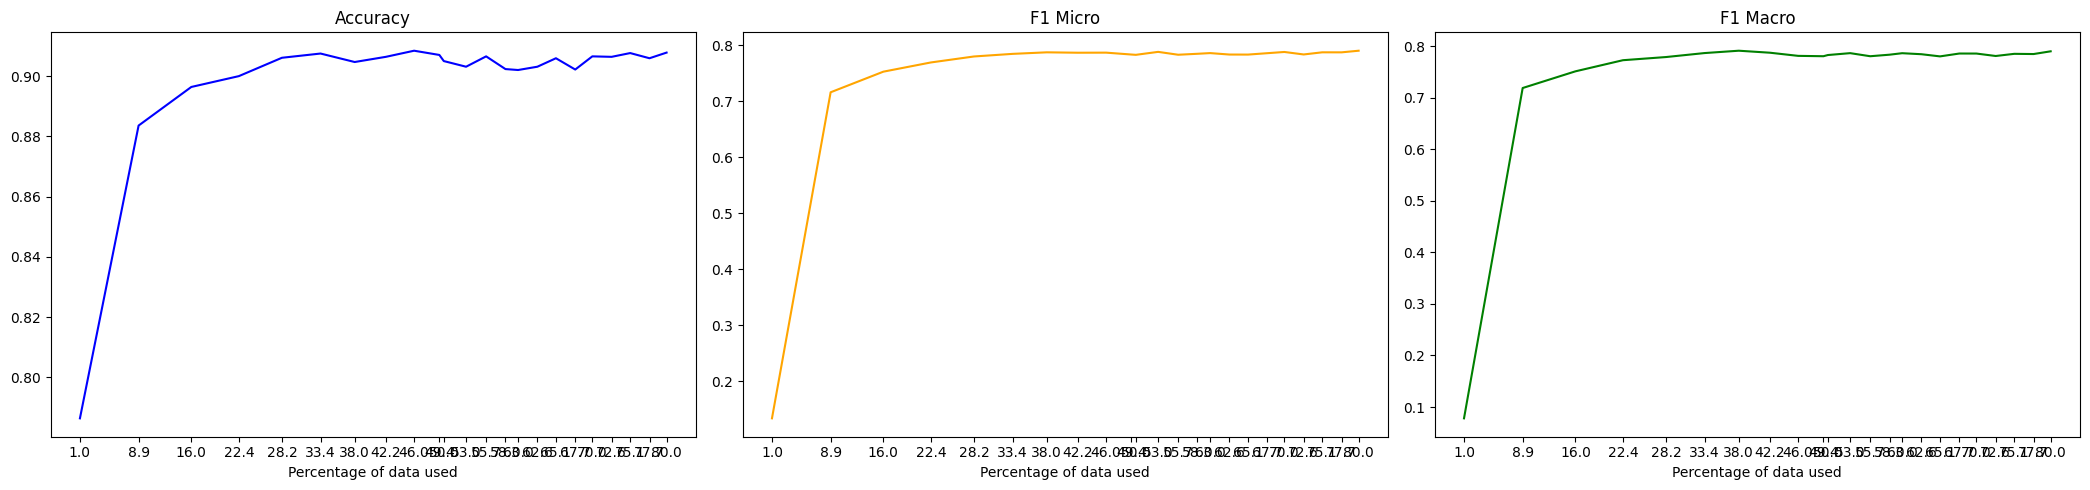

In [24]:
initial_train_size = int(0.01 * total_data)
active_learning(50, 0, 'mc', 1)

Init size: 10
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5424, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4401, Accuracy: 0.8241, F1 Micro: 0.3117, F1 Macro: 0.2115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3843, Accuracy: 0.8481, F1 Micro: 0.5106, F1 Macro: 0.4401
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3098, Accuracy: 0.867, F1 Micro: 0.6282, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2726, Accuracy: 0.877, F1 Micro: 0.6974, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2296, Accuracy: 0.8792, F1 Micro: 0.7194, F1 Macro: 0.7138
Epoch 7/10, Train Loss: 0.1744, Accuracy: 0.8816, F1 Micro: 0.7073, F1 Macro: 0.6952
Epoch 8/10, Train Loss: 0.1438, Accuracy: 0.8809, F1 Micro: 0.7176, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1025, Accuracy: 0.8813, F1 Micro: 0.733, F1 Macro: 0.7279
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5587, Accuracy: 0.7933, F1 Micro: 0.0597, F1 Macro: 0.0519
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.451, Accuracy: 0.8531, F1 Micro: 0.5369, F1 Macro: 0.4977
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3759, Accuracy: 0.8797, F1 Micro: 0.689, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3136, Accuracy: 0.8856, F1 Micro: 0.6955, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2577, Accuracy: 0.8913, F1 Micro: 0.7251, F1 Macro: 0.7241
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2125, Accuracy: 0.8919, F1 Micro: 0.7493, F1 Macro: 0.7418
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1591, Accuracy: 0.8944, F1 Micro: 0.7513, F1 Macro: 0.7484
Epoch 8/10, Train Loss: 0.1271, Accuracy: 0.8913, F1 Micro: 0.7391, F1 Macro: 0.7313
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1021, Accuracy: 0.8953, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5423, Accuracy: 0.8064, F1 Micro: 0.1701, F1 Macro: 0.1316
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4501, Accuracy: 0.8591, F1 Micro: 0.5805, F1 Macro: 0.5537
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3674, Accuracy: 0.8859, F1 Micro: 0.7153, F1 Macro: 0.7065
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3037, Accuracy: 0.8936, F1 Micro: 0.7418, F1 Macro: 0.7316
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2273, Accuracy: 0.8972, F1 Micro: 0.7581, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1861, Accuracy: 0.8925, F1 Micro: 0.7647, F1 Macro: 0.7632
Epoch 7/10, Train Loss: 0.164, Accuracy: 0.8942, F1 Micro: 0.7269, F1 Macro: 0.7202
Epoch 8/10, Train Loss: 0.1104, Accuracy: 0.8967, F1 Micro: 0.7419, F1 Macro: 0.7361
Epoch 9/10, Train Loss: 0.0828, Accuracy: 0.8986, F1 Micro: 0.7552, F1 Macro: 0.7497
Epoch 10/10, Train Loss: 0.073, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5331, Accuracy: 0.8364, F1 Micro: 0.4337, F1 Macro: 0.3759
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4237, Accuracy: 0.8736, F1 Micro: 0.6565, F1 Macro: 0.6391
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3482, Accuracy: 0.892, F1 Micro: 0.737, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2885, Accuracy: 0.9019, F1 Micro: 0.7664, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2199, Accuracy: 0.9016, F1 Micro: 0.7714, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1661, Accuracy: 0.905, F1 Micro: 0.7716, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.131, Accuracy: 0.902, F1 Micro: 0.7763, F1 Macro: 0.7718
Epoch 8/10, Train Loss: 0.1014, Accuracy: 0.898, F1 Micro: 0.7575, F1 Macro: 0.7506
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9017, F1 Micro: 0.769, F1 Macro: 0.7615
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5154, Accuracy: 0.8414, F1 Micro: 0.4672, F1 Macro: 0.4082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3949, Accuracy: 0.8864, F1 Micro: 0.735, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3303, Accuracy: 0.8963, F1 Micro: 0.7568, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2636, Accuracy: 0.9008, F1 Micro: 0.7617, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2167, Accuracy: 0.9027, F1 Micro: 0.7661, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1556, Accuracy: 0.9002, F1 Micro: 0.7719, F1 Macro: 0.7705
Epoch 7/10, Train Loss: 0.1266, Accuracy: 0.8952, F1 Micro: 0.7692, F1 Macro: 0.7738
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.9019, F1 Micro: 0.7703, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9005, F1 Micro: 0.7696, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5089, Accuracy: 0.8537, F1 Micro: 0.5821, F1 Macro: 0.502
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3917, Accuracy: 0.8842, F1 Micro: 0.7077, F1 Macro: 0.701
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3317, Accuracy: 0.8959, F1 Micro: 0.7642, F1 Macro: 0.7595
Epoch 4/10, Train Loss: 0.2718, Accuracy: 0.8975, F1 Micro: 0.753, F1 Macro: 0.7382
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2276, Accuracy: 0.8963, F1 Micro: 0.7795, F1 Macro: 0.7818
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1789, Accuracy: 0.9064, F1 Micro: 0.78, F1 Macro: 0.7695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1279, Accuracy: 0.9044, F1 Micro: 0.7845, F1 Macro: 0.78
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9031, F1 Micro: 0.7757, F1 Macro: 0.7707
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9045, F1 Micro: 0.7779, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.0572, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4993, Accuracy: 0.8672, F1 Micro: 0.6361, F1 Macro: 0.636
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.374, Accuracy: 0.8873, F1 Micro: 0.7468, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3153, Accuracy: 0.9, F1 Micro: 0.749, F1 Macro: 0.7373
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2495, Accuracy: 0.9034, F1 Micro: 0.7701, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1924, Accuracy: 0.9025, F1 Micro: 0.7734, F1 Macro: 0.7649
Epoch 6/10, Train Loss: 0.1483, Accuracy: 0.9047, F1 Micro: 0.7639, F1 Macro: 0.7542
Epoch 7/10, Train Loss: 0.1164, Accuracy: 0.9027, F1 Micro: 0.7673, F1 Macro: 0.7633
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9044, F1 Micro: 0.7689, F1 Macro: 0.7585
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9034, F1 Micro: 0.7703, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.056, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.485, Accuracy: 0.8559, F1 Micro: 0.5472, F1 Macro: 0.4822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3643, Accuracy: 0.895, F1 Micro: 0.7675, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3022, Accuracy: 0.8998, F1 Micro: 0.7749, F1 Macro: 0.777
Epoch 4/10, Train Loss: 0.244, Accuracy: 0.9036, F1 Micro: 0.7705, F1 Macro: 0.7607
Epoch 5/10, Train Loss: 0.1973, Accuracy: 0.9036, F1 Micro: 0.7591, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.908, F1 Micro: 0.7787, F1 Macro: 0.7751
Epoch 7/10, Train Loss: 0.119, Accuracy: 0.9044, F1 Micro: 0.772, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9055, F1 Micro: 0.7777, F1 Macro: 0.7746
Epoch 9/10, Train Loss: 0.0666, Accuracy: 0.9042, F1 Micro: 0.7695, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0611, Accuracy: 0.9081, F1 Micro: 0.7825, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4807, Accuracy: 0.8731, F1 Micro: 0.6463, F1 Macro: 0.6129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3482, Accuracy: 0.8969, F1 Micro: 0.749, F1 Macro: 0.743
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2901, Accuracy: 0.8995, F1 Micro: 0.7505, F1 Macro: 0.7426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2399, Accuracy: 0.9033, F1 Micro: 0.7865, F1 Macro: 0.7838
Epoch 5/10, Train Loss: 0.1875, Accuracy: 0.9025, F1 Micro: 0.7832, F1 Macro: 0.7807
Epoch 6/10, Train Loss: 0.1428, Accuracy: 0.9028, F1 Micro: 0.7631, F1 Macro: 0.7588
Epoch 7/10, Train Loss: 0.1105, Accuracy: 0.9038, F1 Micro: 0.7625, F1 Macro: 0.7567
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9064, F1 Micro: 0.779, F1 Macro: 0.7725
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.9042, F1 Micro: 0.7752, F1 Macro: 0.7679
Epoch 10/10, Train Loss: 0.0546, Accuracy: 0.9044, F1 Micro: 0.7803, F1 Macro: 0.7794

 Iteration 3878: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.479, Accuracy: 0.8784, F1 Micro: 0.7075, F1 Macro: 0.6966
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3454, Accuracy: 0.8984, F1 Micro: 0.7669, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2874, Accuracy: 0.9022, F1 Micro: 0.7774, F1 Macro: 0.7751
Epoch 4/10, Train Loss: 0.2328, Accuracy: 0.9031, F1 Micro: 0.777, F1 Macro: 0.7756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1844, Accuracy: 0.9048, F1 Micro: 0.7799, F1 Macro: 0.7763
Epoch 6/10, Train Loss: 0.1434, Accuracy: 0.903, F1 Micro: 0.7744, F1 Macro: 0.7684
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9047, F1 Micro: 0.7714, F1 Macro: 0.7679
Epoch 8/10, Train Loss: 0.0912, Accuracy: 0.9031, F1 Micro: 0.7742, F1 Macro: 0.7728
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9036, F1 Micro: 0.7697, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.051, Accuracy: 0.9042, F1 Micro: 0.7786, F1 Macro: 0.7756

 Iteration 3886: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4739, Accuracy: 0.8723, F1 Micro: 0.7209, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3373, Accuracy: 0.8959, F1 Micro: 0.7544, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2898, Accuracy: 0.9038, F1 Micro: 0.7734, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2475, Accuracy: 0.9013, F1 Micro: 0.7861, F1 Macro: 0.7867
Epoch 5/10, Train Loss: 0.1855, Accuracy: 0.9039, F1 Micro: 0.7645, F1 Macro: 0.7529
Epoch 6/10, Train Loss: 0.1424, Accuracy: 0.9066, F1 Micro: 0.7795, F1 Macro: 0.7744
Epoch 7/10, Train Loss: 0.1037, Accuracy: 0.9087, F1 Micro: 0.7819, F1 Macro: 0.7782
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9017, F1 Micro: 0.7769, F1 Macro: 0.775
Epoch 9/10, Train Loss: 0.0613, Accuracy: 0.9052, F1 Micro: 0.7733, F1 Macro: 0.771
Epoch 10/10, Train Loss: 0.05, Accuracy: 0.9014, F1 Micro: 0.7773, F1 Macro: 0.7775

 Iteration 4120: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4564, Accuracy: 0.8781, F1 Micro: 0.6944, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3254, Accuracy: 0.9, F1 Micro: 0.7654, F1 Macro: 0.7593
Epoch 3/10, Train Loss: 0.2622, Accuracy: 0.9011, F1 Micro: 0.7592, F1 Macro: 0.7521
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2251, Accuracy: 0.9061, F1 Micro: 0.7809, F1 Macro: 0.7759
Epoch 5/10, Train Loss: 0.1739, Accuracy: 0.9058, F1 Micro: 0.7682, F1 Macro: 0.7541
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.9028, F1 Micro: 0.7785, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.8988, F1 Micro: 0.7811, F1 Macro: 0.7808
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9045, F1 Micro: 0.7766, F1 Macro: 0.7696
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.905, F1 Micro: 0.7743, F1 Macro: 0.7679
Epoch 10/10, Train Loss: 0.047, Accuracy: 0.9025, F1 Micro: 0.7744, F1 Macro: 0.7691

 Iteration 4330: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.448, Accuracy: 0.8814, F1 Micro: 0.6862, F1 Macro: 0.676
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3234, Accuracy: 0.8961, F1 Micro: 0.7391, F1 Macro: 0.7275
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2564, Accuracy: 0.9038, F1 Micro: 0.7794, F1 Macro: 0.777
Epoch 4/10, Train Loss: 0.2181, Accuracy: 0.907, F1 Micro: 0.7767, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.9047, F1 Micro: 0.7885, F1 Macro: 0.7882
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9022, F1 Micro: 0.7782, F1 Macro: 0.7771
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9064, F1 Micro: 0.7843, F1 Macro: 0.7799
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.903, F1 Micro: 0.7757, F1 Macro: 0.771
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9041, F1 Micro: 0.7824, F1 Macro: 0.7797
Epoch 10/10, Train Loss: 0.0462, Accuracy: 0.9014, F1 Micro: 0.7796, F1 Macro: 0.7768

 Iteration 4530: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4361, Accuracy: 0.8852, F1 Micro: 0.7213, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3049, Accuracy: 0.8966, F1 Micro: 0.757, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2559, Accuracy: 0.9041, F1 Micro: 0.7615, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2071, Accuracy: 0.9034, F1 Micro: 0.7632, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1656, Accuracy: 0.9031, F1 Micro: 0.7868, F1 Macro: 0.785
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9014, F1 Micro: 0.7776, F1 Macro: 0.7748
Epoch 7/10, Train Loss: 0.0942, Accuracy: 0.9055, F1 Micro: 0.7786, F1 Macro: 0.7732
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9053, F1 Micro: 0.7759, F1 Macro: 0.7724
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9066, F1 Micro: 0.7757, F1 Macro: 0.7717
Epoch 10/10, Train Loss: 0.0418, Accuracy: 0.9044, F1 Micro: 0.7859, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.441, Accuracy: 0.8803, F1 Micro: 0.7133, F1 Macro: 0.7153
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3078, Accuracy: 0.9023, F1 Micro: 0.7738, F1 Macro: 0.7689
Epoch 3/10, Train Loss: 0.2536, Accuracy: 0.9014, F1 Micro: 0.7585, F1 Macro: 0.7444
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2104, Accuracy: 0.9069, F1 Micro: 0.7818, F1 Macro: 0.7716
Epoch 5/10, Train Loss: 0.1676, Accuracy: 0.9033, F1 Micro: 0.7727, F1 Macro: 0.7619
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.9047, F1 Micro: 0.7693, F1 Macro: 0.7666
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.9008, F1 Micro: 0.7608, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9042, F1 Micro: 0.7822, F1 Macro: 0.779
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9053, F1 Micro: 0.7725, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0464, Accuracy: 0.9036, F1 Micro: 0.7891, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4224, Accuracy: 0.8831, F1 Micro: 0.687, F1 Macro: 0.6728
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2897, Accuracy: 0.9002, F1 Micro: 0.7491, F1 Macro: 0.7332
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2397, Accuracy: 0.9008, F1 Micro: 0.7666, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1929, Accuracy: 0.9014, F1 Micro: 0.7849, F1 Macro: 0.7837
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9067, F1 Micro: 0.7833, F1 Macro: 0.78
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.9048, F1 Micro: 0.7794, F1 Macro: 0.7771
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9019, F1 Micro: 0.7716, F1 Macro: 0.7666
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.905, F1 Micro: 0.7756, F1 Macro: 0.77
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9005, F1 Micro: 0.7716, F1 Macro: 0.7689
Epoch 10/10, Train Loss: 0.0413, Accuracy: 0.9014, F1 Micro: 0.7781, F1 Macro: 0.7782

 Iteration 5063: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4099, Accuracy: 0.8884, F1 Micro: 0.7407, F1 Macro: 0.7351
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2759, Accuracy: 0.9002, F1 Micro: 0.7777, F1 Macro: 0.774
Epoch 3/10, Train Loss: 0.2327, Accuracy: 0.902, F1 Micro: 0.7591, F1 Macro: 0.7558
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9048, F1 Micro: 0.7762, F1 Macro: 0.7692
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.9041, F1 Micro: 0.7704, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.8998, F1 Micro: 0.7855, F1 Macro: 0.7859
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9041, F1 Micro: 0.7847, F1 Macro: 0.7852
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.9036, F1 Micro: 0.7767, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9009, F1 Micro: 0.778, F1 Macro: 0.776
Epoch 10/10, Train Loss: 0.0371, Accuracy: 0.9069, F1 Micro: 0.7718, F1 Macro: 0.7667

 Iteration 5263: Accuracy: 0.8998, F1 Micro: 0.7855, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.401, Accuracy: 0.8866, F1 Micro: 0.7235, F1 Macro: 0.7151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2682, Accuracy: 0.9, F1 Micro: 0.7729, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2258, Accuracy: 0.8989, F1 Micro: 0.7809, F1 Macro: 0.782
Epoch 4/10, Train Loss: 0.1859, Accuracy: 0.902, F1 Micro: 0.7709, F1 Macro: 0.7662
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9066, F1 Micro: 0.7731, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9086, F1 Micro: 0.7874, F1 Macro: 0.7855
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.9044, F1 Micro: 0.7617, F1 Macro: 0.7545
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9052, F1 Micro: 0.7768, F1 Macro: 0.7658
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9, F1 Micro: 0.7775, F1 Macro: 0.7756
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.8995, F1 Micro: 0.7773, F1 Macro: 0.7772

 Iteration 5441: Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3949, Accuracy: 0.8844, F1 Micro: 0.6937, F1 Macro: 0.6708
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2563, Accuracy: 0.8998, F1 Micro: 0.7634, F1 Macro: 0.7555
Epoch 3/10, Train Loss: 0.213, Accuracy: 0.9034, F1 Micro: 0.7601, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.908, F1 Micro: 0.7915, F1 Macro: 0.7896
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9042, F1 Micro: 0.7739, F1 Macro: 0.7659
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9073, F1 Micro: 0.7901, F1 Macro: 0.7878
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9011, F1 Micro: 0.7845, F1 Macro: 0.7853
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9048, F1 Micro: 0.7613, F1 Macro: 0.7568
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.907, F1 Micro: 0.7854, F1 Macro: 0.783
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.9047, F1 Micro: 0.7826, F1 Macro: 0.7825

 Iteration 5641: Accuracy: 0.908, F1 Micro: 0.7915, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3772, Accuracy: 0.8883, F1 Micro: 0.7182, F1 Macro: 0.7068
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.8914, F1 Micro: 0.7702, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2046, Accuracy: 0.9052, F1 Micro: 0.7736, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9056, F1 Micro: 0.7832, F1 Macro: 0.7807
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.8994, F1 Micro: 0.7842, F1 Macro: 0.785
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9014, F1 Micro: 0.7666, F1 Macro: 0.7604
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.8953, F1 Micro: 0.7727, F1 Macro: 0.7723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9061, F1 Micro: 0.7895, F1 Macro: 0.7898
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.9042, F1 Micro: 0.7805, F1 Macro: 0.7783
Epoch 10/10, Train Loss: 0.0336, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3751, Accuracy: 0.8806, F1 Micro: 0.6846, F1 Macro: 0.6854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2451, Accuracy: 0.9016, F1 Micro: 0.7803, F1 Macro: 0.7716
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1986, Accuracy: 0.903, F1 Micro: 0.791, F1 Macro: 0.7893
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9055, F1 Micro: 0.7768, F1 Macro: 0.7682
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9027, F1 Micro: 0.7802, F1 Macro: 0.7757
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.903, F1 Micro: 0.7826, F1 Macro: 0.7778
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9048, F1 Micro: 0.7678, F1 Macro: 0.7567
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9034, F1 Micro: 0.7832, F1 Macro: 0.7806
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9042, F1 Micro: 0.7663, F1 Macro: 0.7572
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9031, F1 Micro: 0.7784, F1 Macro: 0.7689

 Iteration 6041: Accuracy: 0.903, F1 Micro: 0.791, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3603, Accuracy: 0.8817, F1 Micro: 0.678, F1 Macro: 0.6743
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2275, Accuracy: 0.897, F1 Micro: 0.7632, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9067, F1 Micro: 0.7838, F1 Macro: 0.7776
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.9028, F1 Micro: 0.7761, F1 Macro: 0.7713
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9038, F1 Micro: 0.7766, F1 Macro: 0.773
Epoch 6/10, Train Loss: 0.0812, Accuracy: 0.905, F1 Micro: 0.7753, F1 Macro: 0.7677
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9011, F1 Micro: 0.7725, F1 Macro: 0.7692
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9042, F1 Micro: 0.778, F1 Macro: 0.7729
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9047, F1 Micro: 0.778, F1 Macro: 0.7748
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9027, F1 Micro: 0.7596, F1 Macro: 0.7526

 Iteration 6218: Accuracy: 0.9067, F1 Micro: 0.7838, F1

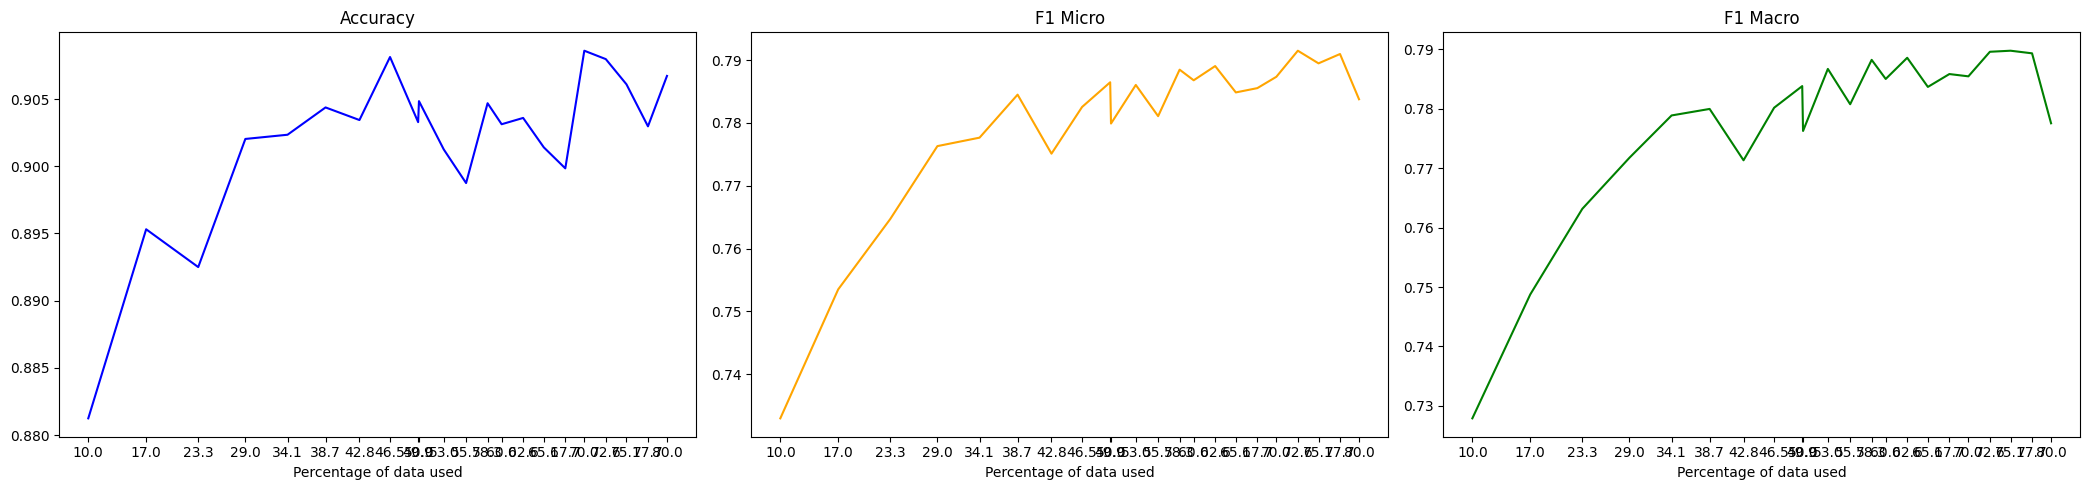

In [25]:
initial_train_size = int(0.1 * total_data)
active_learning(50, 0, 'mc', 10)

# KMEANS

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6885, Accuracy: 0.7555, F1 Micro: 0.0778, F1 Macro: 0.0413
Epoch 2/10, Train Loss: 0.5719, Accuracy: 0.7855, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.5141, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.4529, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 5/10, Train Loss: 0.4945, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 6/10, Train Loss: 0.4802, Accuracy: 0.7867, F1 Micro: 0.0029, F1 Macro: 0.002
Epoch 7/10, Train Loss: 0.4452, Accuracy: 0.7878, F1 Micro: 0.0382, F1 Macro: 0.0245
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3629, Accuracy: 0.7859, F1 Micro: 0.1138, F1 Macro: 0.0642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4015, Accuracy: 0.7864, F1 Micro: 0.1343, F1 Macro: 0.0781
Epoch 10/10, Train Loss: 0.3367, Accuracy: 0.7883, F1 Micro: 0.1091, F1 Macro: 0.0697

 Iteration 77: Accuracy: 0.7864, F1 Micro: 0.1343, F1 Macro: 0.0781
      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5188, Accuracy: 0.8031, F1 Micro: 0.1429, F1 Macro: 0.1105
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3831, Accuracy: 0.8228, F1 Micro: 0.2965, F1 Macro: 0.2103
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3308, Accuracy: 0.8339, F1 Micro: 0.3936, F1 Macro: 0.2609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2897, Accuracy: 0.8428, F1 Micro: 0.4556, F1 Macro: 0.3169
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2392, Accuracy: 0.8605, F1 Micro: 0.5671, F1 Macro: 0.5182
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2127, Accuracy: 0.8684, F1 Micro: 0.631, F1 Macro: 0.5672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1602, Accuracy: 0.875, F1 Micro: 0.701, F1 Macro: 0.687
Epoch 8/10, Train Loss: 0.132, Accuracy: 0.8703, F1 Micro: 0.6193, F1 Macro: 0.5884
Epoch 9/10, Train Loss: 0.1085, Accuracy: 0.8758, F1 Micro: 0.6653, F1 Macro: 0.6385
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4836, Accuracy: 0.8177, F1 Micro: 0.2543, F1 Macro: 0.1868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3288, Accuracy: 0.8361, F1 Micro: 0.4016, F1 Macro: 0.2699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2837, Accuracy: 0.8662, F1 Micro: 0.5985, F1 Macro: 0.5714
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2097, Accuracy: 0.8775, F1 Micro: 0.6886, F1 Macro: 0.6777
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.8775, F1 Micro: 0.7135, F1 Macro: 0.709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.8845, F1 Micro: 0.7165, F1 Macro: 0.7049
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.8853, F1 Micro: 0.7299, F1 Macro: 0.7256
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.8825, F1 Micro: 0.6773, F1 Macro: 0.6615
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.885, F1 Micro: 0.7178, F1 Macro: 0.7092
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4726, Accuracy: 0.8295, F1 Micro: 0.344, F1 Macro: 0.2348
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3262, Accuracy: 0.8673, F1 Micro: 0.6258, F1 Macro: 0.5533
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2414, Accuracy: 0.8816, F1 Micro: 0.7107, F1 Macro: 0.695
Epoch 4/10, Train Loss: 0.201, Accuracy: 0.8869, F1 Micro: 0.7055, F1 Macro: 0.6953
Epoch 5/10, Train Loss: 0.1545, Accuracy: 0.8888, F1 Micro: 0.708, F1 Macro: 0.6902
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.8881, F1 Micro: 0.7192, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.8898, F1 Micro: 0.7448, F1 Macro: 0.7432
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.8914, F1 Micro: 0.7303, F1 Macro: 0.7181
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.8919, F1 Micro: 0.7443, F1 Macro: 0.743
Epoch 10/10, Train Loss: 0.0467, Accuracy: 0.8858, F1 Micro: 0.7159, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4559, Accuracy: 0.8344, F1 Micro: 0.3808, F1 Macro: 0.2503
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3079, Accuracy: 0.8741, F1 Micro: 0.6708, F1 Macro: 0.6674
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2466, Accuracy: 0.8856, F1 Micro: 0.7248, F1 Macro: 0.7202
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.8934, F1 Micro: 0.7426, F1 Macro: 0.7377
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.8922, F1 Micro: 0.7459, F1 Macro: 0.7366
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.8933, F1 Micro: 0.7289, F1 Macro: 0.7128
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.888, F1 Micro: 0.7489, F1 Macro: 0.7503
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.8911, F1 Micro: 0.7377, F1 Macro: 0.7331
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.8944, F1 Micro: 0.7464, F1 Macro: 0.7419
Epoch 10/10, Train Loss: 0.0464, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4588, Accuracy: 0.8494, F1 Micro: 0.5087, F1 Macro: 0.3691
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2947, Accuracy: 0.872, F1 Micro: 0.6265, F1 Macro: 0.5884
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2318, Accuracy: 0.8908, F1 Micro: 0.7198, F1 Macro: 0.6984
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.8955, F1 Micro: 0.7361, F1 Macro: 0.7196
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.8956, F1 Micro: 0.7251, F1 Macro: 0.718
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.8902, F1 Micro: 0.7027, F1 Macro: 0.685
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.8931, F1 Micro: 0.7262, F1 Macro: 0.7178
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.8969, F1 Micro: 0.7653, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.8995, F1 Micro: 0.7686, F1 Macro: 0.7623
Epoch 10/10, Train Loss: 0.0427, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4406, Accuracy: 0.8419, F1 Micro: 0.4446, F1 Macro: 0.3176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2743, Accuracy: 0.8864, F1 Micro: 0.7439, F1 Macro: 0.7394
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.8922, F1 Micro: 0.733, F1 Macro: 0.7165
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1603, Accuracy: 0.8995, F1 Micro: 0.755, F1 Macro: 0.7441
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.8986, F1 Micro: 0.7464, F1 Macro: 0.7416
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.8973, F1 Micro: 0.7653, F1 Macro: 0.7645
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.8928, F1 Micro: 0.7532, F1 Macro: 0.7536
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.8973, F1 Micro: 0.7491, F1 Macro: 0.7452
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.8972, F1 Micro: 0.7619, F1 Macro: 0.7629
Epoch 10/10, Train Loss: 0.0382, Accuracy: 0.8981, F1 Micro: 0.7648, F1 Macro: 0.7635

 Iteration 2957: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4282, Accuracy: 0.8661, F1 Micro: 0.6134, F1 Macro: 0.555
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2712, Accuracy: 0.8909, F1 Micro: 0.7405, F1 Macro: 0.7333
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.8975, F1 Micro: 0.7618, F1 Macro: 0.7575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.8998, F1 Micro: 0.7697, F1 Macro: 0.767
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.8992, F1 Micro: 0.7499, F1 Macro: 0.7396
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.9011, F1 Micro: 0.7724, F1 Macro: 0.7694
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.8984, F1 Micro: 0.7578, F1 Macro: 0.7492
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9014, F1 Micro: 0.7691, F1 Macro: 0.7667
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.8992, F1 Micro: 0.7554, F1 Macro: 0.749
Epoch 10/10, Train Loss: 0.039, Accuracy: 0.898, F1 Micro: 0.7657, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4243, Accuracy: 0.8677, F1 Micro: 0.6186, F1 Macro: 0.5676
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.8905, F1 Micro: 0.737, F1 Macro: 0.7246
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.8966, F1 Micro: 0.7573, F1 Macro: 0.7518
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.8931, F1 Micro: 0.7094, F1 Macro: 0.6964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.8997, F1 Micro: 0.7622, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9045, F1 Micro: 0.7809, F1 Macro: 0.778
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9014, F1 Micro: 0.772, F1 Macro: 0.7713
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9027, F1 Micro: 0.7655, F1 Macro: 0.7603
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9031, F1 Micro: 0.7724, F1 Macro: 0.7618
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.9019, F1 Micro: 0.7781, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4141, Accuracy: 0.8623, F1 Micro: 0.5803, F1 Macro: 0.5512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2643, Accuracy: 0.8944, F1 Micro: 0.7538, F1 Macro: 0.7468
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.8927, F1 Micro: 0.7127, F1 Macro: 0.6916
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9027, F1 Micro: 0.7597, F1 Macro: 0.7538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9047, F1 Micro: 0.7835, F1 Macro: 0.7771
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.9034, F1 Micro: 0.7787, F1 Macro: 0.7753
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9044, F1 Micro: 0.7786, F1 Macro: 0.7759
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.8977, F1 Micro: 0.7555, F1 Macro: 0.7484
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.9042, F1 Micro: 0.7749, F1 Macro: 0.7721
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9034, F1 Micro: 0.7791, F1 Macro: 0.7778

 Iteration 3842:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4174, Accuracy: 0.8725, F1 Micro: 0.662, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2671, Accuracy: 0.8911, F1 Micro: 0.7166, F1 Macro: 0.6963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.218, Accuracy: 0.9017, F1 Micro: 0.7604, F1 Macro: 0.7483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9023, F1 Micro: 0.7705, F1 Macro: 0.7662
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.8992, F1 Micro: 0.7503, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9013, F1 Micro: 0.7807, F1 Macro: 0.7788
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9034, F1 Micro: 0.7787, F1 Macro: 0.7779
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.8989, F1 Micro: 0.7805, F1 Macro: 0.7802
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.9013, F1 Micro: 0.7663, F1 Macro: 0.7643
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.9036, F1 Micro: 0.7695, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4113, Accuracy: 0.8728, F1 Micro: 0.6568, F1 Macro: 0.6408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.8958, F1 Micro: 0.7531, F1 Macro: 0.7488
Epoch 3/10, Train Loss: 0.2088, Accuracy: 0.8906, F1 Micro: 0.698, F1 Macro: 0.6826
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.905, F1 Micro: 0.7783, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9014, F1 Micro: 0.7798, F1 Macro: 0.7818
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.902, F1 Micro: 0.7858, F1 Macro: 0.7863
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9011, F1 Micro: 0.7669, F1 Macro: 0.7595
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.9041, F1 Micro: 0.7759, F1 Macro: 0.7718
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9027, F1 Micro: 0.7714, F1 Macro: 0.767
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.8997, F1 Micro: 0.7752, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3997, Accuracy: 0.8737, F1 Micro: 0.6437, F1 Macro: 0.6313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2598, Accuracy: 0.8975, F1 Micro: 0.7581, F1 Macro: 0.7498
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.9022, F1 Micro: 0.7562, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.9025, F1 Micro: 0.7754, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.9056, F1 Micro: 0.7824, F1 Macro: 0.7755
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9022, F1 Micro: 0.7807, F1 Macro: 0.7824
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9058, F1 Micro: 0.7811, F1 Macro: 0.7785
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9027, F1 Micro: 0.7833, F1 Macro: 0.783
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9038, F1 Micro: 0.7816, F1 Macro: 0.7801
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9036, F1 Micro: 0.7828, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4025, Accuracy: 0.878, F1 Micro: 0.6965, F1 Macro: 0.6941
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.8967, F1 Micro: 0.7323, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.9052, F1 Micro: 0.7759, F1 Macro: 0.7735
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.8986, F1 Micro: 0.7714, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.902, F1 Micro: 0.7865, F1 Macro: 0.7866
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9092, F1 Micro: 0.7915, F1 Macro: 0.7916
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9036, F1 Micro: 0.7757, F1 Macro: 0.7734
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9089, F1 Micro: 0.7851, F1 Macro: 0.7826
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9013, F1 Micro: 0.7756, F1 Macro: 0.7741
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9081, F1 Micro: 0.79, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.408, Accuracy: 0.8834, F1 Micro: 0.7131, F1 Macro: 0.6935
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2532, Accuracy: 0.8994, F1 Micro: 0.7617, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2053, Accuracy: 0.9034, F1 Micro: 0.765, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9058, F1 Micro: 0.7839, F1 Macro: 0.7813
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9075, F1 Micro: 0.7684, F1 Macro: 0.7603
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9072, F1 Micro: 0.7645, F1 Macro: 0.7535
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9033, F1 Micro: 0.7766, F1 Macro: 0.7747
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9028, F1 Micro: 0.7759, F1 Macro: 0.7734
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9047, F1 Micro: 0.7814, F1 Macro: 0.7782
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.902, F1 Micro: 0.7694, F1 Macro: 0.7667

 Iteration 4663: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3917, Accuracy: 0.8758, F1 Micro: 0.6584, F1 Macro: 0.6417
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.892, F1 Micro: 0.7208, F1 Macro: 0.6927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9039, F1 Micro: 0.7769, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9069, F1 Micro: 0.7834, F1 Macro: 0.7803
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9045, F1 Micro: 0.7873, F1 Macro: 0.7894
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.903, F1 Micro: 0.7826, F1 Macro: 0.7822
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9045, F1 Micro: 0.782, F1 Macro: 0.784
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9064, F1 Micro: 0.786, F1 Macro: 0.7869
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9069, F1 Micro: 0.7859, F1 Macro: 0.7857
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.9067, F1 Micro: 0.7731, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3956, Accuracy: 0.8766, F1 Micro: 0.6562, F1 Macro: 0.6444
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2562, Accuracy: 0.8986, F1 Micro: 0.7732, F1 Macro: 0.7717
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.9008, F1 Micro: 0.7626, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9052, F1 Micro: 0.7802, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9028, F1 Micro: 0.7821, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.091, Accuracy: 0.9034, F1 Micro: 0.7865, F1 Macro: 0.7864
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9072, F1 Micro: 0.7856, F1 Macro: 0.7809
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9014, F1 Micro: 0.7811, F1 Macro: 0.7779
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.8997, F1 Micro: 0.7719, F1 Macro: 0.7694
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.903, F1 Micro: 0.7806, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3875, Accuracy: 0.8869, F1 Micro: 0.7165, F1 Macro: 0.7062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2445, Accuracy: 0.9017, F1 Micro: 0.7682, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.9052, F1 Micro: 0.7838, F1 Macro: 0.7777
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9087, F1 Micro: 0.7827, F1 Macro: 0.7803
Epoch 5/10, Train Loss: 0.1344, Accuracy: 0.9067, F1 Micro: 0.7814, F1 Macro: 0.7789
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.8969, F1 Micro: 0.7718, F1 Macro: 0.7703
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.9016, F1 Micro: 0.7763, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9052, F1 Micro: 0.7761, F1 Macro: 0.7706
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9055, F1 Micro: 0.7791, F1 Macro: 0.7771
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9062, F1 Micro: 0.7784, F1 Macro: 0.7734

 Iteration 5263: Accuracy: 0.9052, F1 Micro: 0.78

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3799, Accuracy: 0.883, F1 Micro: 0.6916, F1 Macro: 0.682
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2395, Accuracy: 0.8977, F1 Micro: 0.7499, F1 Macro: 0.7417
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.902, F1 Micro: 0.7687, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9045, F1 Micro: 0.7881, F1 Macro: 0.7866
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.9056, F1 Micro: 0.7882, F1 Macro: 0.7872
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.9042, F1 Micro: 0.7759, F1 Macro: 0.7724
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.8994, F1 Micro: 0.7784, F1 Macro: 0.7781
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9045, F1 Micro: 0.7753, F1 Macro: 0.7695
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.903, F1 Micro: 0.7765, F1 Macro: 0.7718
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.9045, F1 Micro: 0.7776, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3895, Accuracy: 0.8916, F1 Micro: 0.742, F1 Macro: 0.7373
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2409, Accuracy: 0.9028, F1 Micro: 0.7686, F1 Macro: 0.7593
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.8995, F1 Micro: 0.741, F1 Macro: 0.7216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9086, F1 Micro: 0.7839, F1 Macro: 0.7768
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9064, F1 Micro: 0.7789, F1 Macro: 0.7736
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9066, F1 Micro: 0.7728, F1 Macro: 0.765
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.9059, F1 Micro: 0.7831, F1 Macro: 0.7778
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9022, F1 Micro: 0.7761, F1 Macro: 0.7667
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9052, F1 Micro: 0.7822, F1 Macro: 0.7808
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.9047, F1 Micro: 0.7801, F1 Macro: 0.7783

 Iteration 5641: Accuracy: 0.9086, F1 Micro: 0.7839, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3716, Accuracy: 0.8881, F1 Micro: 0.7482, F1 Macro: 0.741
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2415, Accuracy: 0.9002, F1 Micro: 0.766, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.9045, F1 Micro: 0.77, F1 Macro: 0.7631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9072, F1 Micro: 0.7743, F1 Macro: 0.7663
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9055, F1 Micro: 0.774, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9053, F1 Micro: 0.7839, F1 Macro: 0.7815
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9019, F1 Micro: 0.77, F1 Macro: 0.7635
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.9017, F1 Micro: 0.7759, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9019, F1 Micro: 0.7754, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3738, Accuracy: 0.8873, F1 Micro: 0.7348, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.24, Accuracy: 0.9019, F1 Micro: 0.7598, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.9011, F1 Micro: 0.7722, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9027, F1 Micro: 0.781, F1 Macro: 0.7785
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9023, F1 Micro: 0.7681, F1 Macro: 0.7603
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9053, F1 Micro: 0.768, F1 Macro: 0.7558
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.8991, F1 Micro: 0.7741, F1 Macro: 0.7695
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9022, F1 Micro: 0.7774, F1 Macro: 0.7747
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9045, F1 Micro: 0.7776, F1 Macro: 0.7716
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.9023, F1 Micro: 0.7744, F1 Macro: 0.7695

 Iteration 6041: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3635, Accuracy: 0.8928, F1 Micro: 0.738, F1 Macro: 0.7284
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2389, Accuracy: 0.9003, F1 Micro: 0.7744, F1 Macro: 0.7702
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9034, F1 Micro: 0.7699, F1 Macro: 0.7505
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9066, F1 Micro: 0.7714, F1 Macro: 0.7615
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.902, F1 Micro: 0.7668, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.8973, F1 Micro: 0.7766, F1 Macro: 0.7761
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.9011, F1 Micro: 0.7766, F1 Macro: 0.7734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9013, F1 Micro: 0.7812, F1 Macro: 0.7826
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.9016, F1 Micro: 0.7744, F1 Macro: 0.769
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.9044, F1 Micro: 0.771, F1 Macro: 0.7676

 Iteration 6218: Acc

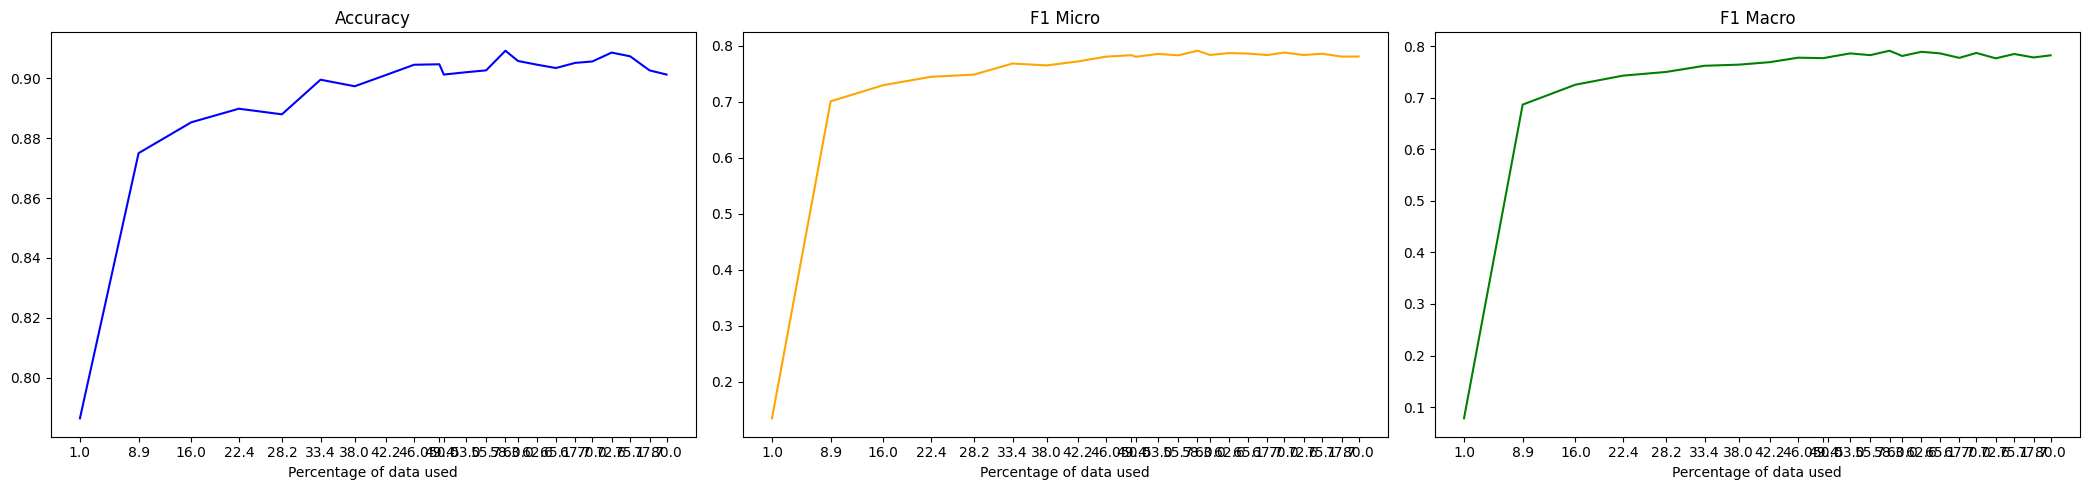

In [ ]:
initial_train_size = int(0.01 * total_data)
active_learning(50, 0, 'kmeans', 1)

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5424, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4401, Accuracy: 0.8241, F1 Micro: 0.3117, F1 Macro: 0.2115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3843, Accuracy: 0.8481, F1 Micro: 0.5106, F1 Macro: 0.4401
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3098, Accuracy: 0.867, F1 Micro: 0.6282, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2726, Accuracy: 0.877, F1 Micro: 0.6974, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2296, Accuracy: 0.8792, F1 Micro: 0.7194, F1 Macro: 0.7138
Epoch 7/10, Train Loss: 0.1744, Accuracy: 0.8816, F1 Micro: 0.7073, F1 Macro: 0.6952
Epoch 8/10, Train Loss: 0.1438, Accuracy: 0.8809, F1 Micro: 0.7176, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1025, Accuracy: 0.8813, F1 Micro: 0.733, F1 Macro: 0.7279
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5234, Accuracy: 0.8228, F1 Micro: 0.2965, F1 Macro: 0.2129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.372, Accuracy: 0.8586, F1 Micro: 0.5622, F1 Macro: 0.4862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3023, Accuracy: 0.8737, F1 Micro: 0.6633, F1 Macro: 0.661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2418, Accuracy: 0.8833, F1 Micro: 0.7018, F1 Macro: 0.685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1901, Accuracy: 0.8877, F1 Micro: 0.7449, F1 Macro: 0.7432
Epoch 6/10, Train Loss: 0.1518, Accuracy: 0.8898, F1 Micro: 0.7333, F1 Macro: 0.7262
Epoch 7/10, Train Loss: 0.1226, Accuracy: 0.8866, F1 Micro: 0.7012, F1 Macro: 0.6918
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.8872, F1 Micro: 0.7144, F1 Macro: 0.6982
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.8889, F1 Micro: 0.7197, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0616, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4818, Accuracy: 0.8297, F1 Micro: 0.3481, F1 Macro: 0.2396
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3423, Accuracy: 0.8753, F1 Micro: 0.6826, F1 Macro: 0.6786
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.246, Accuracy: 0.888, F1 Micro: 0.7147, F1 Macro: 0.7036
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1986, Accuracy: 0.8945, F1 Micro: 0.745, F1 Macro: 0.7361
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1636, Accuracy: 0.8936, F1 Micro: 0.7555, F1 Macro: 0.7537
Epoch 6/10, Train Loss: 0.1267, Accuracy: 0.8936, F1 Micro: 0.7516, F1 Macro: 0.7503
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.8938, F1 Micro: 0.75, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0745, Accuracy: 0.8961, F1 Micro: 0.7561, F1 Macro: 0.7519
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.892, F1 Micro: 0.7547, F1 Macro: 0.7554
Epoch 10/10, Train Loss: 0.05, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4778, Accuracy: 0.8433, F1 Micro: 0.4633, F1 Macro: 0.3333
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3327, Accuracy: 0.8772, F1 Micro: 0.6771, F1 Macro: 0.668
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.254, Accuracy: 0.893, F1 Micro: 0.7533, F1 Macro: 0.7451
Epoch 4/10, Train Loss: 0.2074, Accuracy: 0.8991, F1 Micro: 0.7513, F1 Macro: 0.7466
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.8958, F1 Micro: 0.7389, F1 Macro: 0.7303
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.8964, F1 Micro: 0.7554, F1 Macro: 0.7508
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.8959, F1 Micro: 0.7539, F1 Macro: 0.7498
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0767, Accuracy: 0.8945, F1 Micro: 0.7573, F1 Macro: 0.7541
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.8964, F1 Micro: 0.7376, F1 Macro: 0.7305
Epoch 10/10, Train Loss: 0.0508, Accuracy: 0.8967, F1 Micro: 0.7544, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4637, Accuracy: 0.8406, F1 Micro: 0.4383, F1 Macro: 0.3354
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3118, Accuracy: 0.8831, F1 Micro: 0.6969, F1 Macro: 0.6839
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.238, Accuracy: 0.8911, F1 Micro: 0.7287, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.8958, F1 Micro: 0.743, F1 Macro: 0.7363
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1472, Accuracy: 0.8956, F1 Micro: 0.7602, F1 Macro: 0.7547
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.8941, F1 Micro: 0.7335, F1 Macro: 0.7251
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.897, F1 Micro: 0.7576, F1 Macro: 0.752
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.8925, F1 Micro: 0.7546, F1 Macro: 0.7569
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.8967, F1 Micro: 0.751, F1 Macro: 0.7445
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0419, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4576, Accuracy: 0.8544, F1 Micro: 0.5427, F1 Macro: 0.4731
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2898, Accuracy: 0.877, F1 Micro: 0.6635, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2349, Accuracy: 0.8938, F1 Micro: 0.7401, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1877, Accuracy: 0.9002, F1 Micro: 0.7602, F1 Macro: 0.7499
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.8981, F1 Micro: 0.7758, F1 Macro: 0.7773
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9022, F1 Micro: 0.7641, F1 Macro: 0.7611
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.8952, F1 Micro: 0.7645, F1 Macro: 0.7622
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9, F1 Micro: 0.7638, F1 Macro: 0.7609
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.8978, F1 Micro: 0.7679, F1 Macro: 0.7664
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.903, F1 Micro: 0.7659, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4359, Accuracy: 0.8759, F1 Micro: 0.6727, F1 Macro: 0.647
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.285, Accuracy: 0.8888, F1 Micro: 0.7188, F1 Macro: 0.7035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2183, Accuracy: 0.8977, F1 Micro: 0.7438, F1 Macro: 0.7295
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.8975, F1 Micro: 0.7445, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.903, F1 Micro: 0.7729, F1 Macro: 0.7676
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.8989, F1 Micro: 0.747, F1 Macro: 0.745
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.9005, F1 Micro: 0.7698, F1 Macro: 0.7685
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.8992, F1 Micro: 0.7674, F1 Macro: 0.7648
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.8978, F1 Micro: 0.7647, F1 Macro: 0.762
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.9017, F1 Micro: 0.7659, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4304, Accuracy: 0.862, F1 Micro: 0.5724, F1 Macro: 0.554
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2839, Accuracy: 0.8922, F1 Micro: 0.7461, F1 Macro: 0.7392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2277, Accuracy: 0.8973, F1 Micro: 0.7524, F1 Macro: 0.7415
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9011, F1 Micro: 0.7777, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.903, F1 Micro: 0.778, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9042, F1 Micro: 0.7816, F1 Macro: 0.7813
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9039, F1 Micro: 0.7731, F1 Macro: 0.7699
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9011, F1 Micro: 0.7772, F1 Macro: 0.7769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9075, F1 Micro: 0.7836, F1 Macro: 0.7802
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4162, Accuracy: 0.8737, F1 Micro: 0.6801, F1 Macro: 0.6745
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.8942, F1 Micro: 0.7336, F1 Macro: 0.7222
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2056, Accuracy: 0.9017, F1 Micro: 0.7769, F1 Macro: 0.7759
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.8973, F1 Micro: 0.7689, F1 Macro: 0.7674
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9003, F1 Micro: 0.7626, F1 Macro: 0.7604
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9006, F1 Micro: 0.7706, F1 Macro: 0.7704
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.8989, F1 Micro: 0.7711, F1 Macro: 0.7698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9055, F1 Micro: 0.7796, F1 Macro: 0.7798
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.9047, F1 Micro: 0.7702, F1 Macro: 0.7698
Epoch 10/10, Train Loss: 0.039, Accuracy: 0.9052, F1 Micro: 0.7751, F1 Macro: 0.7733

 Iteration 3878: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.419, Accuracy: 0.8716, F1 Micro: 0.6448, F1 Macro: 0.6282
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2706, Accuracy: 0.89, F1 Micro: 0.7143, F1 Macro: 0.7068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2218, Accuracy: 0.8894, F1 Micro: 0.7676, F1 Macro: 0.7735
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9022, F1 Micro: 0.7671, F1 Macro: 0.7608
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9031, F1 Micro: 0.7801, F1 Macro: 0.7796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1068, Accuracy: 0.9017, F1 Micro: 0.7839, F1 Macro: 0.785
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9005, F1 Micro: 0.7558, F1 Macro: 0.7518
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9055, F1 Micro: 0.7802, F1 Macro: 0.7787
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.9011, F1 Micro: 0.7702, F1 Macro: 0.7694
Epoch 10/10, Train Loss: 0.0374, Accuracy: 0.9053, F1 Micro: 0.7793, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.411, Accuracy: 0.8753, F1 Micro: 0.6975, F1 Macro: 0.6947
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.8961, F1 Micro: 0.7558, F1 Macro: 0.7442
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9006, F1 Micro: 0.748, F1 Macro: 0.7412
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9064, F1 Micro: 0.7802, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.8986, F1 Micro: 0.7817, F1 Macro: 0.785
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.9036, F1 Micro: 0.7648, F1 Macro: 0.7545
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9022, F1 Micro: 0.7771, F1 Macro: 0.7763
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9016, F1 Micro: 0.7692, F1 Macro: 0.7676
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.905, F1 Micro: 0.776, F1 Macro: 0.7737
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.8978, F1 Micro: 0.7742, F1 Macro: 0.7748

 Iteration 4120: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4081, Accuracy: 0.8756, F1 Micro: 0.6821, F1 Macro: 0.6823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2555, Accuracy: 0.8966, F1 Micro: 0.7496, F1 Macro: 0.7444
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2049, Accuracy: 0.8992, F1 Micro: 0.7571, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.9075, F1 Micro: 0.7867, F1 Macro: 0.7834
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9003, F1 Micro: 0.7831, F1 Macro: 0.7832
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.8977, F1 Micro: 0.7739, F1 Macro: 0.7743
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9069, F1 Micro: 0.7693, F1 Macro: 0.7644
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9052, F1 Micro: 0.7751, F1 Macro: 0.7757
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9055, F1 Micro: 0.7815, F1 Macro: 0.7798
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.8998, F1 Micro: 0.77, F1 Macro: 0.7699

 Iteration 4330: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4048, Accuracy: 0.8648, F1 Micro: 0.603, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.8961, F1 Micro: 0.7467, F1 Macro: 0.7407
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2114, Accuracy: 0.9013, F1 Micro: 0.7611, F1 Macro: 0.7611
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9003, F1 Micro: 0.7855, F1 Macro: 0.7881
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9044, F1 Micro: 0.7845, F1 Macro: 0.7835
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9038, F1 Micro: 0.7729, F1 Macro: 0.7677
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9028, F1 Micro: 0.7676, F1 Macro: 0.7606
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9031, F1 Micro: 0.7806, F1 Macro: 0.7808
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9055, F1 Micro: 0.7785, F1 Macro: 0.7726
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.9061, F1 Micro: 0.7834, F1 Macro: 0.7797

 Iteration 4530: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3997, Accuracy: 0.8802, F1 Micro: 0.6921, F1 Macro: 0.685
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.8948, F1 Micro: 0.7554, F1 Macro: 0.7412
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.8998, F1 Micro: 0.7586, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.9062, F1 Micro: 0.7831, F1 Macro: 0.7793
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9055, F1 Micro: 0.7781, F1 Macro: 0.7723
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.9042, F1 Micro: 0.7767, F1 Macro: 0.7725
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9058, F1 Micro: 0.7806, F1 Macro: 0.7778
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9003, F1 Micro: 0.7721, F1 Macro: 0.7732
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9008, F1 Micro: 0.7743, F1 Macro: 0.7738
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9006, F1 Micro: 0.7692, F1 Macro: 0.7652

 Iteration 4663: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3922, Accuracy: 0.8847, F1 Micro: 0.7209, F1 Macro: 0.7067
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2453, Accuracy: 0.8955, F1 Micro: 0.7507, F1 Macro: 0.7305
Epoch 3/10, Train Loss: 0.2056, Accuracy: 0.9, F1 Micro: 0.7472, F1 Macro: 0.7345
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9041, F1 Micro: 0.7878, F1 Macro: 0.786
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9056, F1 Micro: 0.7823, F1 Macro: 0.7788
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9033, F1 Micro: 0.771, F1 Macro: 0.7614
Epoch 7/10, Train Loss: 0.073, Accuracy: 0.9014, F1 Micro: 0.7785, F1 Macro: 0.7806
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9041, F1 Micro: 0.7774, F1 Macro: 0.7757
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9031, F1 Micro: 0.7765, F1 Macro: 0.775
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.9014, F1 Micro: 0.7773, F1 Macro: 0.7775

 Iteration 4863: Accuracy: 0.9041, F1 Micro: 0.7878, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8847, F1 Micro: 0.7183, F1 Macro: 0.705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.8959, F1 Micro: 0.7582, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.9017, F1 Micro: 0.7857, F1 Macro: 0.7861
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.9044, F1 Micro: 0.7799, F1 Macro: 0.7764
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9045, F1 Micro: 0.7777, F1 Macro: 0.7774
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9036, F1 Micro: 0.7739, F1 Macro: 0.7704
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.9014, F1 Micro: 0.7711, F1 Macro: 0.7668
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9048, F1 Micro: 0.782, F1 Macro: 0.7793
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9016, F1 Micro: 0.7756, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.9009, F1 Micro: 0.7794, F1 Macro: 0.779

 Iteration 5063: Accuracy: 0.9017, F1 Micro: 0.7857,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3857, Accuracy: 0.8813, F1 Micro: 0.739, F1 Macro: 0.7361
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2451, Accuracy: 0.8956, F1 Micro: 0.7576, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1947, Accuracy: 0.9013, F1 Micro: 0.7676, F1 Macro: 0.7623
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9036, F1 Micro: 0.756, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.898, F1 Micro: 0.778, F1 Macro: 0.7784
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9016, F1 Micro: 0.7769, F1 Macro: 0.7744
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9041, F1 Micro: 0.7637, F1 Macro: 0.7539
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.8991, F1 Micro: 0.7765, F1 Macro: 0.7751
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9013, F1 Micro: 0.7602, F1 Macro: 0.7548
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.9058, F1 Micro: 0.7727, F1 Macro: 0.7698

 Iteration 5263: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3808, Accuracy: 0.8806, F1 Micro: 0.6861, F1 Macro: 0.6739
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2432, Accuracy: 0.8973, F1 Micro: 0.748, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2002, Accuracy: 0.9055, F1 Micro: 0.7804, F1 Macro: 0.7738
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9048, F1 Micro: 0.7801, F1 Macro: 0.778
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9013, F1 Micro: 0.7793, F1 Macro: 0.7776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9044, F1 Micro: 0.7854, F1 Macro: 0.784
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9033, F1 Micro: 0.7817, F1 Macro: 0.7816
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.9036, F1 Micro: 0.7808, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9031, F1 Micro: 0.7775, F1 Macro: 0.7738
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.9056, F1 Micro: 0.7789, F1 Macro: 0.7766

 Iteration 5441: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3869, Accuracy: 0.8841, F1 Micro: 0.7034, F1 Macro: 0.6873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.8981, F1 Micro: 0.7519, F1 Macro: 0.7406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9077, F1 Micro: 0.7754, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9073, F1 Micro: 0.7798, F1 Macro: 0.7734
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9087, F1 Micro: 0.7762, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9042, F1 Micro: 0.7857, F1 Macro: 0.7833
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.905, F1 Micro: 0.7796, F1 Macro: 0.7757
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9062, F1 Micro: 0.7736, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9092, F1 Micro: 0.7869, F1 Macro: 0.784
Epoch 10/10, Train Loss: 0.0302, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3718, Accuracy: 0.8892, F1 Micro: 0.7212, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.8973, F1 Micro: 0.7607, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.9052, F1 Micro: 0.7691, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1603, Accuracy: 0.905, F1 Micro: 0.7803, F1 Macro: 0.7718
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9002, F1 Micro: 0.7768, F1 Macro: 0.7755
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9084, F1 Micro: 0.7785, F1 Macro: 0.7706
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9059, F1 Micro: 0.7792, F1 Macro: 0.7743
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9052, F1 Micro: 0.7771, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9048, F1 Micro: 0.7844, F1 Macro: 0.7815
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9038, F1 Micro: 0.7689, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3767, Accuracy: 0.8858, F1 Micro: 0.6993, F1 Macro: 0.6847
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.9027, F1 Micro: 0.7732, F1 Macro: 0.7649
Epoch 3/10, Train Loss: 0.1973, Accuracy: 0.9023, F1 Micro: 0.7649, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.9073, F1 Micro: 0.7758, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9055, F1 Micro: 0.781, F1 Macro: 0.773
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9038, F1 Micro: 0.7658, F1 Macro: 0.7583
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9025, F1 Micro: 0.7726, F1 Macro: 0.7683
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9022, F1 Micro: 0.7758, F1 Macro: 0.7694
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9036, F1 Micro: 0.7729, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9052, F1 Micro: 0.7811, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3619, Accuracy: 0.8877, F1 Micro: 0.705, F1 Macro: 0.6932
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2302, Accuracy: 0.9033, F1 Micro: 0.7723, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.9031, F1 Micro: 0.7812, F1 Macro: 0.7756
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9086, F1 Micro: 0.7705, F1 Macro: 0.76
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9097, F1 Micro: 0.7773, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9052, F1 Micro: 0.7816, F1 Macro: 0.7761
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9013, F1 Micro: 0.777, F1 Macro: 0.7749
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.9042, F1 Micro: 0.7793, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9073, F1 Micro: 0.7803, F1 Macro: 0.779
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.9064, F1 Micro: 0.7739, F1 Macro: 0.7722

 Iteration 6218: Accu

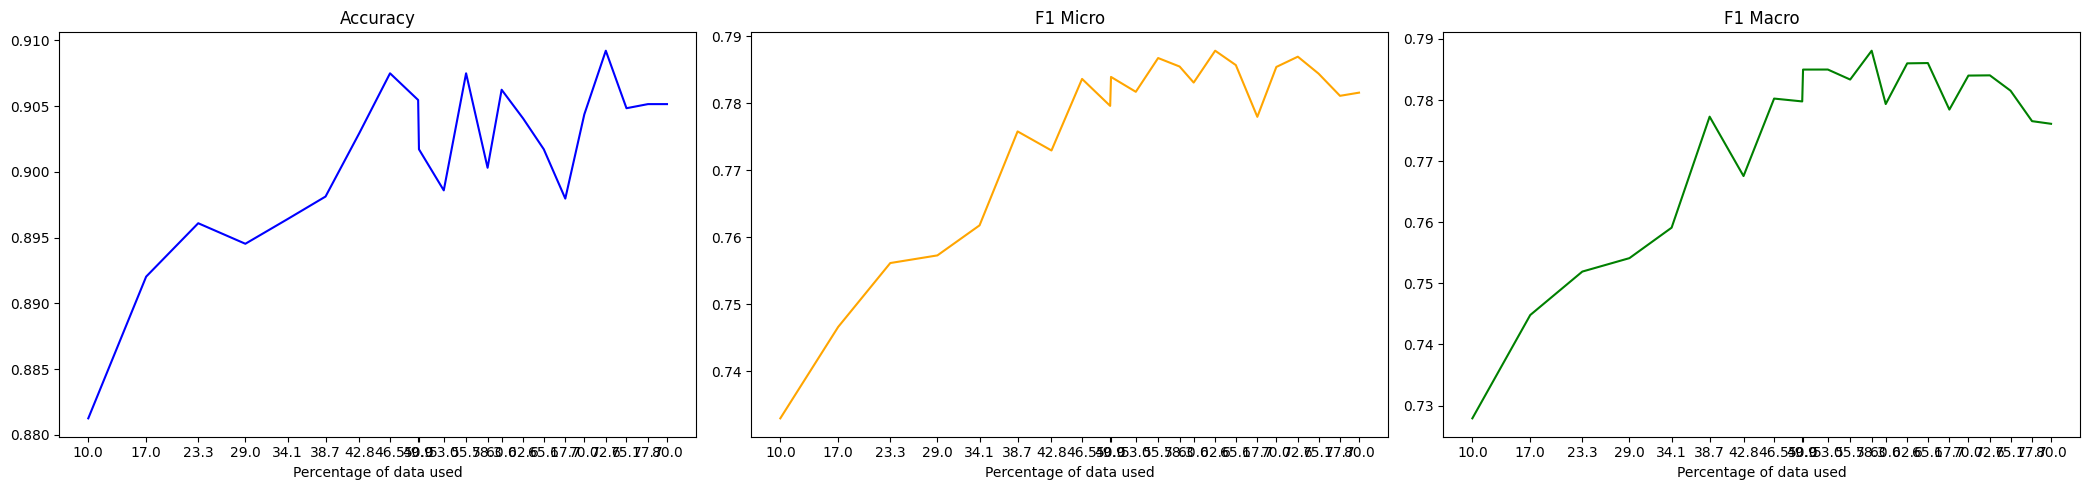

In [ ]:
initial_train_size = int(0.1 * total_data)
active_learning(50, 0, 'kmeans', 10)

# CORESET

Init size: 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6885, Accuracy: 0.7555, F1 Micro: 0.0778, F1 Macro: 0.0413
Epoch 2/10, Train Loss: 0.5719, Accuracy: 0.7855, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.5141, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.4529, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 5/10, Train Loss: 0.4945, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 6/10, Train Loss: 0.4802, Accuracy: 0.7867, F1 Micro: 0.0029, F1 Macro: 0.002
Epoch 7/10, Train Loss: 0.4452, Accuracy: 0.7878, F1 Micro: 0.0382, F1 Macro: 0.0245
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3629, Accuracy: 0.7859, F1 Micro: 0.1138, F1 Macro: 0.0642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4015, Accuracy: 0.7864, F1 Micro: 0.1343, F1 Macro: 0.0781
Epoch 10/10, Train Loss: 0.3367, Accuracy: 0.7883, F1 Micro: 0.1091, F1 Macro: 0.0697

 Iteration 77: Accuracy: 0.7864, F1 Micro: 0.1343, F1 Macro: 0.0781
      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4709, Accuracy: 0.7995, F1 Micro: 0.3208, F1 Macro: 0.1695
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2783, Accuracy: 0.8234, F1 Micro: 0.3266, F1 Macro: 0.2006
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.8288, F1 Micro: 0.3468, F1 Macro: 0.2186
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.8277, F1 Micro: 0.3327, F1 Macro: 0.2206
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.8408, F1 Micro: 0.4513, F1 Macro: 0.3605
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1231, Accuracy: 0.8472, F1 Micro: 0.4974, F1 Macro: 0.4403
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.8548, F1 Micro: 0.5752, F1 Macro: 0.5479
Epoch 8/10, Train Loss: 0.0951, Accuracy: 0.8497, F1 Micro: 0.5127, F1 Macro: 0.4602
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.8484, F1 Micro: 0.5359, F1 Macro: 0.4871
Epoch 10/10, Train Loss: 0.0566, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3982, Accuracy: 0.7202, F1 Micro: 0.289, F1 Macro: 0.1194
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1879, Accuracy: 0.835, F1 Micro: 0.4153, F1 Macro: 0.2792
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1304, Accuracy: 0.8522, F1 Micro: 0.5645, F1 Macro: 0.4504
Epoch 4/10, Train Loss: 0.097, Accuracy: 0.853, F1 Micro: 0.5325, F1 Macro: 0.446
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0825, Accuracy: 0.8575, F1 Micro: 0.5657, F1 Macro: 0.4589
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0692, Accuracy: 0.8712, F1 Micro: 0.6467, F1 Macro: 0.5974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.05, Accuracy: 0.8725, F1 Micro: 0.6608, F1 Macro: 0.6225
Epoch 8/10, Train Loss: 0.0382, Accuracy: 0.8661, F1 Micro: 0.6603, F1 Macro: 0.6219
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.8637, F1 Micro: 0.5989, F1 Macro: 0.5341
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4507, Accuracy: 0.8231, F1 Micro: 0.538, F1 Macro: 0.4557
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2507, Accuracy: 0.8564, F1 Micro: 0.5825, F1 Macro: 0.525
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.8728, F1 Micro: 0.6343, F1 Macro: 0.6209
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.885, F1 Micro: 0.7013, F1 Macro: 0.6943
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.8816, F1 Micro: 0.6687, F1 Macro: 0.6492
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.8794, F1 Micro: 0.6914, F1 Macro: 0.6829
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.8852, F1 Micro: 0.703, F1 Macro: 0.6875
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.8773, F1 Micro: 0.6776, F1 Macro: 0.6564
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.8808, F1 Micro: 0.6814, F1 Macro: 0.6706
Epoch 10/10, Train Loss: 0.0421, Accuracy: 0.8803, F1 Micro: 0.6848, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4085, Accuracy: 0.8503, F1 Micro: 0.5992, F1 Macro: 0.5846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.233, Accuracy: 0.8734, F1 Micro: 0.6469, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.18, Accuracy: 0.8892, F1 Micro: 0.7105, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1283, Accuracy: 0.8877, F1 Micro: 0.7288, F1 Macro: 0.7163
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1045, Accuracy: 0.8858, F1 Micro: 0.7436, F1 Macro: 0.739
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.8891, F1 Micro: 0.7405, F1 Macro: 0.7359
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.8873, F1 Micro: 0.7002, F1 Macro: 0.6771
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.8875, F1 Micro: 0.7337, F1 Macro: 0.7257
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.8914, F1 Micro: 0.7318, F1 Macro: 0.7234
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.8897, F1 Micro: 0.7336, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4336, Accuracy: 0.8597, F1 Micro: 0.6338, F1 Macro: 0.6118
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2574, Accuracy: 0.8834, F1 Micro: 0.7179, F1 Macro: 0.7089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.8925, F1 Micro: 0.7278, F1 Macro: 0.7172
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.8911, F1 Micro: 0.7156, F1 Macro: 0.6993
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.8802, F1 Micro: 0.6493, F1 Macro: 0.6185
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.8866, F1 Micro: 0.6962, F1 Macro: 0.6753
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.8877, F1 Micro: 0.7127, F1 Macro: 0.6934
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.892, F1 Micro: 0.7185, F1 Macro: 0.7048
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.8908, F1 Micro: 0.7264, F1 Macro: 0.7135
Epoch 10/10, Train Loss: 0.0423, Accuracy: 0.8881, F1 Micro: 0.7188, F1 Macro: 0.7091

 Iteration 2594: Accuracy: 0.8925, F1 Micro: 0.727

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4023, Accuracy: 0.868, F1 Micro: 0.6442, F1 Macro: 0.6343
Epoch 2/10, Train Loss: 0.2288, Accuracy: 0.8694, F1 Micro: 0.5942, F1 Macro: 0.5527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.893, F1 Micro: 0.7232, F1 Macro: 0.7063
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.8939, F1 Micro: 0.7302, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1107, Accuracy: 0.8945, F1 Micro: 0.7327, F1 Macro: 0.7097
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.8958, F1 Micro: 0.7492, F1 Macro: 0.7391
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.8984, F1 Micro: 0.7449, F1 Macro: 0.7332
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.8956, F1 Micro: 0.7477, F1 Macro: 0.735
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.8942, F1 Micro: 0.7375, F1 Macro: 0.7253
Epoch 10/10, Train Loss: 0.0385, Accuracy: 0.8933, F1 Micro: 0.7386, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4031, Accuracy: 0.8714, F1 Micro: 0.6543, F1 Macro: 0.6304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2341, Accuracy: 0.8892, F1 Micro: 0.7458, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.8948, F1 Micro: 0.757, F1 Macro: 0.7493
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.8966, F1 Micro: 0.7428, F1 Macro: 0.7239
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.8977, F1 Micro: 0.7394, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0816, Accuracy: 0.9005, F1 Micro: 0.7629, F1 Macro: 0.7505
Epoch 7/10, Train Loss: 0.0594, Accuracy: 0.8975, F1 Micro: 0.7479, F1 Macro: 0.7337
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9013, F1 Micro: 0.7567, F1 Macro: 0.7464
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.8986, F1 Micro: 0.7526, F1 Macro: 0.7359
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.8991, F1 Micro: 0.7577, F1 Macro: 0.7415

 Iteration 3284: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4032, Accuracy: 0.8706, F1 Micro: 0.6233, F1 Macro: 0.6011
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2301, Accuracy: 0.8934, F1 Micro: 0.7306, F1 Macro: 0.7178
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.8952, F1 Micro: 0.7541, F1 Macro: 0.7457
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.898, F1 Micro: 0.7406, F1 Macro: 0.7253
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1094, Accuracy: 0.8984, F1 Micro: 0.7665, F1 Macro: 0.7591
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.8958, F1 Micro: 0.7624, F1 Macro: 0.7546
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9, F1 Micro: 0.7599, F1 Macro: 0.749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9006, F1 Micro: 0.7727, F1 Macro: 0.7687
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9025, F1 Micro: 0.7562, F1 Macro: 0.7455
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.897, F1 Micro: 0.7647, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3948, Accuracy: 0.8819, F1 Micro: 0.7007, F1 Macro: 0.6792
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2381, Accuracy: 0.8963, F1 Micro: 0.742, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.8973, F1 Micro: 0.7603, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9, F1 Micro: 0.7608, F1 Macro: 0.7553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9002, F1 Micro: 0.777, F1 Macro: 0.7738
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.9033, F1 Micro: 0.7669, F1 Macro: 0.7578
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9056, F1 Micro: 0.7746, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.902, F1 Micro: 0.7663, F1 Macro: 0.7562
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9005, F1 Micro: 0.7676, F1 Macro: 0.7616
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9044, F1 Micro: 0.7682, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4021, Accuracy: 0.8764, F1 Micro: 0.6746, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.226, Accuracy: 0.8955, F1 Micro: 0.7432, F1 Macro: 0.7405
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.8972, F1 Micro: 0.7559, F1 Macro: 0.744
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9022, F1 Micro: 0.7699, F1 Macro: 0.7618
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.8995, F1 Micro: 0.755, F1 Macro: 0.7404
Epoch 6/10, Train Loss: 0.0829, Accuracy: 0.8988, F1 Micro: 0.7645, F1 Macro: 0.759
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.9013, F1 Micro: 0.7569, F1 Macro: 0.749
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.9013, F1 Micro: 0.7638, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.902, F1 Micro: 0.766, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0393, Accuracy: 0.8966, F1 Micro: 0.772, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4056, Accuracy: 0.8814, F1 Micro: 0.6985, F1 Macro: 0.6835
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2452, Accuracy: 0.8948, F1 Micro: 0.7417, F1 Macro: 0.7288
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1861, Accuracy: 0.8933, F1 Micro: 0.7712, F1 Macro: 0.7732
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9062, F1 Micro: 0.7669, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9014, F1 Micro: 0.7741, F1 Macro: 0.7674
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9013, F1 Micro: 0.7599, F1 Macro: 0.7446
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9019, F1 Micro: 0.7713, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0486, Accuracy: 0.9069, F1 Micro: 0.781, F1 Macro: 0.7787
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.903, F1 Micro: 0.777, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0328, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3955, Accuracy: 0.883, F1 Micro: 0.7179, F1 Macro: 0.712
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2312, Accuracy: 0.8953, F1 Micro: 0.7641, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9013, F1 Micro: 0.773, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1449, Accuracy: 0.9009, F1 Micro: 0.7808, F1 Macro: 0.7753
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.9013, F1 Micro: 0.7588, F1 Macro: 0.7462
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9008, F1 Micro: 0.752, F1 Macro: 0.7413
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.9039, F1 Micro: 0.768, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9038, F1 Micro: 0.7811, F1 Macro: 0.7775
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9011, F1 Micro: 0.7684, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.9025, F1 Micro: 0.7803, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3844, Accuracy: 0.8834, F1 Micro: 0.7122, F1 Macro: 0.7029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2381, Accuracy: 0.9006, F1 Micro: 0.7627, F1 Macro: 0.756
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.903, F1 Micro: 0.7525, F1 Macro: 0.7456
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9027, F1 Micro: 0.7579, F1 Macro: 0.7498
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1141, Accuracy: 0.8967, F1 Micro: 0.7752, F1 Macro: 0.7775
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9019, F1 Micro: 0.7658, F1 Macro: 0.7603
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.9052, F1 Micro: 0.7668, F1 Macro: 0.7536
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9041, F1 Micro: 0.7655, F1 Macro: 0.752
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9048, F1 Micro: 0.7613, F1 Macro: 0.7548
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.9041, F1 Micro: 0.7702, F1 Macro: 0.7663

 Iteration 4530: Accuracy: 0.8967, F1 Micro: 0.7752,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3912, Accuracy: 0.8828, F1 Micro: 0.7331, F1 Macro: 0.7255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2385, Accuracy: 0.8969, F1 Micro: 0.7454, F1 Macro: 0.739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.9023, F1 Micro: 0.7693, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.9034, F1 Micro: 0.7743, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9011, F1 Micro: 0.7837, F1 Macro: 0.7837
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9053, F1 Micro: 0.7724, F1 Macro: 0.7636
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9027, F1 Micro: 0.7822, F1 Macro: 0.7799
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9059, F1 Micro: 0.7784, F1 Macro: 0.7753
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.9073, F1 Micro: 0.7732, F1 Macro: 0.7657
Epoch 10/10, Train Loss: 0.037, Accuracy: 0.9044, F1 Micro: 0.7787, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3724, Accuracy: 0.8827, F1 Micro: 0.7077, F1 Macro: 0.6936
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.8909, F1 Micro: 0.7153, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.194, Accuracy: 0.9028, F1 Micro: 0.7849, F1 Macro: 0.7832
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9064, F1 Micro: 0.7786, F1 Macro: 0.7709
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9078, F1 Micro: 0.7795, F1 Macro: 0.7744
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9056, F1 Micro: 0.7771, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9031, F1 Micro: 0.7868, F1 Macro: 0.7847
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9086, F1 Micro: 0.7841, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9058, F1 Micro: 0.779, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.9031, F1 Micro: 0.7783, F1 Macro: 0.776

 Iteration 4863: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3789, Accuracy: 0.8842, F1 Micro: 0.7028, F1 Macro: 0.6809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2289, Accuracy: 0.898, F1 Micro: 0.7464, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1888, Accuracy: 0.9059, F1 Micro: 0.79, F1 Macro: 0.7882
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.905, F1 Micro: 0.7847, F1 Macro: 0.7797
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9073, F1 Micro: 0.7871, F1 Macro: 0.7828
Epoch 6/10, Train Loss: 0.0803, Accuracy: 0.9092, F1 Micro: 0.7883, F1 Macro: 0.7834
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.9078, F1 Micro: 0.7912, F1 Macro: 0.7883
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9041, F1 Micro: 0.7791, F1 Macro: 0.776
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9062, F1 Micro: 0.7749, F1 Macro: 0.7686
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.908, F1 Micro: 0.784, F1 Macro: 0.7835

 Iteration 5063: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3788, Accuracy: 0.888, F1 Micro: 0.7266, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2317, Accuracy: 0.9, F1 Micro: 0.7668, F1 Macro: 0.7609
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9039, F1 Micro: 0.7666, F1 Macro: 0.7569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.905, F1 Micro: 0.7707, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9072, F1 Micro: 0.7803, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.9064, F1 Micro: 0.7843, F1 Macro: 0.7805
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.9072, F1 Micro: 0.7736, F1 Macro: 0.7691
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9059, F1 Micro: 0.7855, F1 Macro: 0.7845
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9047, F1 Micro: 0.7777, F1 Macro: 0.7735
Epoch 10/10, Train Loss: 0.0312, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8869, F1 Micro: 0.7409, F1 Macro: 0.7345
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2416, Accuracy: 0.8977, F1 Micro: 0.7488, F1 Macro: 0.7377
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1884, Accuracy: 0.9053, F1 Micro: 0.7574, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.908, F1 Micro: 0.7876, F1 Macro: 0.7835
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9028, F1 Micro: 0.7851, F1 Macro: 0.7851
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9087, F1 Micro: 0.7801, F1 Macro: 0.775
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9027, F1 Micro: 0.7462, F1 Macro: 0.7342
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9061, F1 Micro: 0.7745, F1 Macro: 0.7673
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9067, F1 Micro: 0.7803, F1 Macro: 0.7764
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.9033, F1 Micro: 0.7784, F1 Macro: 0.7799

 Iteration 5441: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3726, Accuracy: 0.8739, F1 Micro: 0.6428, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2388, Accuracy: 0.9009, F1 Micro: 0.7604, F1 Macro: 0.7563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.9056, F1 Micro: 0.777, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.907, F1 Micro: 0.7868, F1 Macro: 0.7832
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.8988, F1 Micro: 0.7793, F1 Macro: 0.7793
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.9039, F1 Micro: 0.7655, F1 Macro: 0.7596
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.902, F1 Micro: 0.7602, F1 Macro: 0.7511
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0493, Accuracy: 0.9086, F1 Micro: 0.787, F1 Macro: 0.7859
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9058, F1 Micro: 0.7751, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3704, Accuracy: 0.888, F1 Micro: 0.7332, F1 Macro: 0.7266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2342, Accuracy: 0.8986, F1 Micro: 0.7758, F1 Macro: 0.7736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.9056, F1 Micro: 0.7863, F1 Macro: 0.7827
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9062, F1 Micro: 0.7828, F1 Macro: 0.7758
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9078, F1 Micro: 0.7878, F1 Macro: 0.7849
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9044, F1 Micro: 0.7803, F1 Macro: 0.7774
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.9061, F1 Micro: 0.7767, F1 Macro: 0.774
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9058, F1 Micro: 0.7744, F1 Macro: 0.7697
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.9056, F1 Micro: 0.7867, F1 Macro: 0.784
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9059, F1 Micro: 0.7877, F1 Macro: 0.7857

 Iteration 5841: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3631, Accuracy: 0.893, F1 Micro: 0.7358, F1 Macro: 0.7234
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2283, Accuracy: 0.9002, F1 Micro: 0.7463, F1 Macro: 0.7306
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1886, Accuracy: 0.9042, F1 Micro: 0.7643, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.9066, F1 Micro: 0.7921, F1 Macro: 0.7912
Epoch 5/10, Train Loss: 0.1115, Accuracy: 0.9045, F1 Micro: 0.7869, F1 Macro: 0.7864
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.907, F1 Micro: 0.782, F1 Macro: 0.7772
Epoch 7/10, Train Loss: 0.0603, Accuracy: 0.9033, F1 Micro: 0.7827, F1 Macro: 0.781
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.902, F1 Micro: 0.7782, F1 Macro: 0.7771
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9033, F1 Micro: 0.7774, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.9039, F1 Micro: 0.7856, F1 Macro: 0.7857

 Iteration 6041: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3676, Accuracy: 0.8894, F1 Micro: 0.711, F1 Macro: 0.6974
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.242, Accuracy: 0.9006, F1 Micro: 0.7506, F1 Macro: 0.7369
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.9023, F1 Micro: 0.7777, F1 Macro: 0.7693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.8994, F1 Micro: 0.784, F1 Macro: 0.7821
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9023, F1 Micro: 0.785, F1 Macro: 0.7841
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9044, F1 Micro: 0.7602, F1 Macro: 0.7502
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9, F1 Micro: 0.7795, F1 Macro: 0.7816
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9031, F1 Micro: 0.7798, F1 Macro: 0.7785
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9013, F1 Micro: 0.7712, F1 Macro: 0.7681
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9011, F1 Micro: 0.7568, F1 Macro

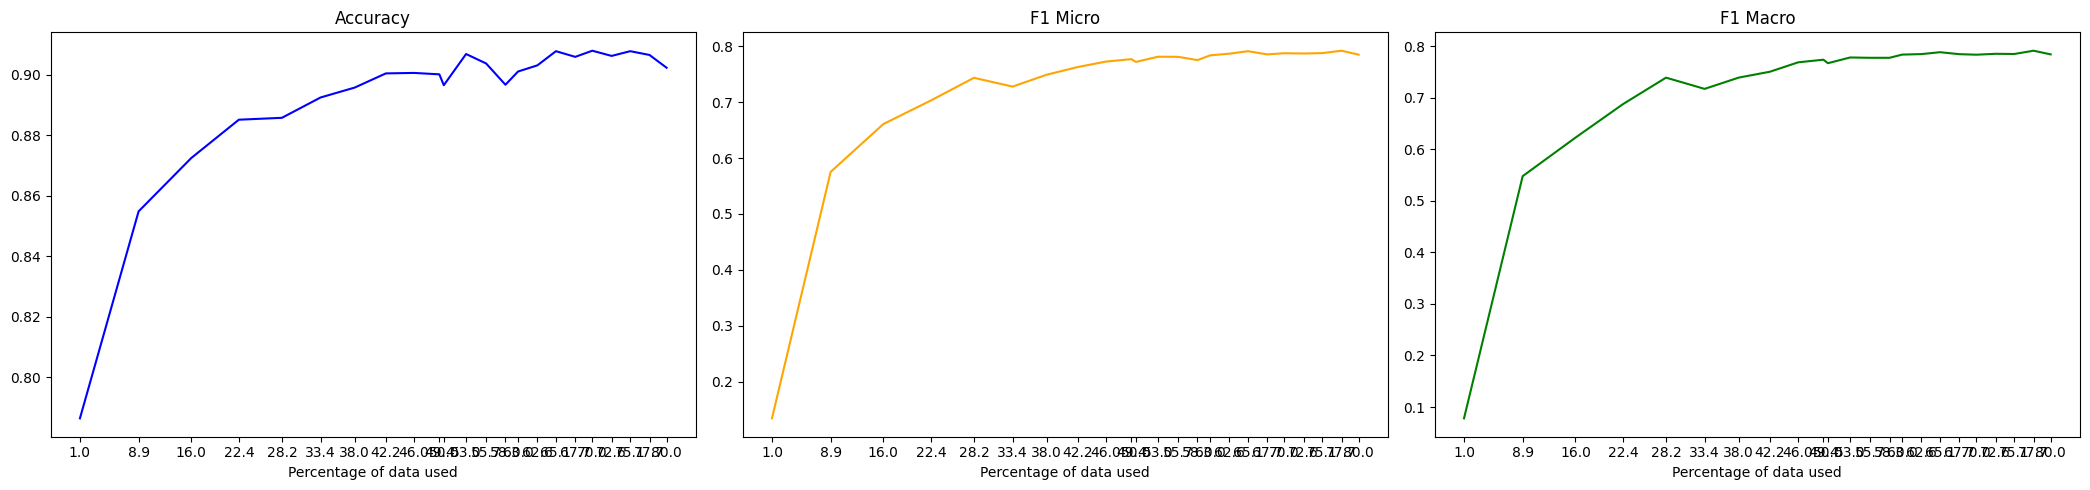

In [28]:
initial_train_size = int(0.01 * total_data)
active_learning(50, 0, 'coreset', 1)

Init size: 10
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5424, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4401, Accuracy: 0.8241, F1 Micro: 0.3117, F1 Macro: 0.2115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3843, Accuracy: 0.8481, F1 Micro: 0.5106, F1 Macro: 0.4401
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3098, Accuracy: 0.867, F1 Micro: 0.6282, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2726, Accuracy: 0.877, F1 Micro: 0.6974, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2296, Accuracy: 0.8792, F1 Micro: 0.7194, F1 Macro: 0.7138
Epoch 7/10, Train Loss: 0.1744, Accuracy: 0.8816, F1 Micro: 0.7073, F1 Macro: 0.6952
Epoch 8/10, Train Loss: 0.1438, Accuracy: 0.8809, F1 Micro: 0.7176, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1025, Accuracy: 0.8813, F1 Micro: 0.733, F1 Macro: 0.7279
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4495, Accuracy: 0.8223, F1 Micro: 0.3212, F1 Macro: 0.1978
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2794, Accuracy: 0.8258, F1 Micro: 0.3647, F1 Macro: 0.2164
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2288, Accuracy: 0.8677, F1 Micro: 0.6341, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.187, Accuracy: 0.8783, F1 Micro: 0.6922, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.878, F1 Micro: 0.7038, F1 Macro: 0.6965
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.8817, F1 Micro: 0.7212, F1 Macro: 0.708
Epoch 7/10, Train Loss: 0.0879, Accuracy: 0.8833, F1 Micro: 0.7053, F1 Macro: 0.6887
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.8795, F1 Micro: 0.6664, F1 Macro: 0.6381
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.8808, F1 Micro: 0.7071, F1 Macro: 0.6943
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4815, Accuracy: 0.8211, F1 Micro: 0.5823, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3143, Accuracy: 0.8641, F1 Micro: 0.6498, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.252, Accuracy: 0.8764, F1 Micro: 0.6809, F1 Macro: 0.6691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2086, Accuracy: 0.8788, F1 Micro: 0.7275, F1 Macro: 0.7221
Epoch 5/10, Train Loss: 0.1674, Accuracy: 0.8861, F1 Micro: 0.7242, F1 Macro: 0.717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.888, F1 Micro: 0.7351, F1 Macro: 0.7249
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.8881, F1 Micro: 0.7259, F1 Macro: 0.7221
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.8875, F1 Micro: 0.7179, F1 Macro: 0.7112
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.8877, F1 Micro: 0.7195, F1 Macro: 0.7102
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0485, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4558, Accuracy: 0.8452, F1 Micro: 0.592, F1 Macro: 0.5806
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2735, Accuracy: 0.8652, F1 Micro: 0.6612, F1 Macro: 0.6613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2157, Accuracy: 0.8783, F1 Micro: 0.7199, F1 Macro: 0.7074
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.8908, F1 Micro: 0.7268, F1 Macro: 0.7104
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.8884, F1 Micro: 0.7228, F1 Macro: 0.7145
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.8911, F1 Micro: 0.7459, F1 Macro: 0.7397
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.8906, F1 Micro: 0.7496, F1 Macro: 0.7407
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.8928, F1 Micro: 0.745, F1 Macro: 0.734
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.8945, F1 Micro: 0.7417, F1 Macro: 0.7308
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4502, Accuracy: 0.8491, F1 Micro: 0.5223, F1 Macro: 0.461
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2815, Accuracy: 0.8798, F1 Micro: 0.6908, F1 Macro: 0.6858
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2335, Accuracy: 0.8905, F1 Micro: 0.7301, F1 Macro: 0.7247
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.8941, F1 Micro: 0.7246, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.8956, F1 Micro: 0.7489, F1 Macro: 0.7389
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.8961, F1 Micro: 0.7523, F1 Macro: 0.7432
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.89, F1 Micro: 0.7042, F1 Macro: 0.676
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.895, F1 Micro: 0.7417, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.8975, F1 Micro: 0.7534, F1 Macro: 0.7471
Epoch 10/10, Train Loss: 0.0415, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4237, Accuracy: 0.8666, F1 Micro: 0.6459, F1 Macro: 0.6442
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2575, Accuracy: 0.8844, F1 Micro: 0.7028, F1 Macro: 0.689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1997, Accuracy: 0.8942, F1 Micro: 0.7486, F1 Macro: 0.7385
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.8923, F1 Micro: 0.7187, F1 Macro: 0.6932
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.8963, F1 Micro: 0.7637, F1 Macro: 0.7553
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.8997, F1 Micro: 0.7525, F1 Macro: 0.7394
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.8948, F1 Micro: 0.7634, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.8969, F1 Micro: 0.7641, F1 Macro: 0.7568
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.8975, F1 Micro: 0.7609, F1 Macro: 0.7485
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.8978, F1 Micro: 0.7601, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4226, Accuracy: 0.8636, F1 Micro: 0.6219, F1 Macro: 0.6138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.8855, F1 Micro: 0.7379, F1 Macro: 0.7294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.8966, F1 Micro: 0.7539, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.8995, F1 Micro: 0.7594, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.898, F1 Micro: 0.7626, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9028, F1 Micro: 0.7701, F1 Macro: 0.7678
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.8972, F1 Micro: 0.7584, F1 Macro: 0.7515
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9025, F1 Micro: 0.7742, F1 Macro: 0.7692
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.8975, F1 Micro: 0.7727, F1 Macro: 0.7683
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4178, Accuracy: 0.8627, F1 Micro: 0.6286, F1 Macro: 0.6241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2589, Accuracy: 0.8942, F1 Micro: 0.7492, F1 Macro: 0.7451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1893, Accuracy: 0.9009, F1 Micro: 0.7629, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.9008, F1 Micro: 0.7703, F1 Macro: 0.7659
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9008, F1 Micro: 0.763, F1 Macro: 0.7481
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.8997, F1 Micro: 0.7645, F1 Macro: 0.754
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.8989, F1 Micro: 0.748, F1 Macro: 0.7363
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.8984, F1 Micro: 0.7525, F1 Macro: 0.7333
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9, F1 Micro: 0.775, F1 Macro: 0.7717
Epoch 10/10, Train Loss: 0.0363, Accuracy: 0.9005, F1 Micro: 0.7691, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4195, Accuracy: 0.8719, F1 Micro: 0.6774, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.8927, F1 Micro: 0.7494, F1 Macro: 0.7489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2016, Accuracy: 0.8984, F1 Micro: 0.761, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9006, F1 Micro: 0.7672, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9016, F1 Micro: 0.7799, F1 Macro: 0.7764
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.8975, F1 Micro: 0.767, F1 Macro: 0.7631
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9, F1 Micro: 0.7637, F1 Macro: 0.7572
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.8986, F1 Micro: 0.7631, F1 Macro: 0.7575
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.8978, F1 Micro: 0.7629, F1 Macro: 0.7523
Epoch 10/10, Train Loss: 0.0381, Accuracy: 0.9006, F1 Micro: 0.7627, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4048, Accuracy: 0.8783, F1 Micro: 0.701, F1 Macro: 0.6998
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.8956, F1 Micro: 0.7645, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.9013, F1 Micro: 0.7786, F1 Macro: 0.7779
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9034, F1 Micro: 0.7774, F1 Macro: 0.7727
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.8981, F1 Micro: 0.7541, F1 Macro: 0.7459
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9, F1 Micro: 0.7512, F1 Macro: 0.7395
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9009, F1 Micro: 0.7523, F1 Macro: 0.7387
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.8995, F1 Micro: 0.7585, F1 Macro: 0.753
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.8964, F1 Micro: 0.7538, F1 Macro: 0.7415
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.8997, F1 Micro: 0.7604, F1 Macro: 0.751

 Iteration 3886: Accuracy: 0.9013, F1 Micro: 0.7786, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3981, Accuracy: 0.8769, F1 Micro: 0.7066, F1 Macro: 0.7015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2429, Accuracy: 0.8925, F1 Micro: 0.7342, F1 Macro: 0.7262
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.8928, F1 Micro: 0.7626, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.8998, F1 Micro: 0.7683, F1 Macro: 0.7627
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.8958, F1 Micro: 0.7724, F1 Macro: 0.7699
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.8956, F1 Micro: 0.7712, F1 Macro: 0.7685
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9025, F1 Micro: 0.7718, F1 Macro: 0.7618
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.8991, F1 Micro: 0.7703, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9047, F1 Micro: 0.7732, F1 Macro: 0.7599
Epoch 10/10, Train Loss: 0.0336, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3902, Accuracy: 0.8798, F1 Micro: 0.7237, F1 Macro: 0.7202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2335, Accuracy: 0.8961, F1 Micro: 0.7358, F1 Macro: 0.7279
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.8988, F1 Micro: 0.7569, F1 Macro: 0.7389
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9039, F1 Micro: 0.7736, F1 Macro: 0.7694
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.902, F1 Micro: 0.7696, F1 Macro: 0.7624
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9014, F1 Micro: 0.7625, F1 Macro: 0.7481
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9009, F1 Micro: 0.7688, F1 Macro: 0.7629
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.903, F1 Micro: 0.7709, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9075, F1 Micro: 0.7752, F1 Macro: 0.7696
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.9013, F1 Micro: 0.7712, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3942, Accuracy: 0.8847, F1 Micro: 0.696, F1 Macro: 0.6861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2454, Accuracy: 0.8972, F1 Micro: 0.7487, F1 Macro: 0.739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1901, Accuracy: 0.9022, F1 Micro: 0.7779, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9034, F1 Micro: 0.7822, F1 Macro: 0.7793
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9053, F1 Micro: 0.7769, F1 Macro: 0.7707
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9023, F1 Micro: 0.7735, F1 Macro: 0.7704
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9025, F1 Micro: 0.7498, F1 Macro: 0.735
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.8995, F1 Micro: 0.7644, F1 Macro: 0.7562
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.9016, F1 Micro: 0.7614, F1 Macro: 0.7549
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9019, F1 Micro: 0.7549, F1 Macro: 0.7422

 Iteration 4530: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3868, Accuracy: 0.8828, F1 Micro: 0.6961, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2411, Accuracy: 0.8948, F1 Micro: 0.768, F1 Macro: 0.7637
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.902, F1 Micro: 0.7491, F1 Macro: 0.7405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.9003, F1 Micro: 0.7693, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9034, F1 Micro: 0.7735, F1 Macro: 0.7665
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9033, F1 Micro: 0.7701, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.905, F1 Micro: 0.7799, F1 Macro: 0.7749
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9013, F1 Micro: 0.7733, F1 Macro: 0.7704
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9017, F1 Micro: 0.7732, F1 Macro: 0.7641
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9041, F1 Micro: 0.7736, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.8834, F1 Micro: 0.7255, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.8981, F1 Micro: 0.7471, F1 Macro: 0.7285
Epoch 3/10, Train Loss: 0.1961, Accuracy: 0.9011, F1 Micro: 0.7463, F1 Macro: 0.7343
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1481, Accuracy: 0.9028, F1 Micro: 0.7613, F1 Macro: 0.7485
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9009, F1 Micro: 0.7661, F1 Macro: 0.7569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9027, F1 Micro: 0.7687, F1 Macro: 0.7627
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.9002, F1 Micro: 0.7669, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9048, F1 Micro: 0.7781, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.9055, F1 Micro: 0.7706, F1 Macro: 0.761
Epoch 10/10, Train Loss: 0.0289, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8816, F1 Micro: 0.7091, F1 Macro: 0.6951
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2413, Accuracy: 0.9, F1 Micro: 0.7488, F1 Macro: 0.7343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.197, Accuracy: 0.9013, F1 Micro: 0.7543, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9038, F1 Micro: 0.7651, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.905, F1 Micro: 0.7676, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.9027, F1 Micro: 0.7745, F1 Macro: 0.7715
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9044, F1 Micro: 0.7727, F1 Macro: 0.7692
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9038, F1 Micro: 0.7689, F1 Macro: 0.7627
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9077, F1 Micro: 0.7801, F1 Macro: 0.7785
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3848, Accuracy: 0.8895, F1 Micro: 0.7244, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.8963, F1 Micro: 0.7589, F1 Macro: 0.7575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.9009, F1 Micro: 0.765, F1 Macro: 0.7563
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.9081, F1 Micro: 0.7771, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9069, F1 Micro: 0.7851, F1 Macro: 0.7804
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9052, F1 Micro: 0.7784, F1 Macro: 0.7769
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.9033, F1 Micro: 0.7801, F1 Macro: 0.7749
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9038, F1 Micro: 0.7766, F1 Macro: 0.7681
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.9047, F1 Micro: 0.7679, F1 Macro: 0.76
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9077, F1 Micro: 0.7825, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3776, Accuracy: 0.8852, F1 Micro: 0.7387, F1 Macro: 0.7366
Epoch 2/10, Train Loss: 0.236, Accuracy: 0.8922, F1 Micro: 0.7191, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.9014, F1 Micro: 0.7857, F1 Macro: 0.7856
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9081, F1 Micro: 0.7835, F1 Macro: 0.7768
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.903, F1 Micro: 0.7783, F1 Macro: 0.778
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9042, F1 Micro: 0.7521, F1 Macro: 0.7423
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.9044, F1 Micro: 0.7706, F1 Macro: 0.7665
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9075, F1 Micro: 0.7809, F1 Macro: 0.778
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9081, F1 Micro: 0.7786, F1 Macro: 0.773
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9084, F1 Micro: 0.7794, F1 Macro: 0.7752

 Iteration 5441: Accuracy: 0.9014, F1 Micro: 0.7857, F1 Macro: 0.7856
                 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3805, Accuracy: 0.8852, F1 Micro: 0.7009, F1 Macro: 0.6829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2391, Accuracy: 0.903, F1 Micro: 0.78, F1 Macro: 0.7761
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9039, F1 Micro: 0.7761, F1 Macro: 0.7731
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9053, F1 Micro: 0.7713, F1 Macro: 0.7607
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.9022, F1 Micro: 0.7545, F1 Macro: 0.7345
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9052, F1 Micro: 0.7734, F1 Macro: 0.7644
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9056, F1 Micro: 0.7797, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.9064, F1 Micro: 0.7815, F1 Macro: 0.7778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9094, F1 Micro: 0.7829, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.908, F1 Micro: 0.7862, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3695, Accuracy: 0.8886, F1 Micro: 0.7329, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2308, Accuracy: 0.9014, F1 Micro: 0.7678, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9064, F1 Micro: 0.7782, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9038, F1 Micro: 0.7806, F1 Macro: 0.7784
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.9039, F1 Micro: 0.7555, F1 Macro: 0.7396
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.903, F1 Micro: 0.7817, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9045, F1 Micro: 0.7876, F1 Macro: 0.784
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9077, F1 Micro: 0.7879, F1 Macro: 0.7866
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9073, F1 Micro: 0.7868, F1 Macro: 0.7846
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3697, Accuracy: 0.8892, F1 Micro: 0.7255, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2343, Accuracy: 0.8983, F1 Micro: 0.774, F1 Macro: 0.7736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.9034, F1 Micro: 0.7822, F1 Macro: 0.7767
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.9064, F1 Micro: 0.786, F1 Macro: 0.7823
Epoch 5/10, Train Loss: 0.112, Accuracy: 0.9034, F1 Micro: 0.7782, F1 Macro: 0.7752
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9045, F1 Micro: 0.784, F1 Macro: 0.7837
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.8984, F1 Micro: 0.7775, F1 Macro: 0.7755
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9053, F1 Micro: 0.7761, F1 Macro: 0.7699
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9055, F1 Micro: 0.7767, F1 Macro: 0.7707
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9025, F1 Micro: 0.7812, F1 Macro: 0.7764

 Iteration 6041: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3663, Accuracy: 0.8878, F1 Micro: 0.7142, F1 Macro: 0.6956
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.235, Accuracy: 0.9017, F1 Micro: 0.7784, F1 Macro: 0.774
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.9025, F1 Micro: 0.777, F1 Macro: 0.7678
Epoch 4/10, Train Loss: 0.1527, Accuracy: 0.9008, F1 Micro: 0.7536, F1 Macro: 0.7388
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.9044, F1 Micro: 0.7604, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.902, F1 Micro: 0.7798, F1 Macro: 0.7785
Epoch 7/10, Train Loss: 0.0645, Accuracy: 0.9058, F1 Micro: 0.7776, F1 Macro: 0.7746
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.8955, F1 Micro: 0.7727, F1 Macro: 0.7693
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9048, F1 Micro: 0.7723, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.9031, F1 Micro: 0.7822, F1 Macro: 0.7814

 Iteration 6218: Accu

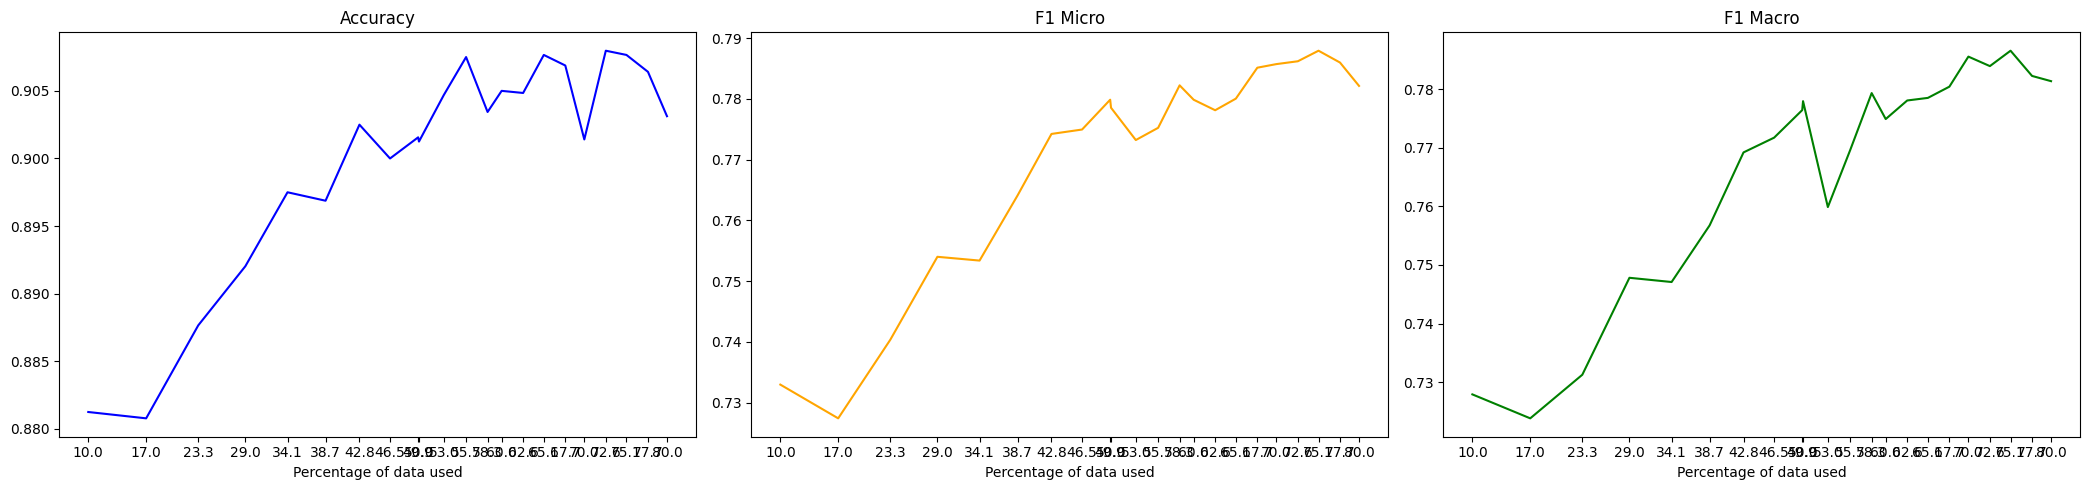

In [29]:
initial_train_size = int(0.1 * total_data)
active_learning(50, 0, 'coreset', 10)

# RANDOM SAMPLING

Init size: 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6885, Accuracy: 0.7555, F1 Micro: 0.0778, F1 Macro: 0.0413
Epoch 2/10, Train Loss: 0.5719, Accuracy: 0.7855, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.5141, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.4529, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 5/10, Train Loss: 0.4945, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 6/10, Train Loss: 0.4802, Accuracy: 0.7867, F1 Micro: 0.0029, F1 Macro: 0.002
Epoch 7/10, Train Loss: 0.4452, Accuracy: 0.7878, F1 Micro: 0.0382, F1 Macro: 0.0245
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3629, Accuracy: 0.7859, F1 Micro: 0.1138, F1 Macro: 0.0642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4015, Accuracy: 0.7864, F1 Micro: 0.1343, F1 Macro: 0.0781
Epoch 10/10, Train Loss: 0.3367, Accuracy: 0.7883, F1 Micro: 0.1091, F1 Macro: 0.0697

 Iteration 77: Accuracy: 0.7864, F1 Micro: 0.1343, F1 Macro: 0.0781
      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5501, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4699, Accuracy: 0.8178, F1 Micro: 0.2554, F1 Macro: 0.1759
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3968, Accuracy: 0.833, F1 Micro: 0.3916, F1 Macro: 0.2974
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3406, Accuracy: 0.8595, F1 Micro: 0.5956, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2777, Accuracy: 0.8697, F1 Micro: 0.6841, F1 Macro: 0.6689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2507, Accuracy: 0.8753, F1 Micro: 0.7104, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2089, Accuracy: 0.8788, F1 Micro: 0.7117, F1 Macro: 0.7057
Epoch 8/10, Train Loss: 0.1742, Accuracy: 0.8791, F1 Micro: 0.6698, F1 Macro: 0.6577
Epoch 9/10, Train Loss: 0.1422, Accuracy: 0.8841, F1 Micro: 0.6986, F1 Macro: 0.674
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5262, Accuracy: 0.8086, F1 Micro: 0.1871, F1 Macro: 0.1382
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4051, Accuracy: 0.8492, F1 Micro: 0.5336, F1 Macro: 0.5233
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.314, Accuracy: 0.8728, F1 Micro: 0.6775, F1 Macro: 0.6631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2576, Accuracy: 0.8789, F1 Micro: 0.6856, F1 Macro: 0.6631
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2145, Accuracy: 0.8858, F1 Micro: 0.7159, F1 Macro: 0.7077
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1784, Accuracy: 0.8895, F1 Micro: 0.7209, F1 Macro: 0.714
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.8848, F1 Micro: 0.7003, F1 Macro: 0.688
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.89, F1 Micro: 0.7359, F1 Macro: 0.7327
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0842, Accuracy: 0.8866, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4944, Accuracy: 0.8294, F1 Micro: 0.3673, F1 Macro: 0.2609
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3551, Accuracy: 0.8745, F1 Micro: 0.6627, F1 Macro: 0.6385
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2647, Accuracy: 0.8802, F1 Micro: 0.6749, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2306, Accuracy: 0.8923, F1 Micro: 0.7369, F1 Macro: 0.7294
Epoch 5/10, Train Loss: 0.1785, Accuracy: 0.8903, F1 Micro: 0.7102, F1 Macro: 0.7052
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1314, Accuracy: 0.8998, F1 Micro: 0.7556, F1 Macro: 0.7511
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.8959, F1 Micro: 0.7458, F1 Macro: 0.7353
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.8933, F1 Micro: 0.7594, F1 Macro: 0.7539
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.8933, F1 Micro: 0.7297, F1 Macro: 0.714
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4722, Accuracy: 0.8308, F1 Micro: 0.3656, F1 Macro: 0.251
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3302, Accuracy: 0.8777, F1 Micro: 0.6973, F1 Macro: 0.6916
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2569, Accuracy: 0.8905, F1 Micro: 0.7211, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2009, Accuracy: 0.8955, F1 Micro: 0.7434, F1 Macro: 0.7371
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.8906, F1 Micro: 0.7581, F1 Macro: 0.7551
Epoch 6/10, Train Loss: 0.1376, Accuracy: 0.8931, F1 Micro: 0.7498, F1 Macro: 0.7402
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9009, F1 Micro: 0.7529, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.8959, F1 Micro: 0.7583, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9009, F1 Micro: 0.7595, F1 Macro: 0.751
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4627, Accuracy: 0.8423, F1 Micro: 0.4703, F1 Macro: 0.3833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2983, Accuracy: 0.8855, F1 Micro: 0.7043, F1 Macro: 0.6932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2428, Accuracy: 0.8914, F1 Micro: 0.7376, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2117, Accuracy: 0.9002, F1 Micro: 0.7609, F1 Macro: 0.7504
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1548, Accuracy: 0.9016, F1 Micro: 0.7702, F1 Macro: 0.7611
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.8989, F1 Micro: 0.755, F1 Macro: 0.7425
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.8995, F1 Micro: 0.7524, F1 Macro: 0.7407
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.8989, F1 Micro: 0.7552, F1 Macro: 0.7474
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.8955, F1 Micro: 0.7573, F1 Macro: 0.7492
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.8986, F1 Micro: 0.7559, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4466, Accuracy: 0.8584, F1 Micro: 0.5682, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2857, Accuracy: 0.8914, F1 Micro: 0.751, F1 Macro: 0.7451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2259, Accuracy: 0.9016, F1 Micro: 0.7679, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9006, F1 Micro: 0.7679, F1 Macro: 0.768
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.8973, F1 Micro: 0.7669, F1 Macro: 0.7627
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.8995, F1 Micro: 0.7578, F1 Macro: 0.7495
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.8969, F1 Micro: 0.746, F1 Macro: 0.7295
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.8997, F1 Micro: 0.7719, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9034, F1 Micro: 0.7735, F1 Macro: 0.7693
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4295, Accuracy: 0.8712, F1 Micro: 0.6691, F1 Macro: 0.663
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2818, Accuracy: 0.8905, F1 Micro: 0.7208, F1 Macro: 0.706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2228, Accuracy: 0.8992, F1 Micro: 0.7645, F1 Macro: 0.7617
Epoch 4/10, Train Loss: 0.1934, Accuracy: 0.9014, F1 Micro: 0.7611, F1 Macro: 0.755
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9014, F1 Micro: 0.763, F1 Macro: 0.7589
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.903, F1 Micro: 0.7756, F1 Macro: 0.7686
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9039, F1 Micro: 0.7703, F1 Macro: 0.7627
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9061, F1 Micro: 0.7691, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9, F1 Micro: 0.7782, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0379, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.42, Accuracy: 0.8745, F1 Micro: 0.6495, F1 Macro: 0.6328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.273, Accuracy: 0.8902, F1 Micro: 0.7074, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2109, Accuracy: 0.8978, F1 Micro: 0.7691, F1 Macro: 0.764
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.8988, F1 Micro: 0.7477, F1 Macro: 0.7392
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9006, F1 Micro: 0.7653, F1 Macro: 0.7564
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.8995, F1 Micro: 0.7713, F1 Macro: 0.7637
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9025, F1 Micro: 0.7627, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.8989, F1 Micro: 0.7716, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9006, F1 Micro: 0.7672, F1 Macro: 0.7589
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4171, Accuracy: 0.8717, F1 Micro: 0.6426, F1 Macro: 0.6369
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2686, Accuracy: 0.8988, F1 Micro: 0.7656, F1 Macro: 0.7577
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.8913, F1 Micro: 0.7046, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1858, Accuracy: 0.9042, F1 Micro: 0.7679, F1 Macro: 0.7568
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9022, F1 Micro: 0.7641, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9038, F1 Micro: 0.7713, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9048, F1 Micro: 0.7855, F1 Macro: 0.7796
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9017, F1 Micro: 0.7702, F1 Macro: 0.7617
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9023, F1 Micro: 0.7772, F1 Macro: 0.774
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9027, F1 Micro: 0.7773, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4195, Accuracy: 0.877, F1 Micro: 0.6781, F1 Macro: 0.6695
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2701, Accuracy: 0.8963, F1 Micro: 0.7363, F1 Macro: 0.7275
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2114, Accuracy: 0.9, F1 Micro: 0.7748, F1 Macro: 0.77
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.9041, F1 Micro: 0.7646, F1 Macro: 0.7549
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9031, F1 Micro: 0.7727, F1 Macro: 0.7659
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9014, F1 Micro: 0.7742, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9078, F1 Micro: 0.7772, F1 Macro: 0.7714
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.8961, F1 Micro: 0.7726, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9064, F1 Micro: 0.7815, F1 Macro: 0.779
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.9014, F1 Micro: 0.7718, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4016, Accuracy: 0.8753, F1 Micro: 0.6675, F1 Macro: 0.6464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2563, Accuracy: 0.8986, F1 Micro: 0.7636, F1 Macro: 0.7594
Epoch 3/10, Train Loss: 0.22, Accuracy: 0.9025, F1 Micro: 0.7609, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9052, F1 Micro: 0.7744, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9008, F1 Micro: 0.7817, F1 Macro: 0.781
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9036, F1 Micro: 0.7591, F1 Macro: 0.7455
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9028, F1 Micro: 0.774, F1 Macro: 0.7665
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9048, F1 Micro: 0.778, F1 Macro: 0.7721
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9041, F1 Micro: 0.7783, F1 Macro: 0.7741
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9025, F1 Micro: 0.7638, F1 Macro: 0.7558

 Iteration 4120: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3928, Accuracy: 0.8722, F1 Micro: 0.6979, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2602, Accuracy: 0.8939, F1 Micro: 0.7259, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.9011, F1 Micro: 0.7734, F1 Macro: 0.7706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.898, F1 Micro: 0.7758, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.9064, F1 Micro: 0.7896, F1 Macro: 0.7854
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.8911, F1 Micro: 0.7738, F1 Macro: 0.7746
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9027, F1 Micro: 0.7813, F1 Macro: 0.7793
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.8998, F1 Micro: 0.7787, F1 Macro: 0.7746
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.8998, F1 Micro: 0.7789, F1 Macro: 0.7779
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9038, F1 Micro: 0.7828, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3998, Accuracy: 0.8784, F1 Micro: 0.6774, F1 Macro: 0.6733
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2545, Accuracy: 0.8945, F1 Micro: 0.7295, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2085, Accuracy: 0.9017, F1 Micro: 0.7723, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9062, F1 Micro: 0.7818, F1 Macro: 0.7741
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9014, F1 Micro: 0.7664, F1 Macro: 0.7582
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9027, F1 Micro: 0.7699, F1 Macro: 0.7625
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9036, F1 Micro: 0.7633, F1 Macro: 0.7565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9067, F1 Micro: 0.7831, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9059, F1 Micro: 0.7828, F1 Macro: 0.7806
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.9045, F1 Micro: 0.7764, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3918, Accuracy: 0.8806, F1 Micro: 0.7046, F1 Macro: 0.6939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2508, Accuracy: 0.8934, F1 Micro: 0.717, F1 Macro: 0.6973
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1991, Accuracy: 0.9027, F1 Micro: 0.768, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1694, Accuracy: 0.9033, F1 Micro: 0.7745, F1 Macro: 0.7632
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9, F1 Micro: 0.7679, F1 Macro: 0.7608
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.903, F1 Micro: 0.767, F1 Macro: 0.7591
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0691, Accuracy: 0.8992, F1 Micro: 0.776, F1 Macro: 0.7762
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9009, F1 Micro: 0.7749, F1 Macro: 0.7696
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.8981, F1 Micro: 0.7733, F1 Macro: 0.7728
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.8997, F1 Micro: 0.7739, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3938, Accuracy: 0.8845, F1 Micro: 0.7187, F1 Macro: 0.7153
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2529, Accuracy: 0.8994, F1 Micro: 0.7584, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1983, Accuracy: 0.9017, F1 Micro: 0.7806, F1 Macro: 0.7782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9048, F1 Micro: 0.7809, F1 Macro: 0.7801
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9019, F1 Micro: 0.75, F1 Macro: 0.7399
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.9034, F1 Micro: 0.7726, F1 Macro: 0.7674
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.903, F1 Micro: 0.7629, F1 Macro: 0.7554
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.8991, F1 Micro: 0.7795, F1 Macro: 0.7781
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.8992, F1 Micro: 0.7814, F1 Macro: 0.7836
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.9038, F1 Micro: 0.7763, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3824, Accuracy: 0.8844, F1 Micro: 0.7239, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.8955, F1 Micro: 0.7718, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.9019, F1 Micro: 0.7818, F1 Macro: 0.7763
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9014, F1 Micro: 0.7703, F1 Macro: 0.7677
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9009, F1 Micro: 0.7741, F1 Macro: 0.7691
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9042, F1 Micro: 0.7768, F1 Macro: 0.7716
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.9041, F1 Micro: 0.7801, F1 Macro: 0.7812
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.9006, F1 Micro: 0.7801, F1 Macro: 0.7784
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9009, F1 Micro: 0.7832, F1 Macro: 0.7838
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9019, F1 Micro: 0.779, F1 Macro: 0.7782

 Iteration 5063: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3859, Accuracy: 0.8789, F1 Micro: 0.6658, F1 Macro: 0.6356
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2414, Accuracy: 0.898, F1 Micro: 0.7726, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.9036, F1 Micro: 0.7813, F1 Macro: 0.7807
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9036, F1 Micro: 0.7773, F1 Macro: 0.7685
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9047, F1 Micro: 0.7737, F1 Macro: 0.7711
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9005, F1 Micro: 0.7772, F1 Macro: 0.7794
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9028, F1 Micro: 0.7843, F1 Macro: 0.7818
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.9055, F1 Micro: 0.7817, F1 Macro: 0.7787
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.8997, F1 Micro: 0.776, F1 Macro: 0.7733
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9044, F1 Micro: 0.7778, F1 Macro: 0.7696

 Iteration 5263: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8848, F1 Micro: 0.7413, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2438, Accuracy: 0.8964, F1 Micro: 0.773, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9036, F1 Micro: 0.7736, F1 Macro: 0.7615
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9064, F1 Micro: 0.773, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9042, F1 Micro: 0.7868, F1 Macro: 0.7863
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.9038, F1 Micro: 0.7851, F1 Macro: 0.7805
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9025, F1 Micro: 0.7729, F1 Macro: 0.7675
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9036, F1 Micro: 0.78, F1 Macro: 0.7765
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9056, F1 Micro: 0.781, F1 Macro: 0.7769
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9006, F1 Micro: 0.7778, F1 Macro: 0.776

 Iteration 5441: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3786, Accuracy: 0.8858, F1 Micro: 0.7333, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2359, Accuracy: 0.8998, F1 Micro: 0.7698, F1 Macro: 0.7662
Epoch 3/10, Train Loss: 0.1969, Accuracy: 0.902, F1 Micro: 0.7542, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9028, F1 Micro: 0.7808, F1 Macro: 0.7769
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9014, F1 Micro: 0.7724, F1 Macro: 0.766
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9041, F1 Micro: 0.769, F1 Macro: 0.7623
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9005, F1 Micro: 0.7631, F1 Macro: 0.7535
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9022, F1 Micro: 0.7788, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9041, F1 Micro: 0.768, F1 Macro: 0.7592
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9017, F1 Micro: 0.7704, F1 Macro: 0.7619

 Iteration 5641: Accuracy: 0.9028, F1 Micro: 0.7808, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3714, Accuracy: 0.888, F1 Micro: 0.731, F1 Macro: 0.7237
Epoch 2/10, Train Loss: 0.233, Accuracy: 0.895, F1 Micro: 0.7293, F1 Macro: 0.71
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.902, F1 Micro: 0.7654, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.9056, F1 Micro: 0.7738, F1 Macro: 0.7658
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.902, F1 Micro: 0.7571, F1 Macro: 0.7475
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9027, F1 Micro: 0.7735, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9013, F1 Micro: 0.7792, F1 Macro: 0.7768
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9002, F1 Micro: 0.7751, F1 Macro: 0.7718
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9039, F1 Micro: 0.7803, F1 Macro: 0.7738
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9009, F1 Micro: 0.7718, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3672, Accuracy: 0.8877, F1 Micro: 0.7539, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.239, Accuracy: 0.8986, F1 Micro: 0.7749, F1 Macro: 0.7706
Epoch 3/10, Train Loss: 0.1886, Accuracy: 0.9055, F1 Micro: 0.7707, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9042, F1 Micro: 0.7829, F1 Macro: 0.7796
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9045, F1 Micro: 0.7685, F1 Macro: 0.758
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.9058, F1 Micro: 0.7732, F1 Macro: 0.7684
Epoch 7/10, Train Loss: 0.064, Accuracy: 0.9048, F1 Micro: 0.7815, F1 Macro: 0.7787
Epoch 8/10, Train Loss: 0.0451, Accuracy: 0.902, F1 Micro: 0.7704, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9019, F1 Micro: 0.7827, F1 Macro: 0.7781
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9016, F1 Micro: 0.7816, F1 Macro: 0.7783

 Iteration 6041: Accuracy: 0.9042, F1 Micro: 0.7829, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3636, Accuracy: 0.8891, F1 Micro: 0.7514, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2396, Accuracy: 0.8994, F1 Micro: 0.7675, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1968, Accuracy: 0.9044, F1 Micro: 0.7678, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.8978, F1 Micro: 0.7791, F1 Macro: 0.7819
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9048, F1 Micro: 0.7799, F1 Macro: 0.7776
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9075, F1 Micro: 0.7764, F1 Macro: 0.77
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9025, F1 Micro: 0.7624, F1 Macro: 0.7527
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9028, F1 Micro: 0.786, F1 Macro: 0.7871
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.9045, F1 Micro: 0.7792, F1 Macro: 0.7769
Epoch 10/10, Train Loss: 0.03, Accuracy: 0

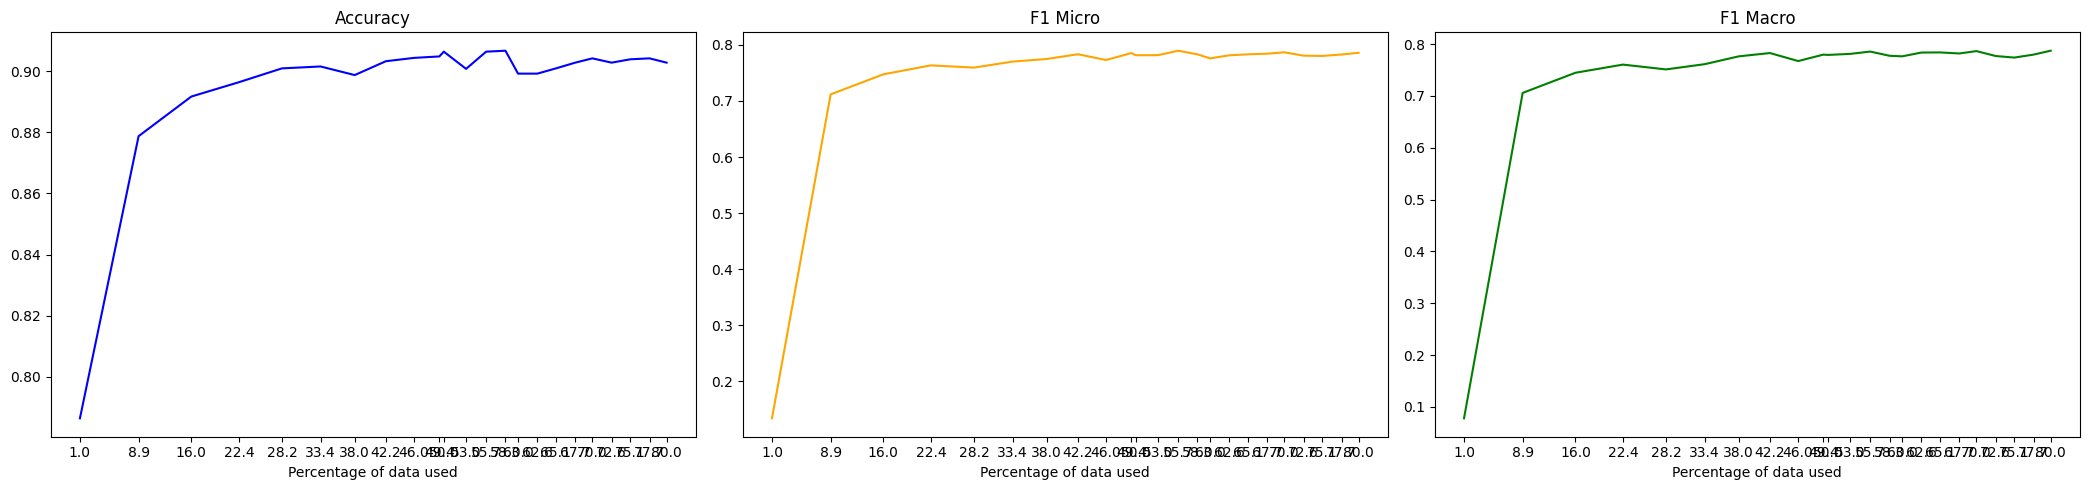

In [30]:
initial_train_size = int(0.01 * total_data)
active_learning(50, 0, 'random', 1)

Init size: 10
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5424, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4401, Accuracy: 0.8241, F1 Micro: 0.3117, F1 Macro: 0.2115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3843, Accuracy: 0.8481, F1 Micro: 0.5106, F1 Macro: 0.4401
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3098, Accuracy: 0.867, F1 Micro: 0.6282, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2726, Accuracy: 0.877, F1 Micro: 0.6974, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2296, Accuracy: 0.8792, F1 Micro: 0.7194, F1 Macro: 0.7138
Epoch 7/10, Train Loss: 0.1744, Accuracy: 0.8816, F1 Micro: 0.7073, F1 Macro: 0.6952
Epoch 8/10, Train Loss: 0.1438, Accuracy: 0.8809, F1 Micro: 0.7176, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1025, Accuracy: 0.8813, F1 Micro: 0.733, F1 Macro: 0.7279
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5262, Accuracy: 0.8059, F1 Micro: 0.1653, F1 Macro: 0.125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.399, Accuracy: 0.8414, F1 Micro: 0.4444, F1 Macro: 0.3736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3043, Accuracy: 0.8723, F1 Micro: 0.6305, F1 Macro: 0.62
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2653, Accuracy: 0.8833, F1 Micro: 0.6945, F1 Macro: 0.6853
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2127, Accuracy: 0.8894, F1 Micro: 0.7326, F1 Macro: 0.7235
Epoch 6/10, Train Loss: 0.1666, Accuracy: 0.8859, F1 Micro: 0.7197, F1 Macro: 0.7019
Epoch 7/10, Train Loss: 0.1282, Accuracy: 0.8884, F1 Micro: 0.7271, F1 Macro: 0.7157
Epoch 8/10, Train Loss: 0.1037, Accuracy: 0.8869, F1 Micro: 0.7253, F1 Macro: 0.7123
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0851, Accuracy: 0.8859, F1 Micro: 0.7422, F1 Macro: 0.7392
Epoch 10/10, Train Loss: 0.0669, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4893, Accuracy: 0.8275, F1 Micro: 0.3405, F1 Macro: 0.2482
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3554, Accuracy: 0.8725, F1 Micro: 0.6897, F1 Macro: 0.6834
Epoch 3/10, Train Loss: 0.2687, Accuracy: 0.8825, F1 Micro: 0.6736, F1 Macro: 0.6368
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2225, Accuracy: 0.8895, F1 Micro: 0.7319, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1793, Accuracy: 0.89, F1 Micro: 0.7491, F1 Macro: 0.7404
Epoch 6/10, Train Loss: 0.1433, Accuracy: 0.8892, F1 Micro: 0.7402, F1 Macro: 0.7339
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.8911, F1 Micro: 0.7486, F1 Macro: 0.7417
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.89, F1 Micro: 0.7477, F1 Macro: 0.7388
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.8941, F1 Micro: 0.7472, F1 Macro: 0.7385
Epoch 10/10, Train Loss: 0.0493, Accuracy: 0.8898, F1 Micro: 0.732, F1 Macro: 0.7244

 Iteration 1812: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4713, Accuracy: 0.8497, F1 Micro: 0.5366, F1 Macro: 0.4705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3294, Accuracy: 0.8722, F1 Micro: 0.6368, F1 Macro: 0.629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2531, Accuracy: 0.8917, F1 Micro: 0.7216, F1 Macro: 0.7075
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1994, Accuracy: 0.8952, F1 Micro: 0.7608, F1 Macro: 0.7585
Epoch 5/10, Train Loss: 0.1517, Accuracy: 0.8939, F1 Micro: 0.7397, F1 Macro: 0.7219
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.8967, F1 Micro: 0.759, F1 Macro: 0.7541
Epoch 7/10, Train Loss: 0.0931, Accuracy: 0.895, F1 Micro: 0.7476, F1 Macro: 0.7417
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.8959, F1 Micro: 0.7604, F1 Macro: 0.76
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.8941, F1 Micro: 0.7498, F1 Macro: 0.7461
Epoch 10/10, Train Loss: 0.0439, Accuracy: 0.8911, F1 Micro: 0.7448, F1 Macro: 0.7406

 Iteration 2253: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4546, Accuracy: 0.8466, F1 Micro: 0.4765, F1 Macro: 0.3933
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2975, Accuracy: 0.8866, F1 Micro: 0.7358, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2439, Accuracy: 0.8941, F1 Micro: 0.75, F1 Macro: 0.7421
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1917, Accuracy: 0.8963, F1 Micro: 0.7502, F1 Macro: 0.7415
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.8977, F1 Micro: 0.7648, F1 Macro: 0.7568
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.8947, F1 Micro: 0.7493, F1 Macro: 0.7417
Epoch 7/10, Train Loss: 0.0892, Accuracy: 0.8931, F1 Micro: 0.7581, F1 Macro: 0.7525
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.8948, F1 Micro: 0.755, F1 Macro: 0.7527
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.8958, F1 Micro: 0.762, F1 Macro: 0.759
Epoch 10/10, Train Loss: 0.041, Accuracy: 0.8975, F1 Micro: 0.7637, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.446, Accuracy: 0.862, F1 Micro: 0.6063, F1 Macro: 0.5818
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2954, Accuracy: 0.8908, F1 Micro: 0.7501, F1 Macro: 0.7442
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2345, Accuracy: 0.8973, F1 Micro: 0.7569, F1 Macro: 0.7498
Epoch 4/10, Train Loss: 0.1827, Accuracy: 0.8927, F1 Micro: 0.7244, F1 Macro: 0.6954
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9002, F1 Micro: 0.7636, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9003, F1 Micro: 0.769, F1 Macro: 0.7614
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.8994, F1 Micro: 0.7553, F1 Macro: 0.7455
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.8986, F1 Micro: 0.7646, F1 Macro: 0.7574
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.8902, F1 Micro: 0.7548, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.044, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4335, Accuracy: 0.8727, F1 Micro: 0.6418, F1 Macro: 0.6298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2791, Accuracy: 0.8933, F1 Micro: 0.7382, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2259, Accuracy: 0.8909, F1 Micro: 0.7595, F1 Macro: 0.7598
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.8983, F1 Micro: 0.755, F1 Macro: 0.737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9034, F1 Micro: 0.7726, F1 Macro: 0.7629
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9011, F1 Micro: 0.7686, F1 Macro: 0.7635
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9008, F1 Micro: 0.7639, F1 Macro: 0.7551
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9006, F1 Micro: 0.7627, F1 Macro: 0.7556
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.8966, F1 Micro: 0.769, F1 Macro: 0.763
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.8967, F1 Micro: 0.7694, F1 Macro: 0.7681

 Iteration 3329: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4196, Accuracy: 0.8681, F1 Micro: 0.6483, F1 Macro: 0.6473
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2685, Accuracy: 0.8925, F1 Micro: 0.7465, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.9003, F1 Micro: 0.7521, F1 Macro: 0.7369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1782, Accuracy: 0.9016, F1 Micro: 0.7595, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.8986, F1 Micro: 0.7604, F1 Macro: 0.7519
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9002, F1 Micro: 0.7704, F1 Macro: 0.7677
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9008, F1 Micro: 0.7695, F1 Macro: 0.767
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.8975, F1 Micro: 0.769, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.8991, F1 Micro: 0.7531, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4207, Accuracy: 0.8739, F1 Micro: 0.6428, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2761, Accuracy: 0.8956, F1 Micro: 0.7537, F1 Macro: 0.7476
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.8961, F1 Micro: 0.7469, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9013, F1 Micro: 0.7812, F1 Macro: 0.7782
Epoch 5/10, Train Loss: 0.1376, Accuracy: 0.8925, F1 Micro: 0.7711, F1 Macro: 0.7705
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9013, F1 Micro: 0.7782, F1 Macro: 0.7737
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9008, F1 Micro: 0.7513, F1 Macro: 0.7453
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9042, F1 Micro: 0.7773, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.8992, F1 Micro: 0.763, F1 Macro: 0.7569
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.8991, F1 Micro: 0.7698, F1 Macro: 0.7673

 Iteration 3878: Accuracy: 0.9013, F1 Micro: 0.7812,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4147, Accuracy: 0.8763, F1 Micro: 0.6822, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2661, Accuracy: 0.8966, F1 Micro: 0.7487, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.9013, F1 Micro: 0.7718, F1 Macro: 0.7675
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9006, F1 Micro: 0.7454, F1 Macro: 0.7284
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9017, F1 Micro: 0.7735, F1 Macro: 0.7695
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9023, F1 Micro: 0.7672, F1 Macro: 0.7631
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9006, F1 Micro: 0.7618, F1 Macro: 0.7578
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.8975, F1 Micro: 0.7698, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9005, F1 Micro: 0.769, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0363, Accuracy: 0.9005, F1 Micro: 0.7745, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3999, Accuracy: 0.8745, F1 Micro: 0.6522, F1 Macro: 0.6441
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2636, Accuracy: 0.8955, F1 Micro: 0.7563, F1 Macro: 0.748
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.9003, F1 Micro: 0.7733, F1 Macro: 0.767
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9009, F1 Micro: 0.7506, F1 Macro: 0.7402
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9006, F1 Micro: 0.7776, F1 Macro: 0.7736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9025, F1 Micro: 0.7829, F1 Macro: 0.7813
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9017, F1 Micro: 0.7722, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.8994, F1 Micro: 0.7724, F1 Macro: 0.7657
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9041, F1 Micro: 0.7658, F1 Macro: 0.7591
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9044, F1 Micro: 0.7779, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3989, Accuracy: 0.8747, F1 Micro: 0.6894, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2607, Accuracy: 0.8958, F1 Micro: 0.7418, F1 Macro: 0.733
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.9003, F1 Micro: 0.7697, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9038, F1 Micro: 0.7784, F1 Macro: 0.7736
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.902, F1 Micro: 0.7656, F1 Macro: 0.7603
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9011, F1 Micro: 0.7656, F1 Macro: 0.7608
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9003, F1 Micro: 0.7805, F1 Macro: 0.7789
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9013, F1 Micro: 0.7732, F1 Macro: 0.7713
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9006, F1 Micro: 0.7748, F1 Macro: 0.7725
Epoch 10/10, Train Loss: 0.0358, Accuracy: 0.9022, F1 Micro: 0.7779, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3976, Accuracy: 0.8805, F1 Micro: 0.7182, F1 Macro: 0.7134
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2584, Accuracy: 0.8931, F1 Micro: 0.7199, F1 Macro: 0.7091
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9013, F1 Micro: 0.7781, F1 Macro: 0.7786
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9031, F1 Micro: 0.7599, F1 Macro: 0.7551
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9047, F1 Micro: 0.7674, F1 Macro: 0.7531
Epoch 6/10, Train Loss: 0.0997, Accuracy: 0.8964, F1 Micro: 0.7779, F1 Macro: 0.7806
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9036, F1 Micro: 0.7756, F1 Macro: 0.7712
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.897, F1 Micro: 0.7744, F1 Macro: 0.7715
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9006, F1 Micro: 0.7681, F1 Macro: 0.7645
Epoch 10/10, Train Loss: 0.0371, Accuracy: 0.9022, F1 Micro: 0.7758, F1 Macro: 0.7737

 Iteration 4530: Accuracy: 0.9013, F1 Micro: 0.7781,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3917, Accuracy: 0.8814, F1 Micro: 0.6982, F1 Macro: 0.6854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2539, Accuracy: 0.8972, F1 Micro: 0.7552, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2044, Accuracy: 0.8995, F1 Micro: 0.7671, F1 Macro: 0.7584
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.8986, F1 Micro: 0.746, F1 Macro: 0.7386
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9009, F1 Micro: 0.765, F1 Macro: 0.7631
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9006, F1 Micro: 0.7535, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9036, F1 Micro: 0.7756, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9039, F1 Micro: 0.7781, F1 Macro: 0.7739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9017, F1 Micro: 0.7783, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3901, Accuracy: 0.8833, F1 Micro: 0.7182, F1 Macro: 0.7093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2554, Accuracy: 0.8972, F1 Micro: 0.7647, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9033, F1 Micro: 0.7747, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9041, F1 Micro: 0.7809, F1 Macro: 0.7777
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.9064, F1 Micro: 0.781, F1 Macro: 0.7794
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9025, F1 Micro: 0.7806, F1 Macro: 0.781
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9003, F1 Micro: 0.7726, F1 Macro: 0.7738
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9038, F1 Micro: 0.7717, F1 Macro: 0.767
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.8948, F1 Micro: 0.7709, F1 Macro: 0.766
Epoch 10/10, Train Loss: 0.0354, Accuracy: 0.9006, F1 Micro: 0.7796, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3845, Accuracy: 0.88, F1 Micro: 0.7007, F1 Macro: 0.6988
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.8959, F1 Micro: 0.7569, F1 Macro: 0.7547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2049, Accuracy: 0.8992, F1 Micro: 0.7823, F1 Macro: 0.7821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9034, F1 Micro: 0.7876, F1 Macro: 0.7869
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9003, F1 Micro: 0.7806, F1 Macro: 0.7796
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9031, F1 Micro: 0.758, F1 Macro: 0.7505
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9022, F1 Micro: 0.7636, F1 Macro: 0.7596
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9031, F1 Micro: 0.7754, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9031, F1 Micro: 0.7734, F1 Macro: 0.7668
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.903, F1 Micro: 0.7734, F1 Macro: 0.7668

 Iteration 5063: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3843, Accuracy: 0.8823, F1 Micro: 0.7253, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.897, F1 Micro: 0.7682, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.903, F1 Micro: 0.7713, F1 Macro: 0.7703
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9025, F1 Micro: 0.7613, F1 Macro: 0.7565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.902, F1 Micro: 0.7776, F1 Macro: 0.773
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9014, F1 Micro: 0.7747, F1 Macro: 0.7719
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.8998, F1 Micro: 0.7766, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.9014, F1 Micro: 0.7781, F1 Macro: 0.7765
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9038, F1 Micro: 0.7651, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0337, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3789, Accuracy: 0.8889, F1 Micro: 0.7304, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.8977, F1 Micro: 0.7603, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.9016, F1 Micro: 0.7782, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.903, F1 Micro: 0.7829, F1 Macro: 0.7808
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.8953, F1 Micro: 0.7723, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9033, F1 Micro: 0.783, F1 Macro: 0.7785
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9009, F1 Micro: 0.7755, F1 Macro: 0.7741
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.9009, F1 Micro: 0.7582, F1 Macro: 0.7485
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9008, F1 Micro: 0.7736, F1 Macro: 0.7676
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.8967, F1 Micro: 0.7769, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3753, Accuracy: 0.8833, F1 Micro: 0.7037, F1 Macro: 0.672
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2434, Accuracy: 0.9006, F1 Micro: 0.7595, F1 Macro: 0.7569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.902, F1 Micro: 0.7597, F1 Macro: 0.7524
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9011, F1 Micro: 0.7854, F1 Macro: 0.7809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9045, F1 Micro: 0.7908, F1 Macro: 0.7906
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.8944, F1 Micro: 0.7659, F1 Macro: 0.7651
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.903, F1 Micro: 0.7726, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9019, F1 Micro: 0.773, F1 Macro: 0.7683
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9047, F1 Micro: 0.7863, F1 Macro: 0.7831
Epoch 10/10, Train Loss: 0.0359, Accuracy: 0.9017, F1 Micro: 0.7745, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3717, Accuracy: 0.8869, F1 Micro: 0.7118, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.8995, F1 Micro: 0.7611, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1983, Accuracy: 0.9034, F1 Micro: 0.7689, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9034, F1 Micro: 0.7876, F1 Macro: 0.7876
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9036, F1 Micro: 0.7662, F1 Macro: 0.7538
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9031, F1 Micro: 0.7615, F1 Macro: 0.7516
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9038, F1 Micro: 0.7755, F1 Macro: 0.7736
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.905, F1 Micro: 0.7818, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.8988, F1 Micro: 0.7725, F1 Macro: 0.7715
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.9036, F1 Micro: 0.7749, F1 Macro: 0.769

 Iteration 5841: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.372, Accuracy: 0.89, F1 Micro: 0.7273, F1 Macro: 0.7224
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2401, Accuracy: 0.9011, F1 Micro: 0.775, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9023, F1 Micro: 0.786, F1 Macro: 0.7852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.9041, F1 Micro: 0.7868, F1 Macro: 0.7844
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.9047, F1 Micro: 0.7729, F1 Macro: 0.7654
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9016, F1 Micro: 0.7597, F1 Macro: 0.7538
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9039, F1 Micro: 0.768, F1 Macro: 0.7596
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9014, F1 Micro: 0.7808, F1 Macro: 0.7794
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.9036, F1 Micro: 0.7717, F1 Macro: 0.7678
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.905, F1 Micro: 0.78, F1 Macro: 0.7769

 Iteration 6041: Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3638, Accuracy: 0.8884, F1 Micro: 0.7287, F1 Macro: 0.7201
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.9009, F1 Micro: 0.7714, F1 Macro: 0.7653
Epoch 3/10, Train Loss: 0.1955, Accuracy: 0.9025, F1 Micro: 0.7591, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.9072, F1 Micro: 0.7785, F1 Macro: 0.7733
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9045, F1 Micro: 0.7678, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.9039, F1 Micro: 0.7853, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.9039, F1 Micro: 0.7716, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9052, F1 Micro: 0.7717, F1 Macro: 0.7681
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9038, F1 Micro: 0.7848, F1 Macro: 0.7813
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.9084, F1 Micro: 0.7857, F1

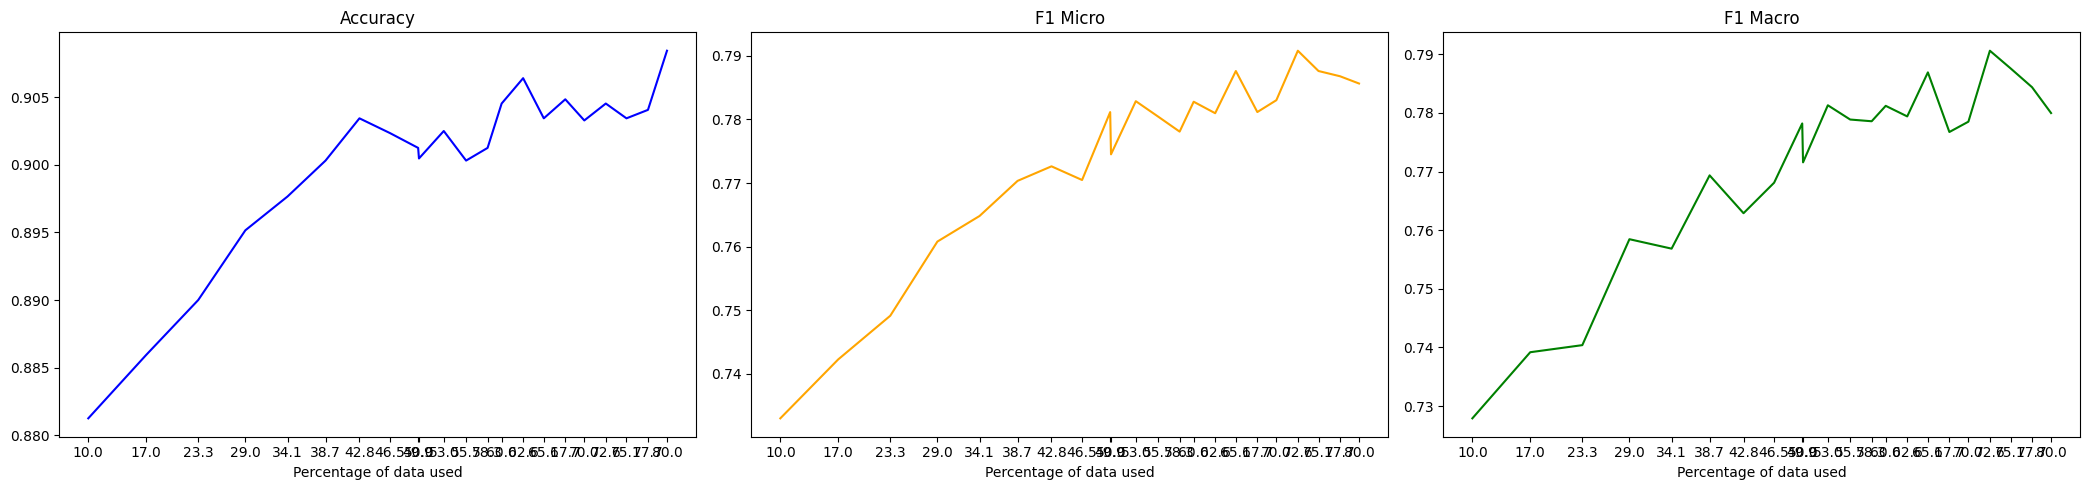

In [31]:
initial_train_size = int(0.1 * total_data)
active_learning(50, 0, 'random', 10)